<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/France/AirFrance/AirFrance_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AFFREUR"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-26 19:25:31,703 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-26 19:25:31,704 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for AFFREUR
2019-08-26 19:28:23,157 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-26 19:34:52,945 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-26 19:38:24,312 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-26 19:41:48,873 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-26 19:45:10,988 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-26 19:48:27,129 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-26 19:51:58,962 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-26 19:55:33,710 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-3

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-26 20:06:12,919 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_439__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_AFFREUR__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-AFFREUR__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-AFFREUR to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open     High      Low    Close    Volume
Date                                                             
2018-01-02 08:00:00  0.13678  0.13703  0.13467  0.13678  4.181126
2018-01-02 09:00:00  0.13678  0.13758  0.13593  0.13623  2.800677
2018-01-02 10:00:00  0.13623  0.13683  0.13588  0.13623  1.366022
2018-01-02 11:00:00  0.13622  0.13678  0.13592  0.13657  1.118289
2018-01-02 12:00:00  0.13663  0.13828  0.13653  0.13807  1.172593
...                      ...      ...      ...      ...       ...
2018-12-31 08:00:00  0.09397  0.09556  0.09357  0.09545  3.073051
2018-12-31 09:00:00  0.09541  0.09544  0.09478  0.09538  1.742141
2018-12-31 10:00:00  0.09537  0.09568  0.09527  0.09549  1.091274
2018-12-31 11:00:00  0.09549  0.09568  0.09507  0.09520  1.623163
2018-12-31 12:00:00  0.09515  0.09538  0.09451  0.09458  2.271411

[2278 rows x 5 columns]

Open         High          Low        Close       Volume
count  2278.000000  2278.000000  2278.000000  2278.000000  2278.000000
mean      0.090152     0.090657     0.089647     0.090147     3.254480
std       0.016902     0.016953     0.016817     0.016877     2.802975
min       0.066750     0.067200     0.066390     0.066740     0.001590
25%       0.079013     0.079502     0.078370     0.079075     1.348653
50%       0.087610     0.088160     0.087050     0.087585     2.278456
75%       0.096632     0.097255     0.096025     0.096650     4.285325
max       0.144070     0.145030     0.143270     0.144030    21.519575

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2018-01-09 13:00:00  0.14227  0.14293  0.14197  0.14203  1.332328    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  0.142417  0.140851 -0.144970  0.142517  0.142577  0.142725    0.143030    0.143500  0.144789  0.142875  0.142257  0.142978  0.142665  0.142875  0.142343  0.142438                0.144039                 0.142875                0.141711                0.144621                 0.142875                0.141129                0.145204                 0.142875                0.140546                0.145786                 0.142875                0.139964  0.142577  0.142299  0.142513                0.143741                 0.142577                0.141413                0.144324                 0.142577                0.140831                0.144906                 0.142577                0.140249                0.145488                 0.142577   
2018-01-09 14:00:00  0.14208  0.14238  0.14117  0.14122  2.531590    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.142357  0.140889 -0.144850  0.141994  0.142276  0.142569    0.142625    0.143100  0.144564  0.142656  0.141620  0.142723  0.142297  0.142656  0.141625  0.142464                0.144247                 0.142656                0.141066                0.145042                 0.142656                0.140271                0.145837                 0.142656                0.139476                0.146632                 0.142656                0.138680  0.142276  0.141536  0.142528                0.143866                 0.142276                0.140685                0.144661                 0.142276                0.139890                0.145456                 0.142276                0.139095                0.146251                 0.142276   
2018-01-09 15:00:00  0.14123  0.14259  0.14027  0.14217 

Open         High          Low        Close       Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000    2228.000000  2228.000000   2228.000000     2228.000000     2228.000000       2228.000000  2228.000000  2228.000000  2228.000000  2228.000000   2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000  2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000  2228.000000  2228.000000  2228.000000             2228.000000              2228.000000             2228.000000             2228.000000              2228.000000             2228.000000             2228.000000   
mean      0.089002     0.089503     0.088498     0.088994     3.286360    16.006284     2.018851   185.537253      30.423698    11.377917      0.034111        0.023788        0.002244          0.004039     6.600539     2.535009    26.957361     2.018851      2.008528    26.957361     0.089013     0.089191    -0.004208     0.088993     0.089070     0.089092     0.089063     0.089067     0.089188     0.089069     0.088994     0.089069     0.089044     0.089069     0.089011     0.089225                0.090590                 0.089069                0.087549                0.091350                 0.089069                0.086789                0.092110                 0.089069                0.086029                0.092870                 0.089069                0.085269     0.089070     0.089011     0.089201                0.090590                 0.089070                0.087550                0.091350                 0.089070                0.086790                0.092110   
std       0.015219     0.015267     0.015128     0.015183     2.824026     8.586021     1.413453   101.854206       0.853958     2.619209      0.181556        0.152423        0.047330          0.063443     3.351472     1.102365    14.551473     1.413453      1.403830    14.551473     0.015308     0.015553     0.090539     0.015191     0.015289     0.015350     0.015284     0.015277     0.015554     0.015302     0.015187     0.015307     0.015257     0.015302     0.015208     0.015544                0.015522                 0.015302                0.015153                0.015659                 0.015302                0.015107                0.015812                 0.015302                0.015079                0.015982                 0.015302                0.015070     0.015289     0.015204     0.015508                0.015505                 0.015289                0.015145                0.015640                 0.015289                0.015100                0.015791   
min       0.066750     0.067200     0.0663

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-09 13:00:00  1.000000  1.000000  1.000000  0.998144  0.061843    9          1          9             31    13             0               0               0                 0      1        1     2        1             0           2  1.000000  0.994101  0.000000  1.000000  1.000000  1.000000    1.000000    1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  0.999571                0.977774                 1.000000                1.000000                0.950881                 1.000000                1.000000                0.923542                 1.000000                1.000000                0.897788                 1.000000                1.000000  1.000000  1.000000  0.999798                0.984149                 1.000000                1.000000                0.957520                 1.000000                1.000000                0.929579                 1.000000                1.000000                0.902690                 1.000000   
2018-01-09 14:00:00  0.997484  0.992737  0.989415  0.987406  0.117576    9          1          9             31    14             0               0               0                 0      1        1     2        1             0           2  0.999204  0.994614  0.000431  0.993095  0.995998  0.997922    0.994663    0.994747  0.997123  0.997116  0.991557  0.996643  0.995137  0.997116  0.990485  0.999925                0.980422                 0.997116                0.991546                0.956080                 0.997116                0.989208                0.931115                 0.997116                0.987169                0.907583                 0.997116                0.985345  0.995998  0.989872  1.000000                0.985761                 0.995998                0.990426                0.961753                 0.995998                0.988271                0.936253                 0.995998                0.986333                0.911639                 0.995998   
2018-01-09 15:00:00  0.986229  0.995510  

52

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpem1g95__
  JVM stdout: /tmp/tmpem1g95__/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpem1g95__/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 7 days
H2O cluster name:           H2O_from_python_unknownUser_ovfxcr
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_201634_mod...  0.538406  0.695812              0.495089  0.501218  0.251219
1  DeepLearning_grid_1_AutoML_20190826_201634_mod...  0.514895  2.797943              0.457206  0.665643  0.443081
2  DeepLearning_grid_1_AutoML_20190826_201634_mod...  0.511634  0.692936              0.481481  0.499894  0.249894
3  DeepLearning_grid_1_AutoML_20190826_201634_mod...  0.500000  0.692747              0.500000  0.499800  0.249800
4  DeepLearning_grid_1_AutoML_20190826_201634_mod...  0.499114  1.151503              0.495370  0.604868  0.365866
5  DeepLearning_grid_1_AutoML_20190826_201634_mod...  0.497182  0.693926              0.490741  0.500414  0.250414
6  DeepLearning_grid_1_AutoML_20190826_201634_mod...  0.496216  0.781977              0.490741  0.533528  0.284652
7  DeepLearning_grid_1_AutoML_20190826_201634_mod...  0.481240  0.702597              0.500000  0.504624  0.254645
8              DeepLearning_1_AutoML_20190826_201634  0.480354  0.756206              0.490177  0.526309  0.277001
9  DeepLearning_grid_1_AutoML_20190826_201634_mod...  0.464211  0.923136              0.495089  0.580325  0.336777

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.002093
1                 HT_TRENDMODE             0.995611           0.995611    0.002083
2                         hour             0.983581           0.983581    0.002058
3                          day             0.978450           0.978450    0.002047
4                      weekday             0.930917           0.930917    0.001948
...                        ...                  ...                ...         ...
1032   BBANDS_upperband_30_2_3             0.385172           0.385172    0.000806
1033   BBANDS_middleband_8_0_3             0.384826           0.384826    0.000805
1034                 MAVP_24_3             0.383239           0.383239    0.000802
1035   BBANDS_upperband_24_3_2             0.379323           0.379323    0.000794
1036  BBANDS_middleband_14_1_2             0.369705           0.369705    0.000774

[1037 rows x 4 columns]

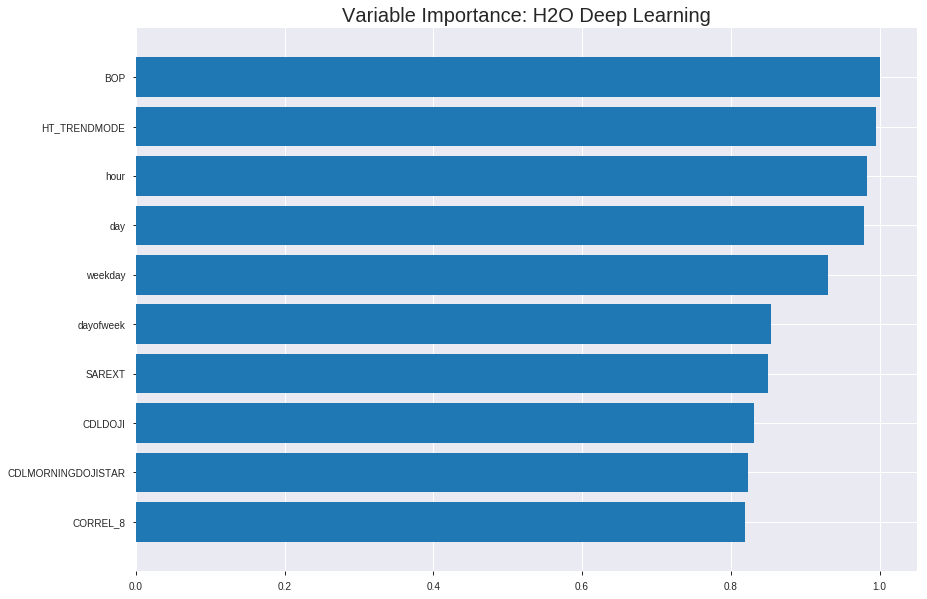

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_201634_model_2


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2855577261963155
RMSE: 0.5343760157382772
LogLoss: 0.7822449978222495
Mean Per-Class Error: 0.46579057154776804
AUC: 0.535249100901819
pr_auc: 0.5254520887292418
Gini: 0.07049820180363797
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2125315414602467: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      12   787   0.985    (787.0/799.0)
1      3    756   0.004    (3.0/759.0)
Total  15   1543  0.5071   (790.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.212532     0.65682    387
max f2                       0.178638     0.826978   395
max f0point5                 0.245907     0.546909   374
max accuracy                 0.810673     0.538511   59
max precision                0.902208     1          0
max recall                   0.178638     1          395
max specificity              0.902208     1          0
max absolute_mcc             0.810673     0.0805323  59
max min_per_class_accuracy   0.558761     0.520651   193
max mean_per_class_accuracy  0.507616     0.534209   232

Gains/Lift Table: Avg response rate: 48.72 %, avg score: 58.60 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102696                   0.869964           1.41123   1.41123            0.6875           0.883058  0.6875                      0.883058            0.0144928       0.0144928                  41.1232    41.1232
    2        0.0205392                   0.865381           1.02635   1.21879            0.5              0.868007  0.59375                     0.875533            0.0105402       0.0250329                  2.63505    21.8791
    3        0.0301669                   0.858327           1.50531   1.31023            0.733333         0.861627  0.638298                    0.871095            0.0144928       0.0395257                  50.5314    31.0235
    4        0.0404365                   0.85226            1.41123   1.33588            0.6875           0.855086  0.650794                    0.867029            0.0144928       0.0540184                  41.1232    33.5885
    5        0.0500642                   0.84924            1.09477   1.28952            0.533333         0.850797  0.628205                    0.863907            0.0105402       0.0645586                  9.47738    28.9517
    6        0.100128                    0.830524           1.05267   1.17109            0.512821         0.840071  0.570513                    0.851989            0.0527009       0.11726                    5.26671    17.1092
    7        0.150193                    0.813579           1.15793   1.16671            0.564103         0.822074  0.568376                    0.842018            0.057971        0.175231                   15.7934    16.6706
    8        0.200257                    0.798534           1.07898   1.14478            0.525641         0.806857  0.557692                    0.833227            0.0540184       0.229249                   7.89838    14.4776
    9        0.300385                    0.755069           0.855292  1.04828            0.416667         0.778824  0.510684                    0.815093            0.085639        0.314888                   -14.4708   4.8281
    10       0.399872                    0.638243           0.993242  1.03459            0.483871         0.701778  0.504013                    0.786901            0.0988142       0.413702                   -0.675762  3.45876
    11       0.5                         0.558688           1.09214   1.04611            0.532051         0.591249  0.509628                    0.74772             0.109354        0.523057                   9.21422    4.61133
    12       0.600128                    0.517621           1.1053    1.05599            0.538462         0.536809  0.514439                    0.712531            0.110672        0.633729                   10.53      5.59884
    13       0.699615                    0.474348           0.913783  1.03577            0.445161         0.496939  0.504587                    0.681873            0.0909091       0.724638                   -8.6217    3.57665
    14       0.799743                    0.418727           0.921084  1.02141            0.448718         0.446376  0.497592                    0.652389            0.0922266       0.816864                   -7.89163   2.14082
    15       0.899872                    0.325744           0.894767  1.00732            0.435897         0.3772    0.490728                    0.621769            0.0895916       0.906456                   -10.5233   0.731686
    16       1                           0.148948           0.934242  1                  0.455128         0.264389  0.487163                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2535226403035558
RMSE: 0.5035103179712962
LogLoss: 0.7003991845726051
Mean Per-Class Error: 0.4624047966293956
AUC: 0.5014786906498137
pr_auc: 0.5514677695472232
Gini: 0.002957381299627304
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37762429426881744: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    202  0.9902   (202.0/204.0)
1      0    242  0        (0.0/242.0)
Total  2    444  0.4529   (202.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.377624     0.705539   397
max f2                       0.377624     0.856941   397
max f0point5                 0.394148     0.601712   391
max accuracy                 0.394148     0.55157    391
max precision                0.675872     0.777778   8
max recall                   0.377624     1          397
max specificity              0.70801      0.995098   0
max absolute_mcc             0.579779     0.0799683  128
max min_per_class_accuracy   0.538976     0.485294   197
max mean_per_class_accuracy  0.579779     0.537595   128

Gains/Lift Table: Avg response rate: 54.26 %, avg score: 53.75 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.686756           1.10579   1.10579            0.6              0.696602  0.6                         0.696602            0.0123967       0.0123967                  10.5785   10.5785
    2        0.0201794                   0.674682           1.84298   1.43343            1                0.679847  0.777778                    0.689155            0.0165289       0.0289256                  84.2975   43.3425
    3        0.0313901                   0.668066           0.73719   1.18477            0.4              0.672043  0.642857                    0.683044            0.00826446      0.0371901                  -26.281   18.477
    4        0.0403587                   0.658111           0.921488  1.12626            0.5              0.661522  0.611111                    0.678261            0.00826446      0.0454545                  -7.85124  12.6263
    5        0.0515695                   0.652635           0.73719   1.04168            0.4              0.655132  0.565217                    0.673233            0.00826446      0.053719                   -26.281   4.16816
    6        0.100897                    0.630024           1.08903   1.06483            0.590909         0.640277  0.577778                    0.657121            0.053719        0.107438                   8.90308   6.48301
    7        0.150224                    0.616842           0.921488  1.01776            0.5              0.62381   0.552239                    0.646183            0.0454545       0.152893                   -7.85124  1.77624
    8        0.201794                    0.60431            1.04168   1.02388            0.565217         0.609754  0.555556                    0.636873            0.053719        0.206612                   4.16816   2.38751
    9        0.300448                    0.583593           1.13092   1.05902            0.613636         0.594033  0.574627                    0.622806            0.11157         0.318182                   13.0917   5.90231
    10       0.401345                    0.563855           0.860055  1.009              0.466667         0.574692  0.547486                    0.610711            0.0867769       0.404959                   -13.9945  0.900319
    11       0.5                         0.538855           0.837716  0.975207           0.454545         0.551551  0.529148                    0.599038            0.0826446       0.487603                   -16.2284  -2.47934
    12       0.600897                    0.52366            1.10579   0.997132           0.6              0.531486  0.541045                    0.587695            0.11157         0.599174                   10.5785   -0.286789
    13       0.699552                    0.490514           1.04715   1.00419            0.568182         0.5091    0.544872                    0.576611            0.103306        0.702479                   4.7145    0.418521
    14       0.800448                    0.466603           0.90101   0.99118            0.488889         0.478386  0.537815                    0.56423             0.0909091       0.793388                   -9.89899  -0.882006
    15       0.899103                    0.435682           1.00526   0.992725           0.545455         0.449592  0.538653                    0.551651            0.0991736       0.892562                   0.52592   -0.72752
    16       1                           0.355245           1.06483   1                  0.577778         0.411498  0.542601                    0.53751   


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 20:18:06  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 20:18:07  1 min 27.653 sec  456 obs/sec       0.333761  1             520        0.700862         8.25891             -0.966128      0.495144        0.274419           0.948324         0.512837                         0.644148           6.35646               -0.671845        0.535843          0.389347             1.0262             0.455157
    2019-08-26 20:18:17  1 min 37.639 sec  398 obs/sec       2.60398   8             4057       0.553332         0.886272            -0.225512      0.531518        0.500178           0.898057         0.503209                         0.520687           0.752749              -0.0923894       0.53873           0.562228             0.73719            0.452915
    2019-08-26 20:18:27  1 min 47.436 sec  401 obs/sec       4.90436   15            7641       0.538713         0.846963            -0.161611      0.534152        0.519879           1.41123          0.510911                         0.530527           0.764124              -0.134067        0.483815          0.546335             1.10579            0.455157
    2019-08-26 20:18:36  1 min 56.919 sec  406 obs/sec       7.19191   22            11205      0.508064         0.715424            -0.0331976     0.540685        0.515936           0.769763         0.512837                         0.522767           0.746292              -0.101135        0.48419           0.517801             0.368595           0.457399
    2019-08-26 20:18:46  2 min  6.494 sec  408 obs/sec       9.49743   29            14797      0.516944         0.73504             -0.0696293     0.542861        0.525786           1.28294          0.512837                         0.512379           0.721801              -0.0578087       0.53006           0.557154             0.73719            0.457399
    2019-08-26 20:18:56  2 min 16.555 sec  416 obs/sec       12.1252   37            18891      0.534376         0.782245            -0.142984      0.535249        0.525452           1.41123          0.50706                          0.50351            0.700399              -0.021506        0.501479          0.551468             1.10579            0.452915
    2019-08-26 20:19:06  2 min 26.506 sec  422 obs/sec       14.7561   45            22990      0.499358         0.692521            0.00190648     0.592352        0.572492           1.53953          0.498716                         0.523223           0.747179              -0.103058        0.518565          0.578269             1.47438            0.457399
    2019-08-26 20:19:16  2 min 36.199 sec  427 obs/sec       17.3415   53            27018      0.541132         0.818074            -0.172066      0.5744          0.552302           1.41123          0.505777                         0.554374           0.833407              -0.23831         0.50081           0.537927             1.10579            0.457399
    2019-08-26 20:19:25

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.002092561494228223
HT_TRENDMODE              0.9956112504005432     0.9956112504005432   0.0020833777658085906
hour                      0.9835810661315918     0.9835810661315918   0.0020582038654389126
day                       0.9784499406814575     0.9784499406814575   0.002047466669899907
weekday                   0.9309171438217163     0.9309171438217163   0.0019480013694782405
---                       ---                    ---                  ---
BBANDS_upperband_30_2_3   0.38517239689826965    0.38517239689826965  0.0008059969263889094
BBANDS_middleband_8_0_3   0.3848264217376709     0.3848264217376709   0.000805272952089881
MAVP_24_3                 0.3832392692565918     0.3832392692565918   0.0008019517379225062
BBANDS_upperband_24_3_2   0.37932321429252625    0.37932321429252625  0.0007937571520954213
BBANDS_middleband_14_1_2  0.3697051703929901     0.3697051703929901   0.0007736308037814553


See the whole table with table.as_data_frame()


('accuracy', 0.547085201793722)

('F1', 0.6805970149253733)

('auc', 0.5384057971014493)

('logloss', 0.6958120985403521)

('mean_per_class_error', 0.442512077294686)

('rmse', 0.5012178333239626)

('mse', 0.25121931644196754)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


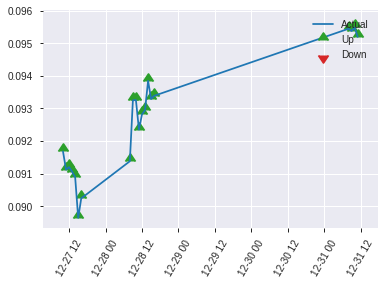


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25121931644196754
RMSE: 0.5012178333239626
LogLoss: 0.6958120985403521
Mean Per-Class Error: 0.442512077294686
AUC: 0.5384057971014493
pr_auc: 0.5579503026153785
Gini: 0.07681159420289863
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3134835708400198: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    106  0.9815   (106.0/108.0)
1      1    114  0.0087   (1.0/115.0)
Total  3    220  0.4798   (107.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.313484     0.680597  219
max f2                       0.276603     0.841874  222
max f0point5                 0.379371     0.578339  208
max accuracy                 0.518753     0.547085  37
max precision                0.583608     1         0
max recall                   0.276603     1         222
max specificity              0.583608     1         0
max absolute_mcc             0.520778     0.155968  30
max min_per_class_accuracy   0.488226     0.527778  111
max mean_per_class_accuracy  0.518753     0.557488  37

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 47.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.557234           1.29275   1.29275            0.666667         0.567484  0.666667                    0.567484            0.0173913       0.0173913                  29.2754   29.2754
    2        0.0224215                   0.54798            1.93913   1.5513             1                0.551659  0.8                         0.561154            0.0173913       0.0347826                  93.913    55.1304
    3        0.0313901                   0.545309           0         1.10807            0                0.547202  0.571429                    0.557168            0               0.0347826                  -100      10.8075
    4        0.0403587                   0.541898           0.969565  1.07729            0.5              0.543284  0.555556                    0.554082            0.00869565      0.0434783                  -3.04348  7.72947
    5        0.0538117                   0.540677           1.29275   1.13116            0.666667         0.541356  0.583333                    0.550901            0.0173913       0.0608696                  29.2754   13.1159
    6        0.103139                    0.525823           1.58656   1.34896            0.818182         0.531154  0.695652                    0.541457            0.0782609       0.13913                    58.6561   34.896
    7        0.152466                    0.51967            1.23399   1.31176            0.636364         0.522568  0.676471                    0.535345            0.0608696       0.2                        23.3992   31.1765
    8        0.201794                    0.515389           0.881423  1.20657            0.454545         0.517762  0.622222                    0.531047            0.0434783       0.243478                   -11.8577  20.657
    9        0.300448                    0.50481            0.793281  1.07086            0.409091         0.509973  0.552239                    0.524127            0.0782609       0.321739                   -20.6719  7.08631
    10       0.399103                    0.495193           1.05771   1.06761            0.545455         0.500384  0.550562                    0.518258            0.104348        0.426087                   5.77075   6.76111
    11       0.502242                    0.488226           1.01172   1.05613            0.521739         0.491221  0.544643                    0.512706            0.104348        0.530435                   1.17202   5.61335
    12       0.600897                    0.472972           0.793281  1.01298            0.409091         0.480961  0.522388                    0.507494            0.0782609       0.608696                   -20.6719  1.29786
    13       0.699552                    0.454256           0.881423  0.994426           0.454545         0.464933  0.512821                    0.501492            0.0869565       0.695652                   -11.8577  -0.557414
    14       0.798206                    0.437215           1.14585   1.01314            0.590909         0.443217  0.522472                    0.494289            0.113043        0.808696                   14.585    1.31412
    15       0.896861                    0.407875           1.05771   1.01804            0.545455         0.424857  0.525                       0.486652            0.104348        0.913043                   5.77075   1.80435
    16       1                           0.276603           0.8431    1                  0.434783         0.363412  0.515695                    0.473941         

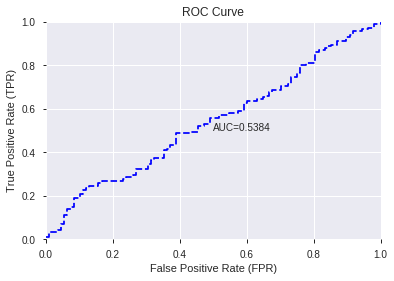

This function is available for GLM models only


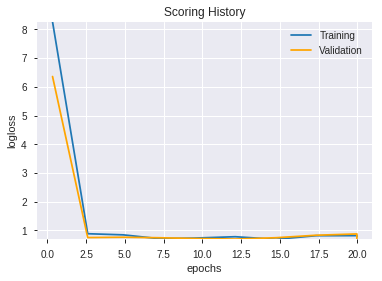

--2019-08-26 20:41:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.164
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.164|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  56.7MB/s    in 7.1s    

2019-08-26 20:41:47 (49.6 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: U

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_201634_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_201634_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_afb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190826_204157  0.538567  0.780205              0.500000  0.524965  0.275588
1  DeepLearning_grid_1_AutoML_20190826_204157_model_1  0.506602  1.148646              0.500000  0.590298  0.348451
2  DeepLearning_grid_1_AutoML_20190826_204157_model_2  0.494767  0.876100              0.495370  0.548415  0.300758
3  DeepLearning_grid_1_AutoML_20190826_204157_model_8  0.480354  0.715939              0.500000  0.510418  0.260527
4  DeepLearning_grid_1_AutoML_20190826_204157_model_4  0.473833  1.156626              0.500000  0.591108  0.349409
5  DeepLearning_grid_1_AutoML_20190826_204157_model_5  0.472705  0.736580              0.495089  0.519680  0.270067
6  DeepLearning_grid_1_AutoML_20190826_204157_model_6  0.461997  0.727882              0.500000  0.515569  0.265812
7  DeepLearning_grid_1_AutoML_20190826_204157_model_7  0.455153  0.779202              0.500000  0.533128  0.284225
8  DeepLearning_grid_1_AutoML_20190826_204157_model_9  0.446699  0.694694              0.495370  0.500765  0.250766
9  DeepLearning_grid_1_AutoML_20190826_204157_model_3  0.441707  1.418966              0.500000  0.601858  0.362233

variable  relative_importance  scaled_importance  percentage
0            weekofyear             1.000000           1.000000    0.028468
1       CDLLADDERBOTTOM             0.994004           0.994004    0.028297
2                MFI_14             0.903196           0.903196    0.025712
3          CDLTHRUSTING             0.893457           0.893457    0.025435
4             dayofweek             0.892985           0.892985    0.025422
5        CDLRICKSHAWMAN             0.864825           0.864825    0.024620
6                   BOP             0.864038           0.864038    0.024598
7        STOCHRSI_fastk             0.863416           0.863416    0.024580
8                   day             0.844637           0.844637    0.024045
9             CORREL_30             0.841079           0.841079    0.023944
10         aroondown_14             0.825521           0.825521    0.023501
11         aroondown_24             0.803243           0.803243    0.022867
12           aroonup_24             0.801748           0.801748    0.022824
13              CDLDOJI             0.801384           0.801384    0.022814
14               ADX_20             0.801287           0.801287    0.022811
15          AROONOSC_24             0.796601           0.796601    0.022678
16            dayofyear             0.788845           0.788845    0.022457
17              weekday             0.759189           0.759189    0.021613
18              BETA_30             0.752751           0.752751    0.021429
19                 hour             0.750400           0.750400    0.021362
20            aroonup_8             0.744310           0.744310    0.021189
21           aroonup_20             0.742367           0.742367    0.021134
22       CDLSPINNINGTOP             0.730697           0.730697    0.020802
23                MFI_8             0.730218           0.730218    0.020788
24           aroonup_12             0.717939           0.717939    0.020438
25        days_in_month             0.676944           0.676944    0.019271
26          STOCH_slowd             0.676565           0.676565    0.019261
27             CORREL_8             0.671470           0.671470    0.019115
28               BETA_8             0.665017           0.665017    0.018932
29               MFI_12             0.637166           0.637166    0.018139
30           aroonup_30             0.635205           0.635205    0.018083
31   CDLEVENINGDOJISTAR             0.631428           0.631428    0.017976
32    CDLLONGLEGGEDDOJI             0.630773           0.630773    0.017957
33         weekday_name             0.615300           0.615300    0.017516
34               SAREXT             0.608175           0.608175    0.017314
35         aroondown_12             0.600056           0.600056    0.017082
36          HT_DCPERIOD             0.598234           0.598234    0.017031
37         aroondown_20             0.588842           0.588842    0.016763
38           CDLHIKKAKE             0.580452           0.580452    0.016524
39  CDLGAPSIDESIDEWHITE             0.557405           0.557405    0.015868
40   CDLMORNINGDOJISTAR             0.554874           0.554874    0.015796
41               ADX_24             0.554445           0.554445    0.015784
42         CDLTASUKIGAP             0.554421           0.554421    0.015783
43          aroondown_8             0.554381           0.554381    0.015782
44       CDL3BLACKCROWS             0.550626           0.550626    0.015675
45       CDLMORNINGSTAR             0.538392           0.538392    0.015327
46       STOCHRSI_fastd             0.522896           0.522896    0.014886
47  CDLRISEFALL3METHODS             0.505588           0.505588    0.014393
48         HT_TRENDMODE             0.500334           0.500334    0.014244
49         aroondown_30             0.409882           0.409882    0.011669

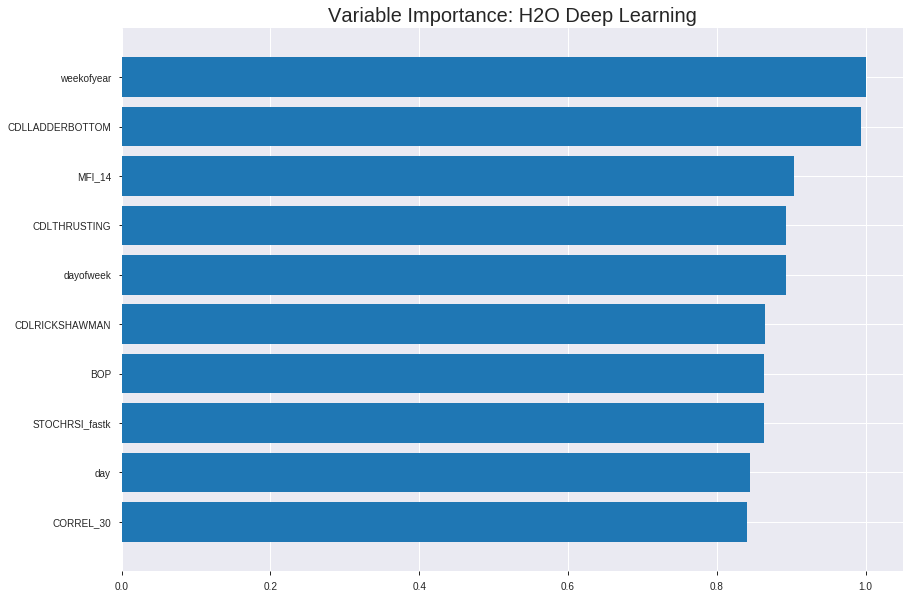

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190826_204157


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2716428441060411
RMSE: 0.5211936723580219
LogLoss: 0.7556418963008428
Mean Per-Class Error: 0.3652061783421636
AUC: 0.6727587679592903
pr_auc: 0.6469733010808578
Gini: 0.3455175359185807
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19822316572499102: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      336  463   0.5795   (463.0/799.0)
1      140  619   0.1845   (140.0/759.0)
Total  476  1082  0.387    (603.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.198223     0.672461  287
max f2                       0.0765141    0.827315  383
max f0point5                 0.2699       0.625847  221
max accuracy                 0.2699       0.63543   221
max precision                0.600953     0.842105  29
max recall                   0.00495803   1         397
max specificity              0.986799     0.998748  0
max absolute_mcc             0.26903      0.26993   222
max min_per_class_accuracy   0.261725     0.627034  228
max mean_per_class_accuracy  0.26903      0.634794  222

Gains/Lift Table: Avg response rate: 48.72 %, avg score: 28.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.652671           1.53953   1.53953            0.75             0.725048   0.75                        0.725048            0.0158103       0.0158103                  53.9526   53.9526
    2        0.0205392                   0.609534           1.79611   1.66782            0.875            0.628907   0.8125                      0.676977            0.0184453       0.0342556                  79.6113   66.7819
    3        0.0301669                   0.584209           1.64216   1.65963            0.8              0.597158   0.808511                    0.651503            0.0158103       0.0500659                  64.2161   65.9631
    4        0.0404365                   0.549348           1.66782   1.66171            0.8125           0.563842   0.809524                    0.62924             0.0171278       0.0671937                  66.7819   66.171
    5        0.0500642                   0.531767           1.36847   1.60532            0.666667         0.541882   0.782051                    0.61244             0.0131752       0.0803689                  36.8467   60.5317
    6        0.100128                    0.472224           1.52637   1.56584            0.74359          0.498693   0.762821                    0.555567            0.0764163       0.156785                   52.6367   56.5842
    7        0.150193                    0.413718           1.2632    1.46496            0.615385         0.443655   0.713675                    0.518263            0.0632411       0.220026                   26.3201   46.4962
    8        0.200257                    0.379922           1.39478   1.44742            0.679487         0.396869   0.705128                    0.487914            0.0698287       0.289855                   39.4784   44.7417
    9        0.300385                    0.335237           1.19741   1.36408            0.583333         0.355783   0.66453                     0.44387             0.119895        0.40975                    19.7409   36.4081
    10       0.399872                    0.293579           1.13892   1.30806            0.554839         0.31398    0.637239                    0.411554            0.113307        0.523057                   13.8918   30.8061
    11       0.5                         0.260009           1.05267   1.25692            0.512821         0.276371   0.612323                    0.384483            0.105402        0.628458                   5.26671   25.6917
    12       0.600128                    0.228497           0.960559  1.20747            0.467949         0.244442   0.588235                    0.361118            0.0961792       0.724638                   -3.94412  20.7471
    13       0.699615                    0.195517           0.940269  1.16947            0.458065         0.211845   0.569725                    0.339891            0.0935441       0.818182                   -5.97305  16.9475
    14       0.799743                    0.162781           0.6316    1.10213            0.307692         0.178666   0.536918                    0.319705            0.0632411       0.881423                   -36.84    10.2132
    15       0.899872                    0.127493           0.684234  1.05563            0.333333         0.1463     0.514265                    0.300411            0.0685112       0.949934                   -31.5766  5.56329
    16       1                           0.000481919        0.500017  1                  0.24359          0.0970954  0.487163                    



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3399069668956525
RMSE: 0.5830154087977886
LogLoss: 0.943939411480659
Mean Per-Class Error: 0.4887578998541565
AUC: 0.484058499432831
pr_auc: 0.5423969373527818
Gini: -0.03188300113433795
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.01946237685279082: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    242  0        (0.0/242.0)
Total  0    446  0.4574   (204.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0194624    0.703488   399
max f2                       0.0194624    0.855728   399
max f0point5                 0.0194624    0.597236   399
max accuracy                 0.0194624    0.542601   399
max precision                0.87625      1          0
max recall                   0.0194624    1          399
max specificity              0.87625      1          0
max absolute_mcc             0.685197     0.0977627  4
max min_per_class_accuracy   0.259138     0.491736   207
max mean_per_class_accuracy  0.63246      0.511242   11

Gains/Lift Table: Avg response rate: 54.26 %, avg score: 29.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.682572           1.84298   1.84298            1                0.743575   1                           0.743575            0.0206612       0.0206612                  84.2975   84.2975
    2        0.0201794                   0.667396           0.460744  1.22865            0.25             0.672133   0.666667                    0.711823            0.00413223      0.0247934                  -53.9256  22.865
    3        0.0313901                   0.626377           1.10579   1.18477            0.6              0.641229   0.642857                    0.686611            0.0123967       0.0371901                  10.5785   18.477
    4        0.0403587                   0.604838           0.921488  1.12626            0.5              0.612835   0.611111                    0.670216            0.00826446      0.0454545                  -7.85124  12.6263
    5        0.0515695                   0.583346           1.10579   1.12181            0.6              0.593506   0.608696                    0.65354             0.0123967       0.0578512                  10.5785   12.1811
    6        0.100897                    0.511509           0.837716  0.98292            0.454545         0.555292   0.533333                    0.605508            0.0413223       0.0991736                  -16.2284  -1.70799
    7        0.150224                    0.476053           1.00526   0.990255           0.545455         0.491573   0.537313                    0.568096            0.0495868       0.14876                    0.52592   -0.974467
    8        0.201794                    0.427422           0.881423  0.962443           0.478261         0.449034   0.522222                    0.537669            0.0454545       0.194215                   -11.8577  -3.75574
    9        0.300448                    0.365309           0.963373  0.962748           0.522727         0.394638   0.522388                    0.490704            0.0950413       0.289256                   -3.66266  -3.72518
    10       0.401345                    0.311378           1.02388   0.978115           0.555556         0.339166   0.530726                    0.452608            0.103306        0.392562                   2.38751   -2.18847
    11       0.5                         0.257085           1.00526   0.983471           0.545455         0.280984   0.533632                    0.418745            0.0991736       0.491736                   0.52592   -1.65289
    12       0.600897                    0.216514           1.06483   0.997132           0.577778         0.237781   0.541045                    0.388359            0.107438        0.599174                   6.48301   -0.286789
    13       0.699552                    0.18131            0.963373  0.992371           0.522727         0.196533   0.538462                    0.361307            0.0950413       0.694215                   -3.66266  -0.762873
    14       0.800448                    0.145873           0.90101   0.980855           0.488889         0.163894   0.532213                    0.336423            0.0909091       0.785124                   -9.89899  -1.91448
    15       0.899103                    0.109483           1.08903   0.992725           0.590909         0.127768   0.538653                    0.313528            0.107438        0.892562                   8.90308   -0.72752
    16       1                           0.0194624          1.06483   1                  0.577778         0.0814592  0.542601        


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 20:41:57  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 20:41:57  0.098 sec   43277 obs/sec     1         1             1558       0.563155         0.928584            -0.26941       0.513742        0.493172           0.769763         0.512837                         0.601373           1.05978               -0.457178        0.474872          0.548144             1.84298            0.455157
    2019-08-26 20:41:58  0.405 sec   50915 obs/sec     10        10            15580      0.521194         0.755642            -0.0872881     0.672759        0.646973           1.53953          0.387035                         0.583015           0.943939              -0.36957         0.484058          0.542397             1.84298            0.457399

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
weekofyear           1.0                    1.0                  0.028468122848483393
CDLLADDERBOTTOM      0.9940043687820435     0.9940043687820435   0.028297438482416403
MFI_14               0.9031960368156433     0.9031960368156433   0.025712295732331063
CDLTHRUSTING         0.8934568166732788     0.8934568166732788   0.025435038416869806
dayofweek            0.8929852247238159     0.8929852247238159   0.02542161307931814
---                  ---                    ---                  ---
CDLMORNINGSTAR       0.5383915305137634     0.5383915305137634   0.015326996231248812
STOCHRSI_fastd       0.5228956937789917     0.5228956937789917   0.01488585884744329
CDLRISEFALL3METHODS  0.5055877566337585     0.5055877566337585   0.014393134366538963
HT_TRENDMODE         0.5003343820571899     0.5003343820571899   0.014243580653724108
aroondown_30         0.40988248586654663    0.40988248586654663  0.011668584961090607


See the whole table with table.as_data_frame()


('accuracy', 0.5560538116591929)

('F1', 0.6804733727810652)

('auc', 0.5385668276972625)

('logloss', 0.7802051082454448)

('mean_per_class_error', 0.43804347826086953)

('rmse', 0.5249647559767399)

('mse', 0.275587995017718)

deeplearning prediction progress: |███████████████████████████████████████| 100%


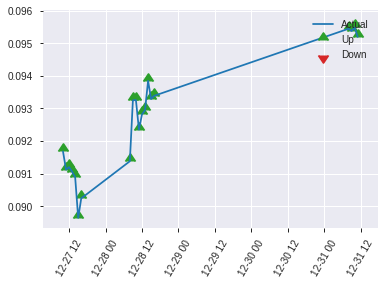


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.275587995017718
RMSE: 0.5249647559767399
LogLoss: 0.7802051082454448
Mean Per-Class Error: 0.43804347826086953
AUC: 0.5385668276972625
pr_auc: 0.573223123597064
Gini: 0.07713365539452499
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0026071963248283174: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    108  1        (108.0/108.0)
1      0    115  0        (0.0/115.0)
Total  0    223  0.4843   (108.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0026072    0.680473  222
max f2                       0.0026072    0.841874  222
max f0point5                 0.191847     0.57629   198
max accuracy                 0.553643     0.556054  69
max precision                0.845307     1         0
max recall                   0.0026072    1         222
max specificity              0.845307     1         0
max absolute_mcc             0.804488     0.146764  4
max min_per_class_accuracy   0.452812     0.518519  111
max mean_per_class_accuracy  0.553643     0.561957  69

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 44.01 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.823618           1.93913   1.93913            1                0.832471  1                           0.832471            0.026087        0.026087                   93.913    93.913
    2        0.0224215                   0.78788            1.93913   1.93913            1                0.809837  1                           0.823417            0.0173913       0.0434783                  93.913    93.913
    3        0.0313901                   0.759223           0         1.38509            0                0.764963  0.714286                    0.806716            0               0.0434783                  -100      38.5093
    4        0.0403587                   0.743693           0.969565  1.29275            0.5              0.756629  0.666667                    0.795586            0.00869565      0.0521739                  -3.04348  29.2754
    5        0.0538117                   0.718494           1.93913   1.45435            1                0.729714  0.75                        0.779118            0.026087        0.0782609                  93.913    45.4348
    6        0.103139                    0.651076           1.23399   1.34896            0.636364         0.678439  0.695652                    0.730967            0.0608696       0.13913                    23.3992   34.896
    7        0.152466                    0.622654           0.705138  1.14066            0.363636         0.637328  0.588235                    0.700672            0.0347826       0.173913                   -29.4862  14.0665
    8        0.201794                    0.600911           1.23399   1.16348            0.636364         0.610805  0.6                         0.678704            0.0608696       0.234783                   23.3992   16.3478
    9        0.300448                    0.557473           1.14585   1.15769            0.590909         0.579119  0.597015                    0.646005            0.113043        0.347826                   14.585    15.769
    10       0.399103                    0.514084           0.793281  1.06761            0.409091         0.53583   0.550562                    0.618771            0.0782609       0.426087                   -20.6719  6.76111
    11       0.502242                    0.452812           0.92741   1.03882            0.478261         0.484248  0.535714                    0.591145            0.0956522       0.521739                   -7.25898  3.88199
    12       0.600897                    0.389167           0.705138  0.984036           0.363636         0.420293  0.507463                    0.563095            0.0695652       0.591304                   -29.4862  -1.59637
    13       0.699552                    0.341162           1.05771   0.994426           0.545455         0.365234  0.512821                    0.535191            0.104348        0.695652                   5.77075   -0.557414
    14       0.798206                    0.275174           1.14585   1.01314            0.590909         0.311568  0.522472                    0.507553            0.113043        0.808696                   14.585    1.31412
    15       0.896861                    0.186882           1.05771   1.01804            0.545455         0.231613  0.525                       0.477199            0.104348        0.913043                   5.77075   1.80435
    16       1                           0.0026072          0.8431    1                  0.434783         0.117479  0.515695                    0.440098          

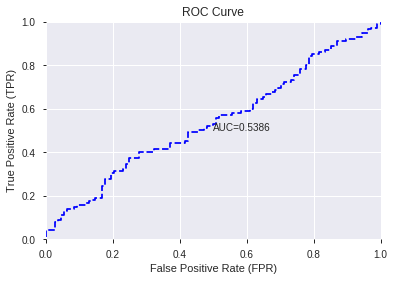

This function is available for GLM models only


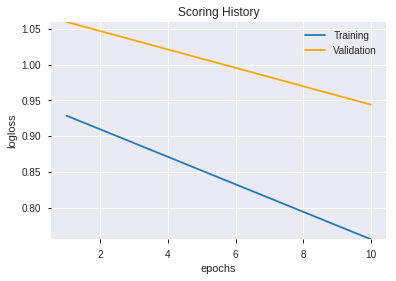

--2019-08-26 20:48:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.171.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.171.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190826_204157',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190826_204157',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_afb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_10_sid_afb1'

['weekofyear',
 'CDLLADDERBOTTOM',
 'MFI_14',
 'CDLTHRUSTING',
 'dayofweek',
 'CDLRICKSHAWMAN',
 'BOP',
 'STOCHRSI_fastk',
 'day',
 'CORREL_30',
 'aroondown_14',
 'aroondown_24',
 'aroonup_24',
 'CDLDOJI',
 'ADX_20',
 'AROONOSC_24',
 'dayofyear',
 'weekday',
 'BETA_30',
 'hour',
 'aroonup_8',
 'aroonup_20',
 'CDLSPINNINGTOP',
 'MFI_8',
 'aroonup_12',
 'days_in_month',
 'STOCH_slowd',
 'CORREL_8',
 'BETA_8',
 'MFI_12',
 'aroonup_30',
 'CDLEVENINGDOJISTAR',
 'CDLLONGLEGGEDDOJI',
 'weekday_name',
 'SAREXT',
 'aroondown_12',
 'HT_DCPERIOD',
 'aroondown_20',
 'CDLHIKKAKE',
 'CDLGAPSIDESIDEWHITE',
 'CDLMORNINGDOJISTAR',
 'ADX_24',
 'CDLTASUKIGAP',
 'aroondown_8',
 'CDL3BLACKCROWS',
 'CDLMORNINGSTAR',
 'STOCHRSI_fastd',
 'CDLRISEFALL3METHODS',
 'HT_TRENDMODE',
 'aroondown_30']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190826_204904_model_1  0.457568  0.71403                   0.5  0.50973  0.259824

variable  relative_importance  scaled_importance  percentage
0            CDLHIKKAKE             0.085124           1.000000    0.064353
1                   BOP             0.073851           0.867564    0.055830
2        CDLMORNINGSTAR             0.060085           0.705850    0.045424
3                  hour             0.049802           0.585050    0.037650
4        CDLSPINNINGTOP             0.045224           0.531276    0.034189
5          HT_TRENDMODE             0.042537           0.499707    0.032158
6                 MFI_8             0.040480           0.475541    0.030602
7            weekofyear             0.036790           0.432194    0.027813
8                ADX_24             0.036367           0.427225    0.027493
9             dayofyear             0.036320           0.426676    0.027458
10             CORREL_8             0.035884           0.421554    0.027128
11           aroonup_20             0.033798           0.397049    0.025551
12               MFI_14             0.033666           0.395489    0.025451
13              BETA_30             0.031655           0.371873    0.023931
14           aroonup_30             0.028937           0.339942    0.021876
15              CDLDOJI             0.028761           0.337872    0.021743
16    CDLLONGLEGGEDDOJI             0.028749           0.337725    0.021734
17               MFI_12             0.026289           0.308829    0.019874
18            dayofweek             0.026207           0.307873    0.019813
19              weekday             0.026207           0.307868    0.019812
20       CDL3BLACKCROWS             0.025640           0.301210    0.019384
21  CDLGAPSIDESIDEWHITE             0.025560           0.300265    0.019323
22      CDLLADDERBOTTOM             0.025350           0.297799    0.019164
23         aroondown_30             0.025290           0.297092    0.019119
24           aroonup_12             0.025119           0.295084    0.018990
25   CDLMORNINGDOJISTAR             0.024350           0.286052    0.018408
26         CDLTASUKIGAP             0.023978           0.281688    0.018127
27         CDLTHRUSTING             0.022957           0.269691    0.017355
28         weekday_name             0.022430           0.263502    0.016957
29  CDLRISEFALL3METHODS             0.022116           0.259808    0.016719
30          HT_DCPERIOD             0.021983           0.258244    0.016619
31               SAREXT             0.021291           0.250116    0.016096
32       STOCHRSI_fastk             0.020331           0.238840    0.015370
33               ADX_20             0.020255           0.237952    0.015313
34          AROONOSC_24             0.019733           0.231816    0.014918
35         aroondown_12             0.019660           0.230961    0.014863
36       CDLRICKSHAWMAN             0.019110           0.224496    0.014447
37        days_in_month             0.017793           0.209025    0.013451
38         aroondown_24             0.017536           0.206007    0.013257
39           aroonup_24             0.016903           0.198564    0.012778
40   CDLEVENINGDOJISTAR             0.016846           0.197894    0.012735
41                  day             0.014412           0.169303    0.010895
42            aroonup_8             0.013128           0.154225    0.009925
43         aroondown_14             0.011104           0.130447    0.008395
44               BETA_8             0.006703           0.078744    0.005067
45         aroondown_20             0.006562           0.077086    0.004961
46          aroondown_8             0.004741           0.055690    0.003584
47            CORREL_30             0.002714           0.031884    0.002052
48       STOCHRSI_fastd             0.001681           0.019742    0.001270
49          STOCH_slowd             0.000759           0.008914    0.000574

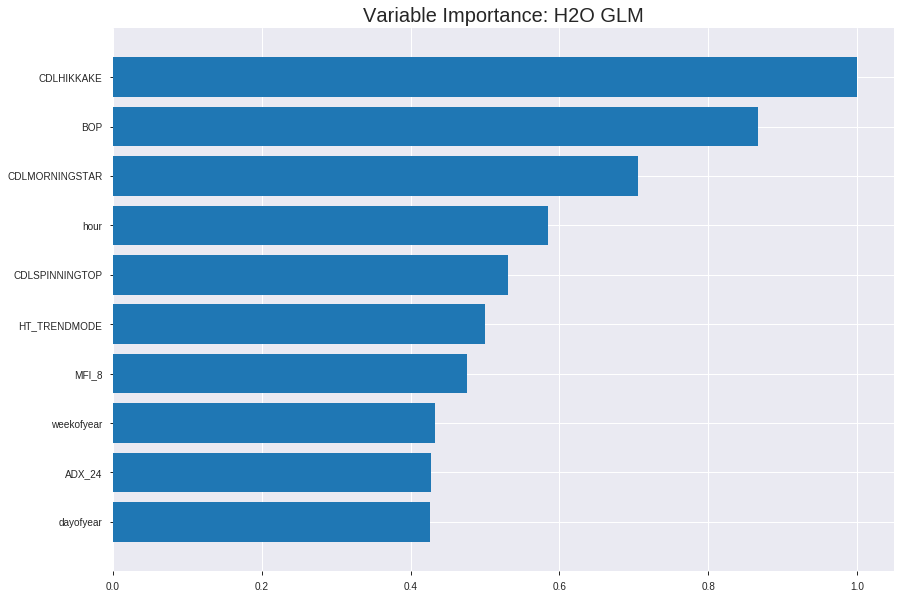

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_204904_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2410775170957837
RMSE: 0.49099645324155217
LogLoss: 0.6747601072687804
Null degrees of freedom: 1557
Residual degrees of freedom: 1507
Null deviance: 2158.8195441369685
Residual deviance: 2102.55249424952
AIC: 2204.55249424952
AUC: 0.611552484083365
pr_auc: 0.5883961840851437
Gini: 0.2231049681667301
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40657511350195036: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      69   730   0.9136   (730.0/799.0)
1      23   736   0.0303   (23.0/759.0)
Total  92   1466  0.4833   (753.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.406575     0.661573  344
max f2                       0.345998     0.829327  383
max f0point5                 0.471924     0.572951  230
max accuracy                 0.500235     0.581515  171
max precision                0.784616     1         0
max recall                   0.345998     1         383
max specificity              0.784616     1         0
max absolute_mcc             0.439019     0.162129  296
max min_per_class_accuracy   0.486021     0.570487  203
max mean_per_class_accuracy  0.500235     0.578897  171

Gains/Lift Table: Avg response rate: 48.72 %, avg score: 48.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.0102696                   0.625401           1.28294   1.28294            0.625            0.662428  0.625                       0.662428            0.0131752       0.0131752                  28.2938     28.2938
    2        0.0205392                   0.605287           1.53953   1.41123            0.75             0.614611  0.6875                      0.63852             0.0158103       0.0289855                  53.9526     41.1232
    3        0.0301669                   0.596949           1.64216   1.48493            0.8              0.600779  0.723404                    0.626475            0.0158103       0.0447958                  64.2161     48.4933
    4        0.0404365                   0.587035           1.41123   1.46621            0.6875           0.591285  0.714286                    0.617538            0.0144928       0.0592885                  41.1232     46.6215
    5        0.0500642                   0.579191           1.36847   1.44742            0.666667         0.582509  0.705128                    0.610801            0.0131752       0.0724638                  36.8467     44.7417
    6        0.100128                    0.558174           1.36847   1.40794            0.666667         0.56785   0.685897                    0.589326            0.0685112       0.140975                   36.8467     40.7942
    7        0.150193                    0.542285           1.2632    1.3597             0.615385         0.550407  0.662393                    0.576353            0.0632411       0.204216                   26.3201     35.9695
    8        0.200257                    0.531624           1.18425   1.31583            0.576923         0.537405  0.641026                    0.566616            0.0592885       0.263505                   18.4251     31.5834
    9        0.300385                    0.514412           1.06583   1.2325             0.519231         0.522891  0.600427                    0.552041            0.106719        0.370224                   6.58255     23.2498
    10       0.399872                    0.499607           1.08595   1.19604            0.529032         0.507274  0.582665                    0.540903            0.108037        0.478261                   8.5945      19.6036
    11       0.5                         0.485591           0.934242  1.14361            0.455128         0.492992  0.557125                    0.531308            0.0935441       0.571805                   -6.57579    14.361
    12       0.600128                    0.471799           1.06583   1.13063            0.519231         0.47879   0.550802                    0.522546            0.106719        0.678524                   6.58255     13.0632
    13       0.699615                    0.459026           0.847567  1.09038            0.412903         0.465952  0.531193                    0.514498            0.0843215       0.762846                   -15.2433    9.03797
    14       0.799743                    0.444293           1.00003   1.07907            0.487179         0.451911  0.525682                    0.506662            0.100132        0.862978                   0.00337826  7.90683
    15       0.899872                    0.425198           0.736867  1.04099            0.358974         0.435073  0.507133                    0.498697            0.0737813       0.936759                   -26.3133    4.09917
    16       1                           0.141706           0.6316    1                  0.307692         0.38351   0.487163    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24733602298374088
RMSE: 0.49732888814520004
LogLoss: 0.687688413162503
Null degrees of freedom: 445
Residual degrees of freedom: 395
Null deviance: 620.533011844054
Residual deviance: 613.4180645409525
AIC: 715.4180645409525
AUC: 0.5457077459082806
pr_auc: 0.5808284712428452
Gini: 0.09141549181656128
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37973993241492265: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    202  0.9902   (202.0/204.0)
1      0    242  0        (0.0/242.0)
Total  2    444  0.4529   (202.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37974      0.705539  397
max f2                       0.37974      0.856941  397
max f0point5                 0.47339      0.607948  315
max accuracy                 0.47339      0.567265  315
max precision                0.717397     1         0
max recall                   0.37974      1         397
max specificity              0.717397     1         0
max absolute_mcc             0.47339      0.104519  315
max min_per_class_accuracy   0.512959     0.529412  202
max mean_per_class_accuracy  0.508714     0.546224  215

Gains/Lift Table: Avg response rate: 54.26 %, avg score: 51.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.632186           1.10579   1.10579            0.6              0.660678  0.6                         0.660678            0.0123967       0.0123967                  10.5785   10.5785
    2        0.0201794                   0.625149           1.84298   1.43343            1                0.629695  0.777778                    0.646907            0.0165289       0.0289256                  84.2975   43.3425
    3        0.0313901                   0.613109           1.10579   1.31641            0.6              0.620887  0.714286                    0.637614            0.0123967       0.0413223                  10.5785   31.6411
    4        0.0403587                   0.601092           0.921488  1.22865            0.5              0.60738   0.666667                    0.630896            0.00826446      0.0495868                  -7.85124  22.865
    5        0.0515695                   0.59763            1.47438   1.28207            0.8              0.599126  0.695652                    0.623989            0.0165289       0.0661157                  47.438    28.207
    6        0.100897                    0.579131           0.753944  1.02388            0.409091         0.588107  0.555556                    0.606447            0.0371901       0.103306                   -24.6056  2.38751
    7        0.150224                    0.564806           1.50789   1.1828             0.818182         0.570719  0.641791                    0.594715            0.0743802       0.177686                   50.7889   18.2805
    8        0.201794                    0.55479            0.801294  1.08531            0.434783         0.559279  0.588889                    0.585659            0.0413223       0.219008                   -19.8706  8.53076
    9        0.300448                    0.539395           0.963373  1.04527            0.522727         0.546489  0.567164                    0.572798            0.0950413       0.31405                    -3.66266  4.52695
    10       0.401345                    0.527842           1.10579   1.06048            0.6              0.533708  0.575419                    0.562971            0.11157         0.42562                    10.5785   6.04829
    11       0.5                         0.513754           1.00526   1.04959            0.545455         0.521144  0.569507                    0.554718            0.0991736       0.524793                   0.52592   4.95868
    12       0.600897                    0.500794           1.10579   1.05902            0.6              0.506881  0.574627                    0.546686            0.11157         0.636364                   10.5785   5.90231
    13       0.699552                    0.488618           0.963373  1.04553            0.522727         0.494839  0.567308                    0.539374            0.0950413       0.731405                   -3.66266  4.5534
    14       0.800448                    0.474203           1.02388   1.0428             0.555556         0.481064  0.565826                    0.532024            0.103306        0.834711                   2.38751   4.28039
    15       0.899103                    0.451525           0.712059  1.00651            0.386364         0.465388  0.546135                    0.524712            0.0702479       0.904959                   -28.7941  0.651264
    16       1                           0.272911           0.941965  1                  0.511111         0.416833  0.542601                    0.513828           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 20:49:05  0.000 sec   2            4         51            1.37915           1.38686
    2019-08-26 20:49:05  0.079 sec   4            2.5       51            1.376             1.38482
    2019-08-26 20:49:05  0.172 sec   6            1.5       51            1.37183           1.38232
    2019-08-26 20:49:05  0.263 sec   8            0.95      51            1.3667            1.37963
    2019-08-26 20:49:05  0.294 sec   10           0.59      51            1.36092           1.37723
    2019-08-26 20:49:05  0.326 sec   12           0.37      51            1.355             1.3757
    2019-08-26 20:49:05  0.356 sec   14           0.23      51            1.34952           1.37538
    2019-08-26 20:49:05  0.376 sec   16           0.14      51            1.3449            1.37634
    2019-08-26 20:49:05  0.397 sec   18           0.088     51            1.34135           1.37828
    2019-08-26 20:49:05  0.425 sec   20           0.055     51            1.3388            1.38073
    2019-08-26 20:49:05  0.451 sec   22           0.034     51            1.33707           1.38328
    2019-08-26 20:49:05  0.480 sec   24           0.021     51            1.3359            1.3857

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.515695067264574)

('F1', 0.6804733727810652)

('auc', 0.4575684380032206)

('logloss', 0.714029599057052)

('mean_per_class_error', 0.4886876006441223)

('rmse', 0.5097295126705169)

('mse', 0.25982417608732267)

glm prediction progress: |████████████████████████████████████████████████| 100%


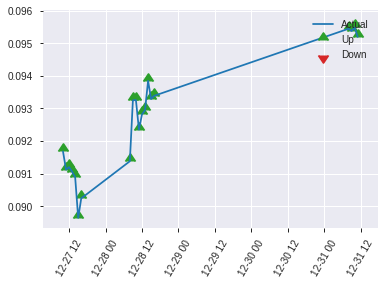


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25982417608732267
RMSE: 0.5097295126705169
LogLoss: 0.714029599057052
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 309.6501959015793
Residual deviance: 318.4572011794452
AIC: 420.4572011794452
AUC: 0.4575684380032206
pr_auc: 0.4834471318010396
Gini: -0.08486312399355878
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20902927398660034: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    108  1        (108.0/108.0)
1      0    115  0        (0.0/115.0)
Total  0    223  0.4843   (108.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.209029     0.680473  222
max f2                       0.209029     0.841874  222
max f0point5                 0.209029     0.571003  222
max accuracy                 0.440269     0.515695  220
max precision                0.574023     0.531646  78
max recall                   0.209029     1         222
max specificity              0.745725     0.990741  0
max absolute_mcc             0.535642     0.132394  137
max min_per_class_accuracy   0.556625     0.452174  109
max mean_per_class_accuracy  0.574023     0.511312  78

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 55.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.67348            0.646377  0.646377           0.333333         0.710377  0.333333                    0.710377            0.00869565      0.00869565                 -35.3623  -35.3623
    2        0.0224215                   0.661768           0         0.387826           0                0.662196  0.2                         0.691105            0               0.00869565                 -100      -61.2174
    3        0.0313901                   0.653141           0.969565  0.554037           0.5              0.657303  0.285714                    0.681447            0.00869565      0.0173913                  -3.04348  -44.5963
    4        0.0403587                   0.649843           1.93913   0.861836           1                0.652989  0.444444                    0.675123            0.0173913       0.0347826                  93.913    -13.8164
    5        0.0538117                   0.647585           1.29275   0.969565           0.666667         0.64855   0.5                         0.66848             0.0173913       0.0521739                  29.2754   -3.04348
    6        0.103139                    0.622129           0.705138  0.8431             0.363636         0.632299  0.434783                    0.651176            0.0347826       0.0869565                  -29.4862  -15.69
    7        0.152466                    0.601692           1.05771   0.912532           0.545455         0.61162   0.470588                    0.638378            0.0521739       0.13913                    5.77075   -8.7468
    8        0.201794                    0.594392           0.881423  0.904928           0.454545         0.598021  0.466667                    0.628513            0.0434783       0.182609                   -11.8577  -9.50725
    9        0.300448                    0.579317           1.23399   1.01298            0.636364         0.585303  0.522388                    0.614325            0.121739        0.304348                   23.3992   1.29786
    10       0.399103                    0.569825           0.881423  0.980459           0.454545         0.574443  0.505618                    0.604467            0.0869565       0.391304                   -11.8577  -1.95408
    11       0.502242                    0.555821           0.59017   0.900311           0.304348         0.562172  0.464286                    0.595781            0.0608696       0.452174                   -40.983   -9.96894
    12       0.600897                    0.537837           0.969565  0.911681           0.5              0.546454  0.470149                    0.587683            0.0956522       0.547826                   -3.04348  -8.83193
    13       0.699552                    0.527846           1.14585   0.944705           0.590909         0.532009  0.487179                    0.579831            0.113043        0.66087                    14.585    -5.52954
    14       0.798206                    0.508352           1.32213   0.991353           0.681818         0.519412  0.511236                    0.572364            0.130435        0.791304                   32.2134   -0.86468
    15       0.896861                    0.492335           0.881423  0.979261           0.454545         0.500498  0.505                       0.564458            0.0869565       0.878261                   -11.8577  -2.07391
    16       1                           0.209029           1.18034   1                  0.608696         0.454371  0.515695                    0.5531

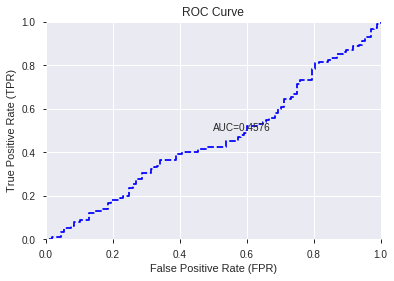

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


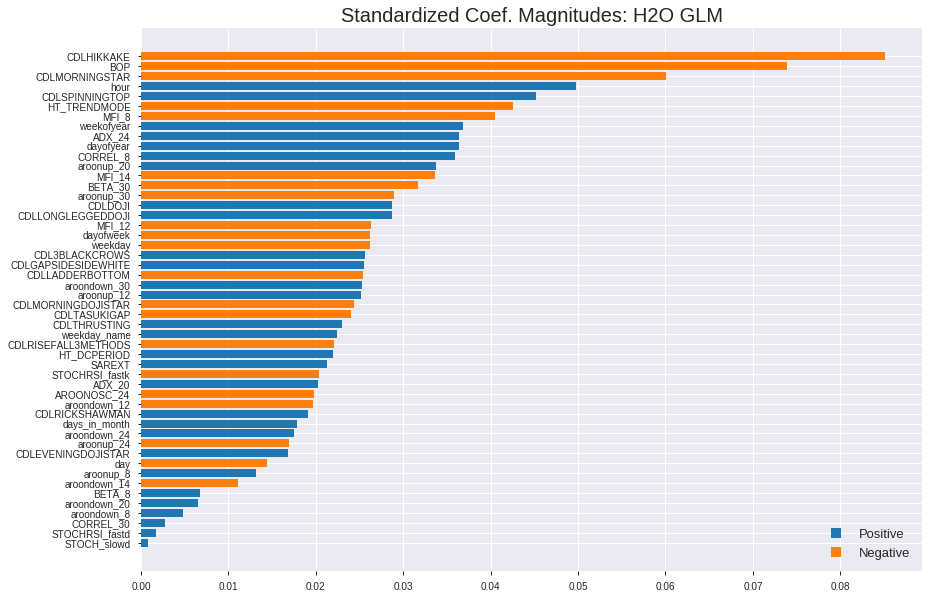

'log_likelihood'
--2019-08-26 20:49:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.106.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.106.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_204904_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_204904_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_afb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['CDLHIKKAKE',
 'BOP',
 'CDLMORNINGSTAR',
 'hour',
 'CDLSPINNINGTOP',
 'HT_TRENDMODE',
 'MFI_8',
 'weekofyear',
 'ADX_24',
 'dayofyear',
 'CORREL_8',
 'aroonup_20',
 'MFI_14',
 'BETA_30',
 'aroonup_30',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'MFI_12',
 'dayofweek',
 'weekday',
 'CDL3BLACKCROWS',
 'CDLGAPSIDESIDEWHITE',
 'CDLLADDERBOTTOM',
 'aroondown_30',
 'aroonup_12',
 'CDLMORNINGDOJISTAR',
 'CDLTASUKIGAP',
 'CDLTHRUSTING',
 'weekday_name',
 'CDLRISEFALL3METHODS',
 'HT_DCPERIOD',
 'SAREXT',
 'STOCHRSI_fastk',
 'ADX_20',
 'AROONOSC_24',
 'aroondown_12',
 'CDLRICKSHAWMAN',
 'days_in_month',
 'aroondown_24',
 'aroonup_24',
 'CDLEVENINGDOJISTAR',
 'day',
 'aroonup_8',
 'aroondown_14',
 'BETA_8',
 'aroondown_20',
 'aroondown_8',
 'CORREL_30',
 'STOCHRSI_fastd',
 'STOCH_slowd']

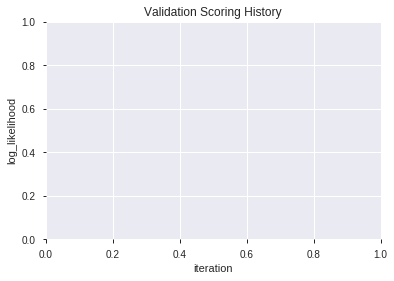

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_204916_model_7  0.538808  0.698440              0.485829  0.502461  0.252467
1               XGBoost_1_AutoML_20190826_204916  0.522061  0.708683              0.500000  0.507158  0.257210
2  XGBoost_grid_1_AutoML_20190826_204916_model_6  0.505072  0.711958              0.485829  0.508811  0.258888
3  XGBoost_grid_1_AutoML_20190826_204916_model_3  0.501127  0.712016              0.500000  0.508969  0.259050
4               XGBoost_3_AutoML_20190826_204916  0.489291  0.712200              0.485548  0.509142  0.259226
5  XGBoost_grid_1_AutoML_20190826_204916_model_1  0.487721  0.720300              0.500000  0.512705  0.262866
6  XGBoost_grid_1_AutoML_20190826_204916_model_5  0.480515  0.753154              0.490459  0.526469  0.277170
7  XGBoost_grid_1_AutoML_20190826_204916_model_4  0.475000  0.711341              0.500000  0.508733  0.258809
8  XGBoost_grid_1_AutoML_20190826_204916_model_2  0.460628  0.711183              0.485548  0.508781  0.258858
9               XGBoost_2_AutoML_20190826_204916  0.459823  0.722670              0.490177  0.513791  0.263981

variable  relative_importance  scaled_importance  percentage
0                 BOP           576.892090           1.000000    0.080329
1              BETA_8           430.780853           0.746727    0.059984
2             BETA_30           415.217346           0.719749    0.057817
3              ADX_20           342.595306           0.593864    0.047705
4              MFI_12           311.733673           0.540367    0.043407
5         STOCH_slowd           311.210388           0.539460    0.043334
6      STOCHRSI_fastd           303.519440           0.526129    0.042264
7      STOCHRSI_fastk           302.957367           0.525154    0.042185
8              MFI_14           295.885040           0.512895    0.041201
9                 day           277.340454           0.480749    0.038618
10             SAREXT           266.040527           0.461162    0.037045
11        HT_DCPERIOD           261.321869           0.452982    0.036388
12              MFI_8           255.018585           0.442056    0.035510
13          dayofyear           251.928452           0.436699    0.035080
14             ADX_24           229.781219           0.398309    0.031996
15        AROONOSC_24           225.378525           0.390677    0.031383
16       aroondown_30           200.213196           0.347055    0.027879
17         aroonup_30           195.578445           0.339021    0.027233
18               hour           166.878799           0.289272    0.023237
19         aroonup_20           160.927582           0.278956    0.022408
20       aroondown_12           130.141418           0.225591    0.018122
21         aroonup_12           122.402557           0.212176    0.017044
22          aroonup_8           116.128532           0.201300    0.016170
23          CORREL_30           113.265228           0.196337    0.015772
24       aroondown_24           112.864952           0.195643    0.015716
25       aroondown_20           110.654884           0.191812    0.015408
26        aroondown_8            95.105194           0.164858    0.013243
27         aroonup_24            91.195099           0.158080    0.012698
28       weekday_name            86.155838           0.149345    0.011997
29       aroondown_14            79.959785           0.138604    0.011134
30          dayofweek            72.875328           0.126324    0.010148
31         weekofyear            55.725883           0.096597    0.007760
32       HT_TRENDMODE            49.918655           0.086530    0.006951
33            weekday            39.563274           0.068580    0.005509
34         CDLHIKKAKE            38.010311           0.065888    0.005293
35      days_in_month            37.550377           0.065091    0.005229
36     CDLSPINNINGTOP            22.272532           0.038608    0.003101
37            CDLDOJI            13.347084           0.023136    0.001859
38     CDLRICKSHAWMAN             9.851219           0.017076    0.001372
39  CDLLONGLEGGEDDOJI             3.398250           0.005891    0.000473

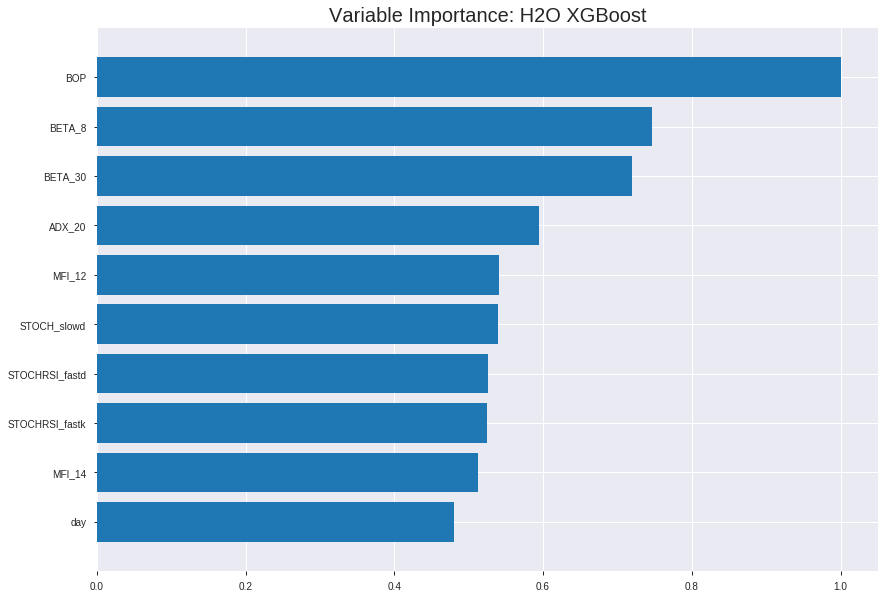

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_204916_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15316270562625875
RMSE: 0.3913600715789217
LogLoss: 0.49063204504879343
Mean Per-Class Error: 0.11096545253371726
AUC: 0.9573800254270407
pr_auc: 0.9554260157672281
Gini: 0.9147600508540814
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4955502599477768: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      716  83   0.1039   (83.0/799.0)
1      91   668  0.1199   (91.0/759.0)
Total  807  751  0.1117   (174.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.49555      0.884768  196
max f2                       0.390753     0.919018  267
max f0point5                 0.543948     0.906103  161
max accuracy                 0.502337     0.889602  191
max precision                0.822843     1         0
max recall                   0.331107     1         314
max specificity              0.822843     1         0
max absolute_mcc             0.502337     0.77942   191
max min_per_class_accuracy   0.491243     0.88274   199
max mean_per_class_accuracy  0.502337     0.889035  191

Gains/Lift Table: Avg response rate: 48.72 %, avg score: 48.74 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.76024            2.0527     2.0527             1                0.781121  1                           0.781121            0.0210804       0.0210804                  105.27    105.27
    2        0.0205392                   0.748603           2.0527     2.0527             1                0.753916  1                           0.767518            0.0210804       0.0421607                  105.27    105.27
    3        0.0301669                   0.736506           2.0527     2.0527             1                0.741757  1                           0.759297            0.0197628       0.0619236                  105.27    105.27
    4        0.0404365                   0.729229           2.0527     2.0527             1                0.732118  1                           0.752394            0.0210804       0.083004                   105.27    105.27
    5        0.0500642                   0.72153            2.0527     2.0527             1                0.725416  1                           0.747206            0.0197628       0.102767                   105.27    105.27
    6        0.100128                    0.690974           2.0527     2.0527             1                0.705168  1                           0.726187            0.102767        0.205534                   105.27    105.27
    7        0.150193                    0.666713           2.02638    2.04393            0.987179         0.677807  0.995726                    0.71006             0.101449        0.306983                   102.638   104.393
    8        0.200257                    0.643392           2.00007    2.03296            0.974359         0.654146  0.990385                    0.696082            0.100132        0.407115                   100.007   103.296
    9        0.300385                    0.592713           1.96059    2.00884            0.955128         0.620047  0.978632                    0.670737            0.196311        0.603426                   96.0593   100.884
    10       0.399872                    0.538125           1.73486    1.94068            0.845161         0.568031  0.945425                    0.645184            0.172596        0.776021                   73.4863   94.0676
    11       0.5                         0.483755           1.17109    1.78656            0.570513         0.511837  0.870347                    0.618481            0.11726         0.893281                   17.1092   78.6561
    12       0.600128                    0.428309           0.644759   1.59606            0.314103         0.45511   0.77754                     0.591223            0.0645586       0.957839                   -35.5241  59.6057
    13       0.699615                    0.375326           0.344324   1.41806            0.167742         0.401238  0.690826                    0.564207            0.0342556       0.992095                   -65.5676  41.8059
    14       0.799743                    0.334672           0.0657917  1.24875            0.0320513        0.354398  0.608347                    0.537939            0.00658762      0.998682                   -93.4208  24.8754
    15       0.899872                    0.290199           0.0131583  1.11127            0.00641026       0.314954  0.541369                    0.513127            0.00131752      1                          -98.6842  11.127
    16       1                           0.135092           0          1                  0                0.255871  0.487163                    0.4873



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25782306791277015
RMSE: 0.507762806744222
LogLoss: 0.7097418543318132
Mean Per-Class Error: 0.4698995300599579
AUC: 0.5181696645600389
pr_auc: 0.5624580491161912
Gini: 0.03633932912007776
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25751814246177673: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    203  0.9951   (203.0/204.0)
1      0    242  0        (0.0/242.0)
Total  1    445  0.4552   (203.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.257518     0.704512  398
max f2                       0.257518     0.856334  398
max f0point5                 0.356898     0.603732  350
max accuracy                 0.356898     0.558296  350
max precision                0.775089     1         0
max recall                   0.257518     1         398
max specificity              0.775089     1         0
max absolute_mcc             0.729536     0.131761  7
max min_per_class_accuracy   0.51087      0.509804  197
max mean_per_class_accuracy  0.405548     0.5301    319

Gains/Lift Table: Avg response rate: 54.26 %, avg score: 50.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.758735           1.84298   1.84298            1                0.767271  1                           0.767271            0.0206612       0.0206612                  84.2975   84.2975
    2        0.0201794                   0.722761           1.84298   1.84298            1                0.740027  1                           0.755162            0.0165289       0.0371901                  84.2975   84.2975
    3        0.0313901                   0.697466           0         1.18477            0                0.71183   0.642857                    0.739686            0               0.0371901                  -100      18.477
    4        0.0403587                   0.692229           0.921488  1.12626            0.5              0.694603  0.611111                    0.729668            0.00826446      0.0454545                  -7.85124  12.6263
    5        0.0515695                   0.686921           0.73719   1.04168            0.4              0.689995  0.565217                    0.721043            0.00826446      0.053719                   -26.281   4.16816
    6        0.100897                    0.664784           0.837716  0.941965           0.454545         0.674877  0.511111                    0.698473            0.0413223       0.0950413                  -16.2284  -5.80349
    7        0.150224                    0.635012           0.921488  0.935241           0.5              0.648107  0.507463                    0.681935            0.0454545       0.140496                   -7.85124  -6.47589
    8        0.201794                    0.614265           0.961552  0.941965           0.521739         0.627081  0.511111                    0.667917            0.0495868       0.190083                   -3.84477  -5.80349
    9        0.300448                    0.572922           1.21469   1.03152            0.659091         0.595807  0.559701                    0.644239            0.119835        0.309917                   21.4688   3.1516
    10       0.401345                    0.545903           0.90101   0.998707           0.488889         0.556994  0.541899                    0.622306            0.0909091       0.400826                   -9.89899  -0.129277
    11       0.5                         0.511826           1.08903   1.01653            0.590909         0.528301  0.55157                     0.603758            0.107438        0.508264                   8.90308   1.65289
    12       0.600897                    0.481718           1.02388   1.01776            0.555556         0.495843  0.552239                    0.585638            0.103306        0.61157                    2.38751   1.77624
    13       0.699552                    0.440524           1.04715   1.02191            0.568182         0.462406  0.554487                    0.568259            0.103306        0.714876                   4.7145    2.19061
    14       0.800448                    0.409009           1.06483   1.02732            0.577778         0.422433  0.557423                    0.549878            0.107438        0.822314                   6.48301   2.73167
    15       0.899103                    0.354355           0.921488  1.0157             0.5              0.382205  0.551122                    0.53148             0.0909091       0.913223                   -7.85124  1.57045
    16       1                           0.219207           0.860055  1                  0.466667         0.310449  0.542601                    0.509178      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 20:49:32  9.942 sec   0                  0.5              0.693147            0.5             0                  1                0.512837                         0.5                0.693147              0.5               0                    1                  0.457399
    2019-08-26 20:49:32  10.096 sec  5                  0.484464         0.662475            0.806717        0.779              1.66782          0.283055                         0.498728           0.6906                0.537008          0.564573             1.47438            0.441704
    2019-08-26 20:49:32  10.231 sec  10                 0.471168         0.636794            0.862476        0.851452           2.0527           0.212452                         0.498418           0.689991              0.543723          0.575809             1.47438            0.44843
    2019-08-26 20:49:32  10.363 sec  15                 0.458749         0.613185            0.892586        0.884543           2.0527           0.188703                         0.498286           0.689765              0.548635          0.580893             1.47438            0.450673
    2019-08-26 20:49:32  10.473 sec  20                 0.446873         0.590937            0.90844         0.900307           2.0527           0.189345                         0.50037            0.69405               0.535489          0.568406             0.73719            0.457399
    2019-08-26 20:49:32  10.568 sec  25                 0.436463         0.571672            0.920658        0.914594           2.0527           0.165597                         0.501153           0.695637              0.531215          0.560728             1.10579            0.441704
    2019-08-26 20:49:33  10.671 sec  30                 0.425588         0.551779            0.932249        0.929407           2.0527           0.15276                          0.503293           0.70009               0.524773          0.559017             1.10579            0.457399
    2019-08-26 20:49:33  10.792 sec  35                 0.41641          0.535161            0.939839        0.936195           2.0527           0.154044                         0.503686           0.701037              0.526971          0.563608             1.47438            0.457399
    2019-08-26 20:49:33  10.905 sec  40                 0.407383         0.518953            0.945792        0.940585           2.0527           0.134788                         0.506723           0.707366              0.515668          0.563583             1.84298            0.452915
    2019-08-26 20:49:33  11.011 sec  45                 0.398969         0.504107            0.952866        0.950378           2.0527           0.120668                         0.508749           0.711707              0.512397          0.5605               1.84298            0.455157
    2019-08-26 20:49:33  11.128 sec  50                 0.39136          0.490632            0.95738         0.955426           2.0527           0.111682                         0.507763           0.709742              0.51817           0.562458             1.84298            0.455157

Variable Importances: 


variable           relative_importance    scaled_importance      percentage
-----------------  ---------------------  ---------------------  ---------------------
BOP                576.89208984375        1.0                    0.08032934857094307
BETA_8             430.7808532714844      0.7467269197401553     0.059984087023113565
BETA_30            415.21734619140625     0.719748725110561      0.05781694622289813
ADX_20             342.5953063964844      0.593863761399945      0.04770468909314755
MFI_12             311.7336730957031      0.5403673903383482     0.04340736045486003
---                ---                    ---                    ---
days_in_month      37.550376892089844     0.06509081603504094    0.005228702850045934
CDLSPINNINGTOP     22.272531509399414     0.038607794943820224   0.003101339017597628
CDLDOJI            13.347084045410156     0.02313618834507713    0.001858514938174691
CDLRICKSHAWMAN     9.851219177246094      0.017076363761399944   0.0013717331769137165
CDLLONGLEGGEDDOJI  3.398250102996826      0.0058906165690662095  0.0004731893916742923


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5560538116591929)

('F1', 0.6846846846846847)

('auc', 0.5388083735909823)

('logloss', 0.6984399428856151)

('mean_per_class_error', 0.45072463768115945)

('rmse', 0.5024611342014695)

('mse', 0.2524671913830272)

xgboost prediction progress: |████████████████████████████████████████████| 100%


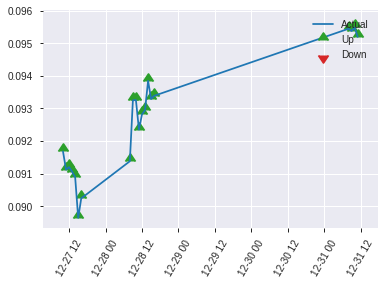


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2524671913830272
RMSE: 0.5024611342014695
LogLoss: 0.6984399428856151
Mean Per-Class Error: 0.45072463768115945
AUC: 0.5388083735909823
pr_auc: 0.5615863024620307
Gini: 0.07761674718196465
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3187050223350525: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    104  0.963    (104.0/108.0)
1      1    114  0.0087   (1.0/115.0)
Total  5    218  0.4709   (105.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.318705     0.684685  217
max f2                       0.269062     0.841874  222
max f0point5                 0.465785     0.582781  159
max accuracy                 0.465785     0.556054  159
max precision                0.732973     1         0
max recall                   0.269062     1         222
max specificity              0.732973     1         0
max absolute_mcc             0.696264     0.151575  11
max min_per_class_accuracy   0.526803     0.518519  111
max mean_per_class_accuracy  0.465785     0.549275  159

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 52.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.723195           1.29275   1.29275            0.666667         0.727224  0.666667                    0.727224            0.0173913       0.0173913                  29.2754   29.2754
    2        0.0224215                   0.718991           1.93913   1.5513             1                0.720931  0.8                         0.724707            0.0173913       0.0347826                  93.913    55.1304
    3        0.0313901                   0.711016           1.93913   1.66211            1                0.716158  0.857143                    0.722264            0.0173913       0.0521739                  93.913    66.2112
    4        0.0403587                   0.698531           0.969565  1.50821            0.5              0.706339  0.777778                    0.718725            0.00869565      0.0608696                  -3.04348  50.8213
    5        0.0538117                   0.695642           1.93913   1.61594            1                0.696997  0.833333                    0.713293            0.026087        0.0869565                  93.913    61.5942
    6        0.103139                    0.659027           0.528854  1.09603            0.272727         0.676798  0.565217                    0.695839            0.026087        0.113043                   -47.1146  9.60302
    7        0.152466                    0.640508           1.05771   1.08363            0.545455         0.6504    0.558824                    0.681138            0.0521739       0.165217                   5.77075   8.36317
    8        0.201794                    0.623127           1.05771   1.07729            0.545455         0.631978  0.555556                    0.669121            0.0521739       0.217391                   5.77075   7.72947
    9        0.300448                    0.582724           1.14585   1.09981            0.590909         0.605464  0.567164                    0.648219            0.113043        0.330435                   14.585    9.98053
    10       0.399103                    0.555831           0.881423  1.04582            0.454545         0.567205  0.539326                    0.628193            0.0869565       0.417391                   -11.8577  4.58232
    11       0.502242                    0.526803           1.01172   1.03882            0.521739         0.541903  0.535714                    0.610473            0.104348        0.521739                   1.17202   3.88199
    12       0.600897                    0.502402           1.05771   1.04192            0.545455         0.512838  0.537313                    0.594443            0.104348        0.626087                   5.77075   4.19208
    13       0.699552                    0.47117            1.05771   1.04415            0.545455         0.486359  0.538462                    0.5792              0.104348        0.730435                   5.77075   4.41472
    14       0.798206                    0.439397           0.881423  1.02404            0.454545         0.454158  0.52809                     0.563746            0.0869565       0.817391                   -11.8577  2.40352
    15       0.896861                    0.40024            0.793281  0.998652           0.409091         0.423358  0.515                       0.548303            0.0782609       0.895652                   -20.6719  -0.134783
    16       1                           0.269062           1.01172   1                  0.521739         0.355881  0.515695                    0.528457       

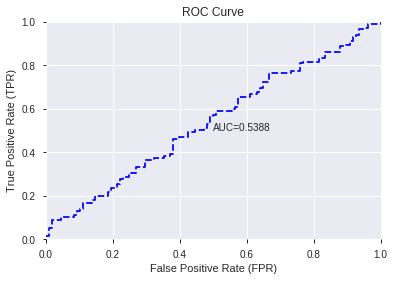

This function is available for GLM models only


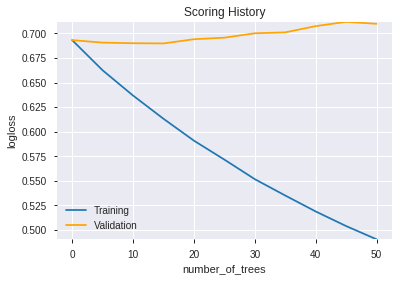

--2019-08-26 20:49:39--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.97.131
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.97.131|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_204916_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_204916_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_afb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'BETA_8',
 'BETA_30',
 'ADX_20',
 'MFI_12',
 'STOCH_slowd',
 'STOCHRSI_fastd',
 'STOCHRSI_fastk',
 'MFI_14',
 'day',
 'SAREXT',
 'HT_DCPERIOD',
 'MFI_8',
 'dayofyear',
 'ADX_24',
 'AROONOSC_24',
 'aroondown_30',
 'aroonup_30',
 'hour',
 'aroonup_20',
 'aroondown_12',
 'aroonup_12',
 'aroonup_8',
 'CORREL_30',
 'aroondown_24',
 'aroondown_20',
 'aroondown_8',
 'aroonup_24',
 'weekday_name',
 'aroondown_14',
 'dayofweek',
 'weekofyear',
 'HT_TRENDMODE',
 'weekday',
 'CDLHIKKAKE',
 'days_in_month',
 'CDLSPINNINGTOP',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_204945_model_1  0.471739  0.698619              0.495089  0.502715  0.252722

variable  relative_importance  scaled_importance    percentage
0                   CDLHIKKAKE         3.020141e-02           1.000000  1.967038e-02
1               CDLMORNINGSTAR         2.080761e-02           0.688962  1.355214e-02
2                          BOP         1.989009e-02           0.658581  1.295455e-02
3                  CDLMARUBOZU         1.880905e-02           0.622787  1.225046e-02
4              CDLHOMINGPIGEON         1.682225e-02           0.557002  1.095645e-02
...                        ...                  ...                ...           ...
1032                       Low         3.935772e-06           0.000130  2.563394e-06
1033  BBANDS_middleband_24_0_4         2.794785e-06           0.000093  1.820262e-06
1034    BBANDS_lowerband_8_4_5         2.733536e-06           0.000091  1.780370e-06
1035  BBANDS_middleband_24_0_5         2.141358e-06           0.000071  1.394681e-06
1036    BBANDS_upperband_8_8_3         1.070234e-07           0.000004  6.970509e-08

[1037 rows x 4 columns]

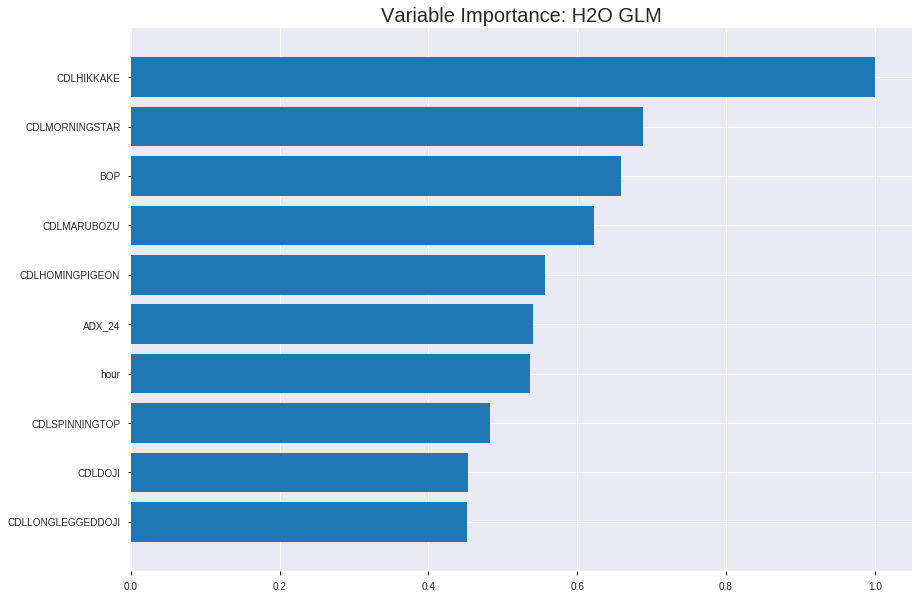

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_204945_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24232754167133697
RMSE: 0.49226775404380996
LogLoss: 0.6776489373053645
Null degrees of freedom: 1557
Residual degrees of freedom: 520
Null deviance: 2158.8195441369685
Residual deviance: 2111.5540886435156
AIC: 4187.554088643516
AUC: 0.6195631561850204
pr_auc: 0.5939438761362064
Gini: 0.2391263123700409
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4175930749007044: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      68   731   0.9149   (731.0/799.0)
1      12   747   0.0158   (12.0/759.0)
Total  80   1478  0.4769   (743.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.417593     0.667859  353
max f2                       0.413801     0.830205  358
max f0point5                 0.474756     0.581784  235
max accuracy                 0.504728     0.587291  151
max precision                0.641778     1         0
max recall                   0.35758      1         394
max specificity              0.641778     1         0
max absolute_mcc             0.474756     0.178413  235
max min_per_class_accuracy   0.490088     0.571805  193
max mean_per_class_accuracy  0.474756     0.585328  235

Gains/Lift Table: Avg response rate: 48.72 %, avg score: 48.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.577828           1.79611   1.79611            0.875            0.591525  0.875                       0.591525            0.0184453       0.0184453                  79.6113   79.6113
    2        0.0205392                   0.568649           1.41123   1.60367            0.6875           0.573385  0.78125                     0.582455            0.0144928       0.0329381                  41.1232   60.3673
    3        0.0301669                   0.561226           0.82108   1.35391            0.4              0.563883  0.659574                    0.576527            0.00790514      0.0408432                  -17.892   35.3909
    4        0.0404365                   0.55464            1.28294   1.33588            0.625            0.557162  0.650794                    0.571609            0.0131752       0.0540184                  28.2938   33.5885
    5        0.0500642                   0.551349           1.23162   1.31583            0.6              0.553074  0.641026                    0.568045            0.0118577       0.0658762                  23.1621   31.5834
    6        0.100128                    0.538304           1.44742   1.38163            0.705128         0.54508   0.673077                    0.556562            0.0724638       0.13834                    44.7417   38.1626
    7        0.150193                    0.529288           1.2632    1.34215            0.615385         0.533736  0.653846                    0.548954            0.0632411       0.201581                   26.3201   34.2151
    8        0.200257                    0.521111           1.21057   1.30925            0.589744         0.524834  0.637821                    0.542924            0.0606061       0.262187                   21.0567   30.9255
    9        0.300385                    0.50974            1.14478   1.25443            0.557692         0.515137  0.611111                    0.533661            0.114625        0.376812                   14.4776   25.4428
    10       0.399872                    0.500032           1.04622   1.20263            0.509677         0.505159  0.585875                    0.52657             0.104084        0.480896                   4.62153   20.2626
    11       0.5                         0.489702           0.9474    1.15152            0.461538         0.494731  0.560976                    0.520194            0.0948617       0.575758                   -5.25996  15.1515
    12       0.600128                    0.479945           1.1053    1.1438             0.538462         0.484747  0.557219                    0.51428             0.110672        0.68643                    10.53     14.3804
    13       0.699615                    0.46755            0.887297  1.10733            0.432258         0.474005  0.53945                     0.508553            0.088274        0.774704                   -11.2703  10.7329
    14       0.799743                    0.452882           0.855292  1.07577            0.416667         0.460853  0.524077                    0.502581            0.085639        0.860343                   -14.4708  7.57734
    15       0.899872                    0.430513           0.815817  1.04685            0.397436         0.442571  0.509986                    0.495903            0.0816864       0.942029                   -18.4183  4.68482
    16       1                           0.306532           0.578967  1                  0.282051         0.408611  0.487163                    0.487163         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25074613905213855
RMSE: 0.5007455831578932
LogLoss: 0.6947658561291373
Null degrees of freedom: 445
Residual degrees of freedom: -592
Null deviance: 620.533011844054
Residual deviance: 619.7311436671905
AIC: 2695.7311436671907
AUC: 0.5284192189272403
pr_auc: 0.5697967809380146
Gini: 0.05683843785448062
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30573289744608195: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    242  0        (0.0/242.0)
Total  0    446  0.4574   (204.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.305733     0.703488  399
max f2                       0.305733     0.855728  399
max f0point5                 0.434727     0.606638  354
max accuracy                 0.450746     0.56278   329
max precision                0.55802      0.823529  14
max recall                   0.305733     1         399
max specificity              0.589522     0.995098  0
max absolute_mcc             0.55802      0.112254  14
max min_per_class_accuracy   0.497694     0.52451   199
max mean_per_class_accuracy  0.474837     0.537129  267

Gains/Lift Table: Avg response rate: 54.26 %, avg score: 49.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.571014           1.47438   1.47438            0.8              0.578706  0.8                         0.578706            0.0165289       0.0165289                  47.438    47.438
    2        0.0201794                   0.564372           1.38223   1.43343            0.75             0.568111  0.777778                    0.573997            0.0123967       0.0289256                  38.2231   43.3425
    3        0.0313901                   0.559878           1.47438   1.44805            0.8              0.5619    0.785714                    0.569677            0.0165289       0.0454545                  47.438    44.8052
    4        0.0403587                   0.557437           1.38223   1.43343            0.75             0.558439  0.777778                    0.567179            0.0123967       0.0578512                  38.2231   43.3425
    5        0.0515695                   0.556413           1.10579   1.3622             0.6              0.556893  0.73913                     0.564943            0.0123967       0.0702479                  10.5785   36.2199
    6        0.100897                    0.543869           0.837716  1.10579            0.454545         0.549548  0.6                         0.557417            0.0413223       0.11157                    -16.2284  10.5785
    7        0.150224                    0.537458           0.837716  1.01776            0.454545         0.540785  0.552239                    0.551956            0.0413223       0.152893                   -16.2284  1.77624
    8        0.201794                    0.531051           0.881423  0.98292            0.478261         0.533398  0.533333                    0.547213            0.0454545       0.198347                   -11.8577  -1.70799
    9        0.300448                    0.519183           1.00526   0.990255           0.545455         0.524087  0.537313                    0.539619            0.0991736       0.297521                   0.52592   -0.974467
    10       0.401345                    0.507652           1.1877    1.03989            0.644444         0.513515  0.564246                    0.533057            0.119835        0.417355                   18.7695   3.9891
    11       0.5                         0.497713           1.04715   1.04132            0.568182         0.502621  0.565022                    0.527052            0.103306        0.520661                   4.7145    4.13223
    12       0.600897                    0.484443           0.941965  1.02464            0.511111         0.492275  0.55597                     0.521212            0.0950413       0.615702                   -5.80349  2.46392
    13       0.699552                    0.47062            1.08903   1.03372            0.590909         0.47676   0.560897                    0.514943            0.107438        0.72314                    8.90308   3.37201
    14       0.800448                    0.457298           1.02388   1.03248            0.555556         0.464722  0.560224                    0.508613            0.103306        0.826446                   2.38751   3.24791
    15       0.899103                    0.433453           0.963373  1.0249             0.522727         0.445613  0.55611                     0.5017              0.0950413       0.921488                   -3.66266  2.48964
    16       1                           0.305733           0.778145  1                  0.422222         0.401117  0.542601                    0.491552        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 20:49:48  0.000 sec   2            4         1026          1.3721            1.39171
    2019-08-26 20:49:50  1.997 sec   4            2.9       1026          1.36883           1.39126
    2019-08-26 20:49:52  4.006 sec   6            2.1       1027          1.36496           1.39047
    2019-08-26 20:49:54  6.087 sec   8            1.5       1034          1.36045           1.3898
    2019-08-26 20:49:56  8.094 sec   10           1.1       1038          1.3553            1.38953
    2019-08-26 20:49:58  10.106 sec  12           0.81      1038          1.34956           1.38992
    2019-08-26 20:50:00  12.113 sec  14           0.59      1038          1.34331           1.39117
    2019-08-26 20:50:03  14.209 sec  16           0.43      1038          1.33664           1.39358
    2019-08-26 20:50:05  16.253 sec  18           0.31      1038          1.32968           1.3972
    2019-08-26 20:50:07  18.508 sec  20           0.23      1038          1.32258           1.40192

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5426008968609866)

('F1', 0.6805970149253733)

('auc', 0.47173913043478266)

('logloss', 0.698619463319893)

('mean_per_class_error', 0.47024959742351047)

('rmse', 0.5027149000750715)

('mse', 0.25272227075748904)

glm prediction progress: |████████████████████████████████████████████████| 100%


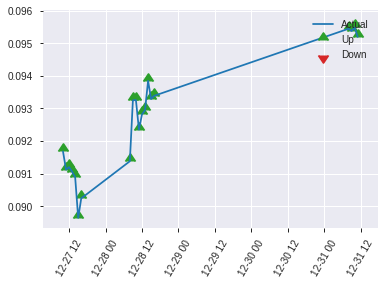


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25272227075748904
RMSE: 0.5027149000750715
LogLoss: 0.698619463319893
Null degrees of freedom: 222
Residual degrees of freedom: -815
Null deviance: 309.6501959015793
Residual deviance: 311.5842806406723
AIC: 2387.584280640672
AUC: 0.47173913043478266
pr_auc: 0.4888742316045801
Gini: -0.05652173913043468
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42400722876011343: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    106  0.9815   (106.0/108.0)
1      1    114  0.0087   (1.0/115.0)
Total  3    220  0.4798   (107.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.424007     0.680597  219
max f2                       0.380019     0.841874  222
max f0point5                 0.453668     0.582524  202
max accuracy                 0.453668     0.542601  202
max precision                0.539925     0.576923  25
max recall                   0.380019     1         222
max specificity              0.584401     0.990741  0
max absolute_mcc             0.520022     0.119105  63
max min_per_class_accuracy   0.50076      0.469565  107
max mean_per_class_accuracy  0.453668     0.52975   202

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 49.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.571656           0.646377  0.646377           0.333333         0.578615  0.333333                    0.578615            0.00869565      0.00869565                 -35.3623  -35.3623
    2        0.0224215                   0.564066           0.969565  0.775652           0.5              0.567855  0.4                         0.574311            0.00869565      0.0173913                  -3.04348  -22.4348
    3        0.0313901                   0.558176           0.969565  0.831056           0.5              0.559632  0.428571                    0.570117            0.00869565      0.026087                   -3.04348  -16.8944
    4        0.0403587                   0.55417            0.969565  0.861836           0.5              0.557972  0.444444                    0.567418            0.00869565      0.0347826                  -3.04348  -13.8164
    5        0.0538117                   0.549516           1.29275   0.969565           0.666667         0.552192  0.5                         0.563612            0.0173913       0.0521739                  29.2754   -3.04348
    6        0.103139                    0.542139           1.05771   1.01172            0.545455         0.544964  0.521739                    0.554693            0.0521739       0.104348                   5.77075   1.17202
    7        0.152466                    0.534069           0.705138  0.912532           0.363636         0.538283  0.470588                    0.549384            0.0347826       0.13913                    -29.4862  -8.7468
    8        0.201794                    0.527854           0.881423  0.904928           0.454545         0.529835  0.466667                    0.544606            0.0434783       0.182609                   -11.8577  -9.50725
    9        0.300448                    0.518397           0.793281  0.868267           0.409091         0.523459  0.447761                    0.537662            0.0782609       0.26087                    -20.6719  -13.1733
    10       0.399103                    0.509207           1.05771   0.915095           0.545455         0.514698  0.47191                     0.531985            0.104348        0.365217                   5.77075   -8.49047
    11       0.502242                    0.499587           1.01172   0.934938           0.521739         0.503644  0.482143                    0.526165            0.104348        0.469565                   1.17202   -6.50621
    12       0.600897                    0.489421           0.969565  0.940623           0.5              0.493327  0.485075                    0.520774            0.0956522       0.565217                   -3.04348  -5.9377
    13       0.699552                    0.479613           1.41028   1.00686            0.727273         0.484461  0.519231                    0.515653            0.13913         0.704348                   41.0277   0.685619
    14       0.798206                    0.468669           1.05771   1.01314            0.545455         0.474347  0.522472                    0.510548            0.104348        0.808696                   5.77075   1.31412
    15       0.896861                    0.456246           1.05771   1.01804            0.545455         0.461521  0.525                       0.505155            0.104348        0.913043                   5.77075   1.80435
    16       1                           0.380019           0.8431    1                  0.434783         0.437802  0.515695                    0.49820

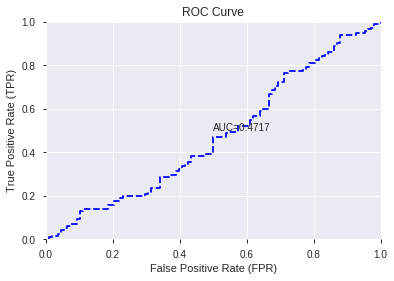

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


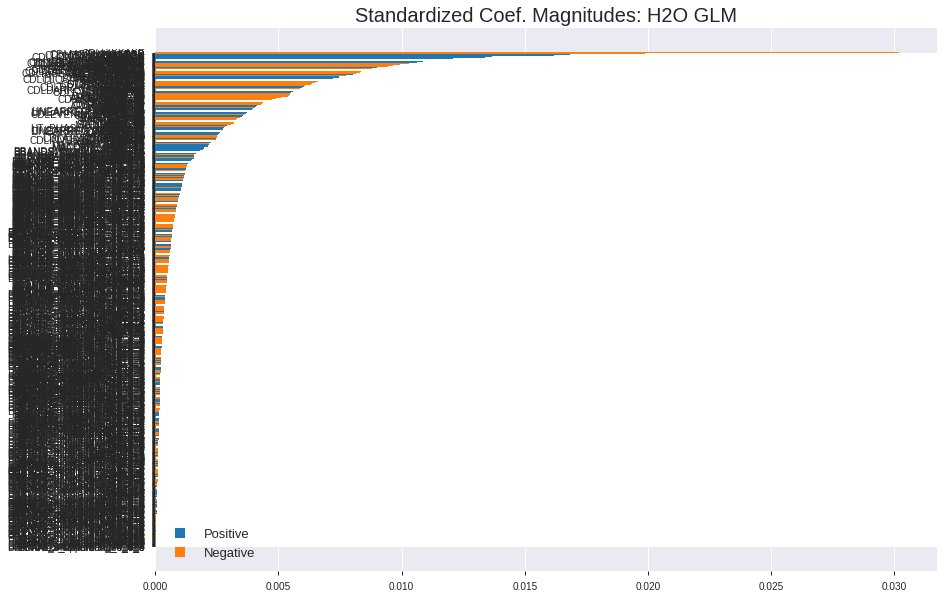

'log_likelihood'
--2019-08-26 20:50:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.206.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.206.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_204945_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_204945_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_afb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

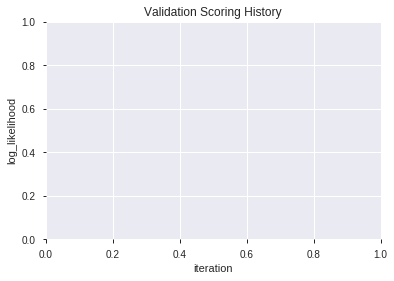

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190826_205040  0.550161  0.708419              0.471377  0.506943  0.256991
1               XGBoost_3_AutoML_20190826_205040  0.539855  0.698068              0.461272  0.502391  0.252397
2  XGBoost_grid_1_AutoML_20190826_205040_model_7  0.539211  0.731017              0.476006  0.517038  0.267329
3               XGBoost_2_AutoML_20190826_205040  0.527456  0.710060              0.451167  0.507811  0.257872
4  XGBoost_grid_1_AutoML_20190826_205040_model_5  0.523269  0.737043              0.471377  0.519006  0.269368
5  XGBoost_grid_1_AutoML_20190826_205040_model_6  0.521981  0.704911              0.486111  0.505678  0.255710
6  XGBoost_grid_1_AutoML_20190826_205040_model_2  0.512560  0.704045              0.495089  0.505277  0.255304
7  XGBoost_grid_1_AutoML_20190826_205040_model_1  0.509179  0.706758              0.481481  0.506519  0.256561
8  XGBoost_grid_1_AutoML_20190826_205040_model_3  0.504187  0.722250              0.471940  0.513660  0.263846
9  XGBoost_grid_1_AutoML_20190826_205040_model_4  0.476409  0.709141              0.485829  0.507782  0.257842

variable  relative_importance  scaled_importance  percentage
0                        BOP           270.971619           1.000000    0.033788
1          HT_PHASOR_inphase           155.711197           0.574640    0.019416
2       HT_PHASOR_quadrature           140.905777           0.520002    0.017570
3                  STDDEV_12           111.847801           0.412766    0.013947
4                     BETA_8           103.674217           0.382602    0.012927
..                       ...                  ...                ...         ...
331             HT_TRENDMODE             1.218891           0.004498    0.000152
332  BBANDS_upperband_20_1_2             1.069046           0.003945    0.000133
333  BBANDS_upperband_20_7_2             1.032643           0.003811    0.000129
334        MACDFIX_signal_14             0.672915           0.002483    0.000084
335  BBANDS_upperband_30_5_5             0.041809           0.000154    0.000005

[336 rows x 4 columns]

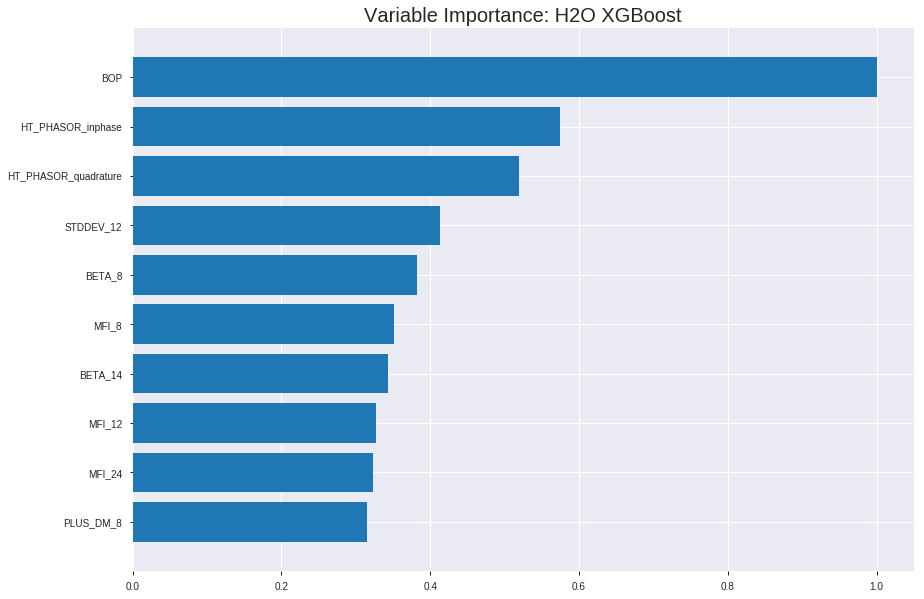

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190826_205040


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13635218180456576
RMSE: 0.36925896306598405
LogLoss: 0.45398429088314907
Mean Per-Class Error: 0.06577556596602152
AUC: 0.9842762939840809
pr_auc: 0.9834553314542555
Gini: 0.9685525879681618
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4988875389099121: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      756  43   0.0538   (43.0/799.0)
1      59   700  0.0777   (59.0/759.0)
Total  815  743  0.0655   (102.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498888     0.932091  200
max f2                       0.425728     0.949174  245
max f0point5                 0.540657     0.95547   174
max accuracy                 0.506541     0.934531  195
max precision                0.846398     1         0
max recall                   0.355072     1         290
max specificity              0.846398     1         0
max absolute_mcc             0.506541     0.869575  195
max min_per_class_accuracy   0.491696     0.932416  205
max mean_per_class_accuracy  0.498888     0.934224  200

Gains/Lift Table: Avg response rate: 48.72 %, avg score: 48.85 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.804376           2.0527     2.0527             1                0.817497  1                           0.817497            0.0210804       0.0210804                  105.27    105.27
    2        0.0205392                   0.779467           2.0527     2.0527             1                0.787478  1                           0.802488            0.0210804       0.0421607                  105.27    105.27
    3        0.0301669                   0.764806           2.0527     2.0527             1                0.77054   1                           0.792292            0.0197628       0.0619236                  105.27    105.27
    4        0.0404365                   0.752011           2.0527     2.0527             1                0.758748  1                           0.783773            0.0210804       0.083004                   105.27    105.27
    5        0.0500642                   0.741183           2.0527     2.0527             1                0.748264  1                           0.776944            0.0197628       0.102767                   105.27    105.27
    6        0.100128                    0.714014           2.0527     2.0527             1                0.725793  1                           0.751369            0.102767        0.205534                   105.27    105.27
    7        0.150193                    0.686255           2.0527     2.0527             1                0.700528  1                           0.734422            0.102767        0.3083                     105.27    105.27
    8        0.200257                    0.660492           2.0527     2.0527             1                0.673565  1                           0.719208            0.102767        0.411067                   105.27    105.27
    9        0.300385                    0.61163            2.03954    2.04831            0.99359          0.637206  0.997863                    0.691874            0.204216        0.615283                   103.954   104.831
    10       0.399872                    0.55145            1.96       2.02634            0.954839         0.581702  0.987159                    0.664463            0.194993        0.810277                   95.9998   102.634
    11       0.5                         0.483699           1.31583    1.88406            0.641026         0.517303  0.917843                    0.634994            0.131752        0.942029                   31.5834   88.4058
    12       0.600128                    0.411932           0.447384   1.64436            0.217949         0.44659   0.80107                     0.603559            0.0447958       0.986825                   -55.2616  64.4356
    13       0.699615                    0.362598           0.119189   1.42747            0.0580645        0.386985  0.695413                    0.572762            0.0118577       0.998682                   -88.0811  42.7475
    14       0.799743                    0.322062           0.0131583  1.2504             0.00641026       0.342574  0.609149                    0.543942            0.00131752      1                          -98.6842  25.0401
    15       0.899872                    0.273306           0          1.11127            0                0.299316  0.541369                    0.516723            0               1                          -100      11.127
    16       1                           0.15463            0          1                  0                0.234368  0.487163                    0.488451



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26296966162227675
RMSE: 0.5128056762773563
LogLoss: 0.7217351669690358
Mean Per-Class Error: 0.4545859666180522
AUC: 0.5243376276130287
pr_auc: 0.560186913694036
Gini: 0.04867525522605742
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20544099807739258: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    203  0.9951   (203.0/204.0)
1      0    242  0        (0.0/242.0)
Total  1    445  0.4552   (203.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.205441     0.704512  398
max f2                       0.205441     0.856334  398
max f0point5                 0.229329     0.599401  393
max accuracy                 0.256619     0.547085  388
max precision                0.808067     0.666667  2
max recall                   0.205441     1         398
max specificity              0.810287     0.995098  0
max absolute_mcc             0.476049     0.090652  189
max min_per_class_accuracy   0.469415     0.524793  200
max mean_per_class_accuracy  0.476049     0.545414  189

Gains/Lift Table: Avg response rate: 54.26 %, avg score: 47.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.74298            1.10579   1.10579            0.6              0.790063  0.6                         0.790063            0.0123967       0.0123967                  10.5785   10.5785
    2        0.0201794                   0.721288           0.921488  1.02388            0.5              0.735466  0.555556                    0.765797            0.00826446      0.0206612                  -7.85124  2.38751
    3        0.0313901                   0.683952           1.10579   1.05313            0.6              0.699969  0.571429                    0.742287            0.0123967       0.0330579                  10.5785   5.31287
    4        0.0403587                   0.677176           0.921488  1.02388            0.5              0.680241  0.555556                    0.728499            0.00826446      0.0413223                  -7.85124  2.38751
    5        0.0515695                   0.670333           1.10579   1.04168            0.6              0.674068  0.565217                    0.716666            0.0123967       0.053719                   10.5785   4.16816
    6        0.100897                    0.621345           1.00526   1.02388            0.545455         0.647903  0.555556                    0.683049            0.0495868       0.103306                   0.52592   2.38751
    7        0.150224                    0.595822           1.08903   1.04527            0.590909         0.613162  0.567164                    0.660101            0.053719        0.157025                   8.90308   4.52695
    8        0.201794                    0.569886           1.20194   1.08531            0.652174         0.58237   0.588889                    0.640236            0.0619835       0.219008                   20.194    8.53076
    9        0.300448                    0.540736           1.08903   1.08653            0.590909         0.555029  0.589552                    0.612258            0.107438        0.326446                   8.90308   8.65302
    10       0.401345                    0.502403           0.941965  1.05019            0.511111         0.520674  0.569832                    0.589234            0.0950413       0.421488                   -5.80349  5.0187
    11       0.5                         0.469234           1.04715   1.04959            0.568182         0.484618  0.569507                    0.568592            0.103306        0.524793                   4.7145    4.95868
    12       0.600897                    0.438084           0.8191    1.01089            0.444444         0.45166   0.548507                    0.548958            0.0826446       0.607438                   -18.09    1.08857
    13       0.699552                    0.405402           1.00526   1.01009            0.545455         0.42162   0.548077                    0.531               0.0991736       0.706612                   0.52592   1.00922
    14       0.800448                    0.354911           0.941965  1.0015             0.511111         0.377958  0.543417                    0.511709            0.0950413       0.801653                   -5.80349  0.150473
    15       0.899103                    0.317866           0.879602  0.988129           0.477273         0.331938  0.53616                     0.491984            0.0867769       0.88843                    -12.0398  -1.18711
    16       1                           0.203258           1.10579   1                  0.6              0.278736  0.542601                    0.470468        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 20:50:41  0.006 sec   0                  0.5              0.693147            0.5             0                  1                0.512837                         0.5                0.693147              0.5               0                    1                  0.457399
    2019-08-26 20:50:42  1.396 sec   5                  0.483016         0.659656            0.821755        0.802656           2.0527           0.250963                         0.499361           0.691872              0.534537          0.578057             1.10579            0.457399
    2019-08-26 20:50:42  1.685 sec   10                 0.465776         0.626549            0.896107        0.887524           2.0527           0.189987                         0.501354           0.695899              0.5245            0.562972             1.10579            0.455157
    2019-08-26 20:50:43  1.980 sec   15                 0.451005         0.598784            0.92118         0.915222           2.0527           0.147625                         0.502966           0.699234              0.521087          0.566589             1.10579            0.455157
    2019-08-26 20:50:43  2.265 sec   20                 0.436907         0.572746            0.940203        0.935909           2.0527           0.130937                         0.504592           0.702589              0.514524          0.567263             1.47438            0.455157
    2019-08-26 20:50:43  2.539 sec   25                 0.424487         0.550159            0.953429        0.94926            2.0527           0.120026                         0.506467           0.706649              0.51504           0.56604              1.10579            0.455157
    2019-08-26 20:50:44  2.841 sec   30                 0.411824         0.527558            0.964164        0.963333           2.0527           0.0988447                        0.508512           0.711238              0.517572          0.561556             1.47438            0.457399
    2019-08-26 20:50:44  3.144 sec   35                 0.400618         0.507677            0.969486        0.968529           2.0527           0.0949936                        0.509721           0.714063              0.52295           0.563                1.47438            0.455157
    2019-08-26 20:50:44  3.431 sec   40                 0.390614         0.490256            0.973842        0.972763           2.0527           0.0879332                        0.510168           0.715132              0.52614           0.564612             1.47438            0.457399
    2019-08-26 20:50:44  3.740 sec   45                 0.380035         0.472066            0.97915         0.978257           2.0527           0.0750963                        0.512132           0.719799              0.521684          0.55987              1.10579            0.457399
    2019-08-26 20:50:45  4.044 sec   50                 0.369259         0.453984            0.984276        0.983455           2.0527           0.0654685                        0.512806           0.721735              0.524338          0.560187             1.10579            0.455157

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      270.97161865234375     1.0                     0.03378797832477426
HT_PHASOR_inphase        155.71119689941406     0.574640243409371       0.01941593208885883
HT_PHASOR_quadrature     140.90577697753906     0.5200019754036345      0.017569815473777797
STDDEV_12                111.8478012084961      0.41276574190596943     0.01394651994072826
BETA_8                   103.6742172241211      0.3826017563748438      0.012927339851413783
---                      ---                    ---                     ---
HT_TRENDMODE             1.2188911437988281     0.004498224389184699    0.00015198590816174352
BBANDS_upperband_20_1_2  1.0690460205078125     0.003945232441038031    0.00013330142820398922
BBANDS_upperband_20_7_2  1.0326433181762695     0.0038108910568274298   0.00012876230442616127
MACDFIX_signal_14        0.6729145050048828     0.00248333942998005     8.390701883322318e-05
BBANDS_upperband_30_5_5  0.04180908203125       0.00015429321431958157  5.213255781089771e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5739910313901345)

('F1', 0.687116564417178)

('auc', 0.5501610305958132)

('logloss', 0.7084194607543849)

('mean_per_class_error', 0.43486312399355875)

('rmse', 0.506943082032715)

('mse', 0.256991288420828)

xgboost prediction progress: |████████████████████████████████████████████| 100%


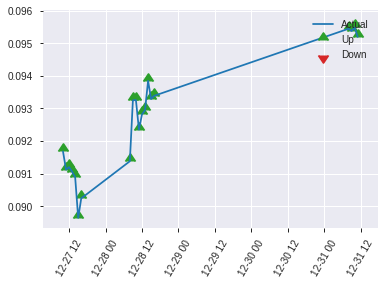


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.256991288420828
RMSE: 0.506943082032715
LogLoss: 0.7084194607543849
Mean Per-Class Error: 0.43486312399355875
AUC: 0.5501610305958132
pr_auc: 0.5371379333278109
Gini: 0.10032206119162645
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27003318071365356: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    99   0.9167   (99.0/108.0)
1      3    112  0.0261   (3.0/115.0)
Total  12   211  0.4574   (102.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.270033     0.687117  210
max f2                       0.227291     0.841874  222
max f0point5                 0.354847     0.598802  179
max accuracy                 0.354847     0.573991  179
max precision                0.788563     1         0
max recall                   0.227291     1         222
max specificity              0.788563     1         0
max absolute_mcc             0.354847     0.163188  179
max min_per_class_accuracy   0.464858     0.537037  111
max mean_per_class_accuracy  0.423359     0.565137  142

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 47.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.766257           1.29275   1.29275            0.666667         0.78073   0.666667                    0.78073             0.0173913       0.0173913                  29.2754   29.2754
    2        0.0224215                   0.741315           1.93913   1.5513             1                0.749608  0.8                         0.768281            0.0173913       0.0347826                  93.913    55.1304
    3        0.0313901                   0.724205           0.969565  1.38509            0.5              0.729308  0.714286                    0.757146            0.00869565      0.0434783                  -3.04348  38.5093
    4        0.0403587                   0.709618           0         1.07729            0                0.720029  0.555556                    0.748898            0               0.0434783                  -100      7.72947
    5        0.0538117                   0.686241           0.646377  0.969565           0.333333         0.701141  0.5                         0.736959            0.00869565      0.0521739                  -35.3623  -3.04348
    6        0.103139                    0.642426           0.528854  0.75879            0.272727         0.65028   0.391304                    0.695504            0.026087        0.0782609                  -47.1146  -24.121
    7        0.152466                    0.619051           1.58656   1.0266             0.818182         0.629054  0.529412                    0.674005            0.0782609       0.156522                   58.6561   2.65985
    8        0.201794                    0.576594           0.881423  0.991111           0.454545         0.599554  0.511111                    0.655806            0.0434783       0.2                        -11.8577  -0.888889
    9        0.300448                    0.529619           1.32213   1.09981            0.681818         0.546565  0.567164                    0.619936            0.130435        0.330435                   32.2134   9.98053
    10       0.399103                    0.489913           0.793281  1.02404            0.409091         0.513901  0.52809                     0.593725            0.0782609       0.408696                   -20.6719  2.40352
    11       0.502242                    0.464858           1.26465   1.07345            0.652174         0.475254  0.553571                    0.569396            0.130435        0.53913                    26.465    7.34472
    12       0.600897                    0.438521           1.05771   1.07086            0.545455         0.450411  0.552239                    0.549861            0.104348        0.643478                   5.77075   7.08631
    13       0.699552                    0.403413           1.05771   1.06901            0.545455         0.419674  0.551282                    0.531502            0.104348        0.747826                   5.77075   6.90078
    14       0.798206                    0.357138           1.05771   1.06761            0.545455         0.382245  0.550562                    0.513054            0.104348        0.852174                   5.77075   6.76111
    15       0.896861                    0.320487           0.881423  1.04713            0.454545         0.33898   0.54                        0.493906            0.0869565       0.93913                    -11.8577  4.71304
    16       1                           0.227291           0.59017   1                  0.304348         0.269484  0.515695                    0.470759      

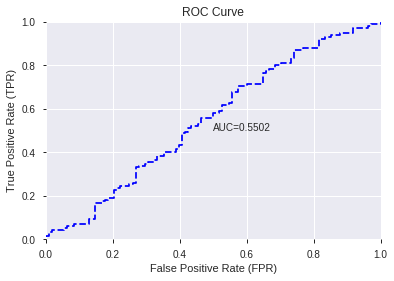

This function is available for GLM models only


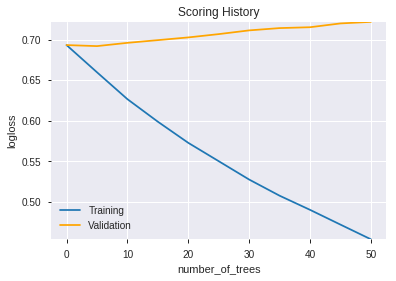

--2019-08-26 20:51:36--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.92.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.92.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190826_205040',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190826_205040',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_afb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_afb1',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190826_205142  0.555556  0.779178               0.49537  0.530308  0.281227
1  DeepLearning_grid_1_AutoML_20190826_205142_model_4  0.490097  1.021725               0.50000  0.569310  0.324114
2  DeepLearning_grid_1_AutoML_20190826_205142_model_1  0.484863  1.655334               0.50000  0.621984  0.386864
3  DeepLearning_grid_1_AutoML_20190826_205142_model_8  0.478341  0.699160               0.50000  0.502951  0.252960
4  DeepLearning_grid_1_AutoML_20190826_205142_model_5  0.469565  0.704949               0.50000  0.505721  0.255754
5  DeepLearning_grid_1_AutoML_20190826_205142_model_2  0.468599  1.378979               0.50000  0.612344  0.374965
6  DeepLearning_grid_1_AutoML_20190826_205142_model_7  0.467955  0.807229               0.49537  0.543223  0.295091
7  DeepLearning_grid_1_AutoML_20190826_205142_model_3  0.457971  1.408577               0.50000  0.594090  0.352942
8  DeepLearning_grid_1_AutoML_20190826_205142_model_9  0.451047  0.712447               0.50000  0.509272  0.259358
9  DeepLearning_grid_1_AutoML_20190826_205142_model_6  0.442995  0.710502               0.49537  0.508368  0.258438

variable  relative_importance  scaled_importance  percentage
0            weekofyear             1.000000           1.000000    0.028882
1       CDLLADDERBOTTOM             0.975017           0.975017    0.028160
2                MFI_14             0.971713           0.971713    0.028065
3                   BOP             0.952070           0.952070    0.027497
4        CDLRICKSHAWMAN             0.918398           0.918398    0.026525
5            aroonup_20             0.854295           0.854295    0.024673
6          CDLTHRUSTING             0.846864           0.846864    0.024459
7                   day             0.834881           0.834881    0.024113
8           AROONOSC_24             0.827461           0.827461    0.023898
9             CORREL_30             0.822354           0.822354    0.023751
10              CDLDOJI             0.816532           0.816532    0.023583
11            dayofweek             0.815518           0.815518    0.023554
12         aroondown_14             0.812486           0.812486    0.023466
13        days_in_month             0.787560           0.787560    0.022746
14               ADX_20             0.779399           0.779399    0.022510
15         aroondown_24             0.774889           0.774889    0.022380
16              BETA_30             0.767666           0.767666    0.022171
17       STOCHRSI_fastk             0.761686           0.761686    0.021999
18              weekday             0.759759           0.759759    0.021943
19            dayofyear             0.741761           0.741761    0.021423
20          aroondown_8             0.718815           0.718815    0.020761
21           aroonup_12             0.708484           0.708484    0.020462
22                MFI_8             0.700295           0.700295    0.020226
23           aroonup_24             0.671274           0.671274    0.019388
24               SAREXT             0.670872           0.670872    0.019376
25         weekday_name             0.661473           0.661473    0.019104
26            aroonup_8             0.657296           0.657296    0.018984
27               MFI_12             0.656854           0.656854    0.018971
28       CDLSPINNINGTOP             0.653160           0.653160    0.018864
29                 hour             0.650641           0.650641    0.018792
30          STOCH_slowd             0.630162           0.630162    0.018200
31    CDLLONGLEGGEDDOJI             0.628932           0.628932    0.018165
32         aroondown_20             0.618462           0.618462    0.017862
33               BETA_8             0.611288           0.611288    0.017655
34          HT_DCPERIOD             0.605935           0.605935    0.017500
35  CDLGAPSIDESIDEWHITE             0.595445           0.595445    0.017197
36         aroondown_12             0.592710           0.592710    0.017118
37             CORREL_8             0.586413           0.586413    0.016937
38   CDLMORNINGDOJISTAR             0.581612           0.581612    0.016798
39           CDLHIKKAKE             0.578825           0.578825    0.016717
40           aroonup_30             0.576478           0.576478    0.016650
41         CDLTASUKIGAP             0.575591           0.575591    0.016624
42   CDLEVENINGDOJISTAR             0.571193           0.571193    0.016497
43               ADX_24             0.531634           0.531634    0.015354
44       CDLMORNINGSTAR             0.504443           0.504443    0.014569
45  CDLRISEFALL3METHODS             0.499199           0.499199    0.014418
46       CDL3BLACKCROWS             0.480666           0.480666    0.013882
47       STOCHRSI_fastd             0.470978           0.470978    0.013603
48         aroondown_30             0.465893           0.465893    0.013456
49         HT_TRENDMODE             0.348686           0.348686    0.010071

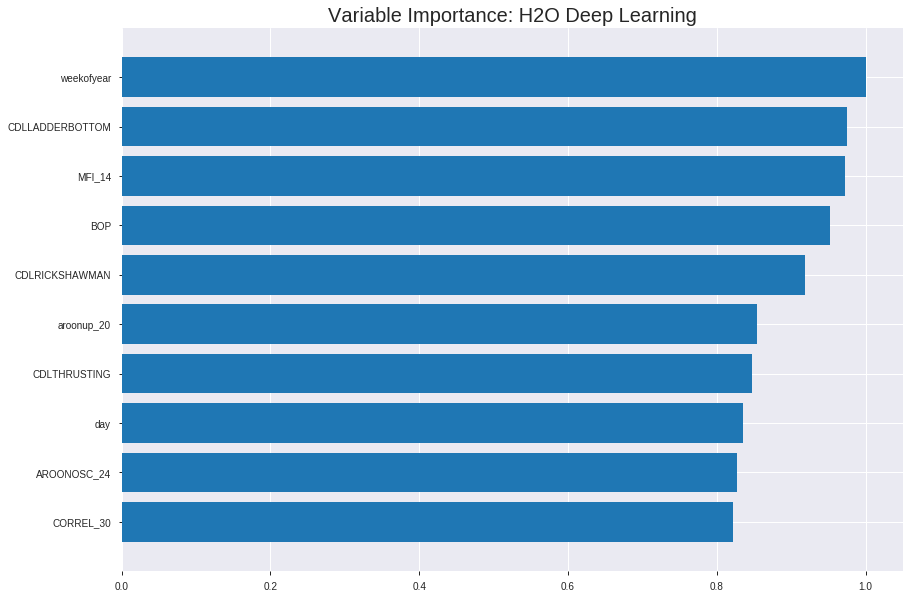

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190826_205142


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.22984725235849066
RMSE: 0.4794238754572937
LogLoss: 0.654029417014802
Mean Per-Class Error: 0.3722208755674501
AUC: 0.6651545657368152
pr_auc: 0.6460773372508145
Gini: 0.3303091314736304
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36062168442804543: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      250  549   0.6871   (549.0/799.0)
1      97   662   0.1278   (97.0/759.0)
Total  347  1211  0.4146   (646.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.360622     0.672081  292
max f2                       0.153106     0.827865  384
max f0point5                 0.505818     0.61805   198
max accuracy                 0.505818     0.627728  198
max precision                0.883927     0.9       7
max recall                   0.00303171   1         399
max specificity              0.978013     0.998748  0
max absolute_mcc             0.463098     0.2571    226
max min_per_class_accuracy   0.505818     0.625782  198
max mean_per_class_accuracy  0.505818     0.627779  198

Gains/Lift Table: Avg response rate: 48.72 %, avg score: 50.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.858399           1.79611   1.79611            0.875            0.896585  0.875                       0.896585            0.0184453       0.0184453                  79.6113   79.6113
    2        0.0205392                   0.828972           1.53953   1.66782            0.75             0.841453  0.8125                      0.869019            0.0158103       0.0342556                  53.9526   66.7819
    3        0.0301669                   0.803383           1.64216   1.65963            0.8              0.812842  0.808511                    0.85109             0.0158103       0.0500659                  64.2161   65.9631
    4        0.0404365                   0.785324           1.66782   1.66171            0.8125           0.796352  0.809524                    0.837189            0.0171278       0.0671937                  66.7819   66.171
    5        0.0500642                   0.77461            1.50531   1.63163            0.733333         0.779123  0.794872                    0.826022            0.0144928       0.0816864                  50.5314   63.1634
    6        0.100128                    0.723791           1.60532   1.61848            0.782051         0.749231  0.788462                    0.787627            0.0803689       0.162055                   60.5317   61.8476
    7        0.150193                    0.688316           1.2632    1.50005            0.615385         0.704008  0.730769                    0.759754            0.0632411       0.225296                   26.3201   50.0051
    8        0.200257                    0.65958            1.18425   1.4211             0.576923         0.673052  0.692308                    0.738078            0.0592885       0.284585                   18.4251   42.1101
    9        0.300385                    0.606906           1.15793   1.33338            0.564103         0.632676  0.649573                    0.702944            0.115942        0.400527                   15.7934   33.3378
    10       0.399872                    0.556225           1.03297   1.25864            0.503226         0.580263  0.613162                    0.672422            0.102767        0.503294                   3.29721   25.8638
    11       0.5                         0.504283           1.27636   1.26219            0.621795         0.528127  0.614891                    0.643526            0.1278          0.631094                   27.6359   26.2187
    12       0.600128                    0.455066           0.907925  1.20308            0.442308         0.479429  0.586096                    0.616147            0.0909091       0.722003                   -9.20746  20.308
    13       0.699615                    0.401328           0.834324  1.15064            0.406452         0.428865  0.56055                     0.589515            0.083004        0.805007                   -16.5676  15.0642
    14       0.799743                    0.348429           0.763184  1.10213            0.371795         0.375104  0.536918                    0.562671            0.0764163       0.881423                   -23.6816  10.2132
    15       0.899872                    0.276174           0.644759  1.05124            0.314103         0.315175  0.512126                    0.535132            0.0645586       0.945982                   -35.5241  5.12406
    16       1                           0.00240923         0.539492  1                  0.262821         0.210935  0.487163                    0.50267            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2862212279208797
RMSE: 0.534996474680796
LogLoss: 0.7880852592832405
Mean Per-Class Error: 0.4832685140171771
AUC: 0.4935383244206774
pr_auc: 0.5315412222699264
Gini: -0.01292335115864518
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11688361760970395: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    242  0        (0.0/242.0)
Total  0    446  0.4574   (204.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.116884     0.703488  399
max f2                       0.116884     0.855728  399
max f0point5                 0.258082     0.598224  374
max accuracy                 0.262754     0.547085  372
max precision                0.75256      0.589041  64
max recall                   0.116884     1         399
max specificity              0.950656     0.995098  0
max absolute_mcc             0.909893     0.127187  5
max min_per_class_accuracy   0.566205     0.487603  192
max mean_per_class_accuracy  0.613699     0.516731  158

Gains/Lift Table: Avg response rate: 54.26 %, avg score: 55.19 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.912421           0         0                  0                0.928904  0                           0.928904            0               0                          -100      -100
    2        0.0201794                   0.890857           0.460744  0.204775           0.25             0.902146  0.111111                    0.917012            0.00413223      0.00413223                 -53.9256  -79.5225
    3        0.0313901                   0.876239           1.10579   0.526564           0.6              0.883337  0.285714                    0.904985            0.0123967       0.0165289                  10.5785   -47.3436
    4        0.0403587                   0.866126           0.921488  0.614325           0.5              0.870099  0.333333                    0.897232            0.00826446      0.0247934                  -7.85124  -38.5675
    5        0.0515695                   0.855154           1.47438   0.801294           0.8              0.861792  0.434783                    0.889528            0.0165289       0.0413223                  47.438    -19.8706
    6        0.100897                    0.788929           1.34035   1.06483            0.727273         0.819032  0.577778                    0.855063            0.0661157       0.107438                   34.0346   6.48301
    7        0.150224                    0.756331           0.921488  1.01776            0.5              0.772095  0.552239                    0.82782             0.0454545       0.152893                   -7.85124  1.77624
    8        0.201794                    0.713465           1.12181   1.04435            0.608696         0.735942  0.566667                    0.80434             0.0578512       0.210744                   12.1811   4.43526
    9        0.300448                    0.65994            0.879602  0.990255           0.477273         0.687426  0.537313                    0.76595             0.0867769       0.297521                   -12.0398  -0.974467
    10       0.401345                    0.614701           1.14674   1.0296             0.622222         0.637788  0.558659                    0.733731            0.115702        0.413223                   14.674    2.95951
    11       0.5                         0.563541           0.753944  0.975207           0.409091         0.588388  0.529148                    0.705053            0.0743802       0.487603                   -24.6056  -2.47934
    12       0.600897                    0.510931           1.10579   0.997132           0.6              0.537538  0.541045                    0.676926            0.11157         0.599174                   10.5785   -0.286789
    13       0.699552                    0.460339           0.879602  0.980557           0.477273         0.484619  0.532051                    0.649806            0.0867769       0.68595                    -12.0398  -1.94427
    14       0.800448                    0.373036           1.06483   0.99118            0.577778         0.410615  0.537815                    0.619656            0.107438        0.793388                   6.48301   -0.882006
    15       0.899103                    0.296623           1.13092   1.00651            0.613636         0.335082  0.546135                    0.58843             0.11157         0.904959                   13.0917   0.651264
    16       1                           0.116884           0.941965  1                  0.511111         0.225994  0.542601                    0.55186


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 20:51:43  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 20:51:43  0.071 sec   59923 obs/sec     1         1             1558       0.562114         0.905966            -0.264722      0.53341         0.507434           1.15464          0.512837                         0.589001           0.99904               -0.397836        0.478387          0.54489              0.368595           0.457399
    2019-08-26 20:51:43  0.350 sec   56861 obs/sec     10        10            15580      0.479424         0.654029            0.0800046      0.665155        0.646077           1.79611          0.414634                         0.534996           0.788085              -0.153257        0.493538          0.531541             0                  0.457399

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
weekofyear           1.0                    1.0                  0.028881685578266356
CDLLADDERBOTTOM      0.975016713142395      0.975016713142395    0.028160126142533375
MFI_14               0.9717128872871399     0.9717128872871399   0.02806470608297655
BOP                  0.9520697593688965     0.9520697593688965   0.027497379438668177
CDLRICKSHAWMAN       0.9183977842330933     0.9183977842330933   0.026524876039996707
---                  ---                    ---                  ---
CDLRISEFALL3METHODS  0.49919942021369934    0.49919942021369934  0.014417720695464927
CDL3BLACKCROWS       0.4806663990020752     0.4806663990020752   0.013882455804015457
STOCHRSI_fastd       0.4709778130054474     0.4709778130054474   0.013602633109562858
aroondown_30         0.4658927321434021     0.4658927321434021   0.013455767402965207
HT_TRENDMODE         0.3486863970756531     0.3486863970756531   0.010070650885757546


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5650224215246636)

('F1', 0.6824925816023739)

('auc', 0.5555555555555556)

('logloss', 0.7791782060213187)

('mean_per_class_error', 0.4341384863123994)

('rmse', 0.5303081431179711)

('mse', 0.28122672665723053)

deeplearning prediction progress: |███████████████████████████████████████| 100%


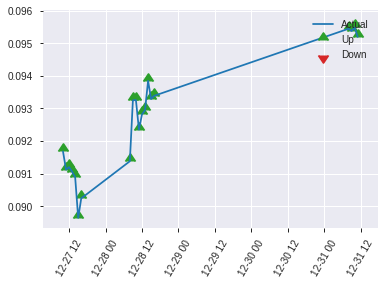


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.28122672665723053
RMSE: 0.5303081431179711
LogLoss: 0.7791782060213187
Mean Per-Class Error: 0.4341384863123994
AUC: 0.5555555555555556
pr_auc: 0.5543020468266535
Gini: 0.11111111111111116
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12104610810093651: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    107  0.9907   (107.0/108.0)
1      0    115  0        (0.0/115.0)
Total  1    222  0.4798   (107.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.121046     0.682493  221
max f2                       0.121046     0.843109  221
max f0point5                 0.542646     0.57971   160
max accuracy                 0.681656     0.565022  105
max precision                0.925217     0.666667  2
max recall                   0.121046     1         221
max specificity              0.959246     0.990741  0
max absolute_mcc             0.681656     0.131819  105
max min_per_class_accuracy   0.674335     0.555556  111
max mean_per_class_accuracy  0.681656     0.565862  105

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 63.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.924872           1.29275   1.29275            0.666667         0.939382  0.666667                    0.939382            0.0173913       0.0173913                  29.2754   29.2754
    2        0.0224215                   0.909503           0.969565  1.16348            0.5              0.918346  0.6                         0.930968            0.00869565      0.026087                   -3.04348  16.3478
    3        0.0313901                   0.901481           0         0.831056           0                0.903242  0.428571                    0.923046            0               0.026087                   -100      -16.8944
    4        0.0403587                   0.879123           1.93913   1.07729            1                0.900461  0.555556                    0.918027            0.0173913       0.0434783                  93.913    7.72947
    5        0.0538117                   0.870719           1.29275   1.13116            0.666667         0.874694  0.583333                    0.907194            0.0173913       0.0608696                  29.2754   13.1159
    6        0.103139                    0.836836           1.05771   1.09603            0.545455         0.851423  0.565217                    0.880521            0.0521739       0.113043                   5.77075   9.60302
    7        0.152466                    0.807758           1.05771   1.08363            0.545455         0.823896  0.558824                    0.862201            0.0521739       0.165217                   5.77075   8.36317
    8        0.201794                    0.77821            1.05771   1.07729            0.545455         0.789646  0.555556                    0.844465            0.0521739       0.217391                   5.77075   7.72947
    9        0.300448                    0.738582           1.14585   1.09981            0.590909         0.753502  0.567164                    0.814597            0.113043        0.330435                   14.585    9.98053
    10       0.399103                    0.704373           1.05771   1.0894             0.545455         0.724828  0.561798                    0.792407            0.104348        0.434783                   5.77075   8.93991
    11       0.502242                    0.674335           1.18034   1.10807            0.608696         0.690934  0.571429                    0.771569            0.121739        0.556522                   18.034    10.8075
    12       0.600897                    0.629507           0.793281  1.05639            0.409091         0.656035  0.544776                    0.7526              0.0782609       0.634783                   -20.6719  5.6392
    13       0.699552                    0.567649           1.05771   1.05658            0.545455         0.599765  0.544872                    0.731047            0.104348        0.73913                    5.77075   5.65775
    14       0.798206                    0.46325            0.793281  1.02404            0.409091         0.514303  0.52809                     0.704258            0.0782609       0.817391                   -20.6719  2.40352
    15       0.896861                    0.371982           0.881423  1.00835            0.454545         0.425942  0.52                        0.673643            0.0869565       0.904348                   -11.8577  0.834783
    16       1                           0.0018835          0.92741   1                  0.478261         0.26065   0.515695                    0.631048        

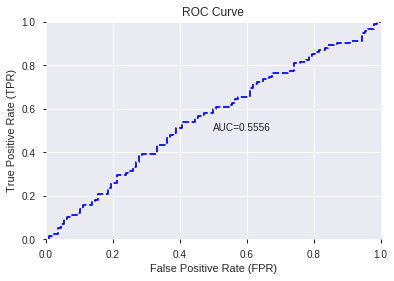

This function is available for GLM models only


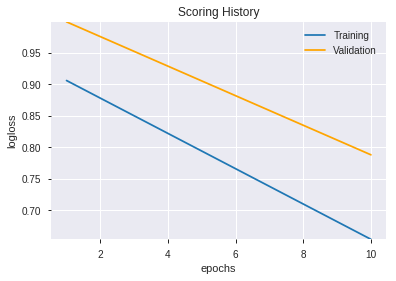

--2019-08-26 20:59:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190826_205142',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190826_205142',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_afb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_50_sid_afb1'

['weekofyear',
 'CDLLADDERBOTTOM',
 'MFI_14',
 'BOP',
 'CDLRICKSHAWMAN',
 'aroonup_20',
 'CDLTHRUSTING',
 'day',
 'AROONOSC_24',
 'CORREL_30',
 'CDLDOJI',
 'dayofweek',
 'aroondown_14',
 'days_in_month',
 'ADX_20',
 'aroondown_24',
 'BETA_30',
 'STOCHRSI_fastk',
 'weekday',
 'dayofyear',
 'aroondown_8',
 'aroonup_12',
 'MFI_8',
 'aroonup_24',
 'SAREXT',
 'weekday_name',
 'aroonup_8',
 'MFI_12',
 'CDLSPINNINGTOP',
 'hour',
 'STOCH_slowd',
 'CDLLONGLEGGEDDOJI',
 'aroondown_20',
 'BETA_8',
 'HT_DCPERIOD',
 'CDLGAPSIDESIDEWHITE',
 'aroondown_12',
 'CORREL_8',
 'CDLMORNINGDOJISTAR',
 'CDLHIKKAKE',
 'aroonup_30',
 'CDLTASUKIGAP',
 'CDLEVENINGDOJISTAR',
 'ADX_24',
 'CDLMORNINGSTAR',
 'CDLRISEFALL3METHODS',
 'CDL3BLACKCROWS',
 'STOCHRSI_fastd',
 'aroondown_30',
 'HT_TRENDMODE']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc  logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190826_205931_model_1  0.457568  0.71403                   0.5  0.50973  0.259824

variable  relative_importance  scaled_importance  percentage
0            CDLHIKKAKE             0.085124           1.000000    0.064353
1                   BOP             0.073851           0.867564    0.055830
2        CDLMORNINGSTAR             0.060085           0.705850    0.045424
3                  hour             0.049802           0.585050    0.037650
4        CDLSPINNINGTOP             0.045224           0.531276    0.034189
5          HT_TRENDMODE             0.042537           0.499707    0.032158
6                 MFI_8             0.040480           0.475541    0.030602
7            weekofyear             0.036790           0.432194    0.027813
8                ADX_24             0.036367           0.427225    0.027493
9             dayofyear             0.036320           0.426676    0.027458
10             CORREL_8             0.035884           0.421554    0.027128
11           aroonup_20             0.033798           0.397049    0.025551
12               MFI_14             0.033666           0.395489    0.025451
13              BETA_30             0.031655           0.371873    0.023931
14           aroonup_30             0.028937           0.339942    0.021876
15              CDLDOJI             0.028761           0.337872    0.021743
16    CDLLONGLEGGEDDOJI             0.028749           0.337725    0.021734
17               MFI_12             0.026289           0.308829    0.019874
18            dayofweek             0.026207           0.307873    0.019813
19              weekday             0.026207           0.307868    0.019812
20       CDL3BLACKCROWS             0.025640           0.301210    0.019384
21  CDLGAPSIDESIDEWHITE             0.025560           0.300265    0.019323
22      CDLLADDERBOTTOM             0.025350           0.297799    0.019164
23         aroondown_30             0.025290           0.297092    0.019119
24           aroonup_12             0.025119           0.295084    0.018990
25   CDLMORNINGDOJISTAR             0.024350           0.286052    0.018408
26         CDLTASUKIGAP             0.023978           0.281688    0.018127
27         CDLTHRUSTING             0.022957           0.269691    0.017355
28         weekday_name             0.022430           0.263502    0.016957
29  CDLRISEFALL3METHODS             0.022116           0.259808    0.016719
30          HT_DCPERIOD             0.021983           0.258244    0.016619
31               SAREXT             0.021291           0.250116    0.016096
32       STOCHRSI_fastk             0.020331           0.238840    0.015370
33               ADX_20             0.020255           0.237952    0.015313
34          AROONOSC_24             0.019733           0.231816    0.014918
35         aroondown_12             0.019660           0.230961    0.014863
36       CDLRICKSHAWMAN             0.019110           0.224496    0.014447
37        days_in_month             0.017793           0.209025    0.013451
38         aroondown_24             0.017536           0.206007    0.013257
39           aroonup_24             0.016903           0.198564    0.012778
40   CDLEVENINGDOJISTAR             0.016846           0.197894    0.012735
41                  day             0.014412           0.169303    0.010895
42            aroonup_8             0.013128           0.154225    0.009925
43         aroondown_14             0.011104           0.130447    0.008395
44               BETA_8             0.006703           0.078744    0.005067
45         aroondown_20             0.006562           0.077086    0.004961
46          aroondown_8             0.004741           0.055690    0.003584
47            CORREL_30             0.002714           0.031884    0.002052
48       STOCHRSI_fastd             0.001681           0.019742    0.001270
49          STOCH_slowd             0.000759           0.008914    0.000574

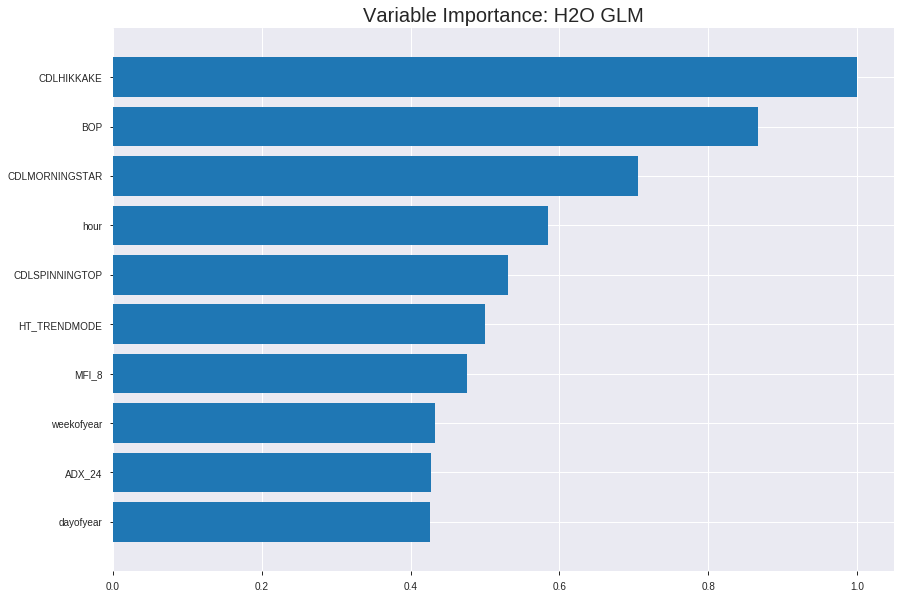

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_205931_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2410775170957837
RMSE: 0.49099645324155217
LogLoss: 0.6747601072687804
Null degrees of freedom: 1557
Residual degrees of freedom: 1507
Null deviance: 2158.8195441369685
Residual deviance: 2102.55249424952
AIC: 2204.55249424952
AUC: 0.611552484083365
pr_auc: 0.5883961840851437
Gini: 0.2231049681667301
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.40657511350195036: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      69   730   0.9136   (730.0/799.0)
1      23   736   0.0303   (23.0/759.0)
Total  92   1466  0.4833   (753.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.406575     0.661573  344
max f2                       0.345998     0.829327  383
max f0point5                 0.471924     0.572951  230
max accuracy                 0.500235     0.581515  171
max precision                0.784616     1         0
max recall                   0.345998     1         383
max specificity              0.784616     1         0
max absolute_mcc             0.439019     0.162129  296
max min_per_class_accuracy   0.486021     0.570487  203
max mean_per_class_accuracy  0.500235     0.578897  171

Gains/Lift Table: Avg response rate: 48.72 %, avg score: 48.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain        cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ----------  -----------------
    1        0.0102696                   0.625401           1.28294   1.28294            0.625            0.662428  0.625                       0.662428            0.0131752       0.0131752                  28.2938     28.2938
    2        0.0205392                   0.605287           1.53953   1.41123            0.75             0.614611  0.6875                      0.63852             0.0158103       0.0289855                  53.9526     41.1232
    3        0.0301669                   0.596949           1.64216   1.48493            0.8              0.600779  0.723404                    0.626475            0.0158103       0.0447958                  64.2161     48.4933
    4        0.0404365                   0.587035           1.41123   1.46621            0.6875           0.591285  0.714286                    0.617538            0.0144928       0.0592885                  41.1232     46.6215
    5        0.0500642                   0.579191           1.36847   1.44742            0.666667         0.582509  0.705128                    0.610801            0.0131752       0.0724638                  36.8467     44.7417
    6        0.100128                    0.558174           1.36847   1.40794            0.666667         0.56785   0.685897                    0.589326            0.0685112       0.140975                   36.8467     40.7942
    7        0.150193                    0.542285           1.2632    1.3597             0.615385         0.550407  0.662393                    0.576353            0.0632411       0.204216                   26.3201     35.9695
    8        0.200257                    0.531624           1.18425   1.31583            0.576923         0.537405  0.641026                    0.566616            0.0592885       0.263505                   18.4251     31.5834
    9        0.300385                    0.514412           1.06583   1.2325             0.519231         0.522891  0.600427                    0.552041            0.106719        0.370224                   6.58255     23.2498
    10       0.399872                    0.499607           1.08595   1.19604            0.529032         0.507274  0.582665                    0.540903            0.108037        0.478261                   8.5945      19.6036
    11       0.5                         0.485591           0.934242  1.14361            0.455128         0.492992  0.557125                    0.531308            0.0935441       0.571805                   -6.57579    14.361
    12       0.600128                    0.471799           1.06583   1.13063            0.519231         0.47879   0.550802                    0.522546            0.106719        0.678524                   6.58255     13.0632
    13       0.699615                    0.459026           0.847567  1.09038            0.412903         0.465952  0.531193                    0.514498            0.0843215       0.762846                   -15.2433    9.03797
    14       0.799743                    0.444293           1.00003   1.07907            0.487179         0.451911  0.525682                    0.506662            0.100132        0.862978                   0.00337826  7.90683
    15       0.899872                    0.425198           0.736867  1.04099            0.358974         0.435073  0.507133                    0.498697            0.0737813       0.936759                   -26.3133    4.09917
    16       1                           0.141706           0.6316    1                  0.307692         0.38351   0.487163    



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24733602298374088
RMSE: 0.49732888814520004
LogLoss: 0.687688413162503
Null degrees of freedom: 445
Residual degrees of freedom: 395
Null deviance: 620.533011844054
Residual deviance: 613.4180645409525
AIC: 715.4180645409525
AUC: 0.5457077459082806
pr_auc: 0.5808284712428452
Gini: 0.09141549181656128
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37973993241492265: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    202  0.9902   (202.0/204.0)
1      0    242  0        (0.0/242.0)
Total  2    444  0.4529   (202.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.37974      0.705539  397
max f2                       0.37974      0.856941  397
max f0point5                 0.47339      0.607948  315
max accuracy                 0.47339      0.567265  315
max precision                0.717397     1         0
max recall                   0.37974      1         397
max specificity              0.717397     1         0
max absolute_mcc             0.47339      0.104519  315
max min_per_class_accuracy   0.512959     0.529412  202
max mean_per_class_accuracy  0.508714     0.546224  215

Gains/Lift Table: Avg response rate: 54.26 %, avg score: 51.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.632186           1.10579   1.10579            0.6              0.660678  0.6                         0.660678            0.0123967       0.0123967                  10.5785   10.5785
    2        0.0201794                   0.625149           1.84298   1.43343            1                0.629695  0.777778                    0.646907            0.0165289       0.0289256                  84.2975   43.3425
    3        0.0313901                   0.613109           1.10579   1.31641            0.6              0.620887  0.714286                    0.637614            0.0123967       0.0413223                  10.5785   31.6411
    4        0.0403587                   0.601092           0.921488  1.22865            0.5              0.60738   0.666667                    0.630896            0.00826446      0.0495868                  -7.85124  22.865
    5        0.0515695                   0.59763            1.47438   1.28207            0.8              0.599126  0.695652                    0.623989            0.0165289       0.0661157                  47.438    28.207
    6        0.100897                    0.579131           0.753944  1.02388            0.409091         0.588107  0.555556                    0.606447            0.0371901       0.103306                   -24.6056  2.38751
    7        0.150224                    0.564806           1.50789   1.1828             0.818182         0.570719  0.641791                    0.594715            0.0743802       0.177686                   50.7889   18.2805
    8        0.201794                    0.55479            0.801294  1.08531            0.434783         0.559279  0.588889                    0.585659            0.0413223       0.219008                   -19.8706  8.53076
    9        0.300448                    0.539395           0.963373  1.04527            0.522727         0.546489  0.567164                    0.572798            0.0950413       0.31405                    -3.66266  4.52695
    10       0.401345                    0.527842           1.10579   1.06048            0.6              0.533708  0.575419                    0.562971            0.11157         0.42562                    10.5785   6.04829
    11       0.5                         0.513754           1.00526   1.04959            0.545455         0.521144  0.569507                    0.554718            0.0991736       0.524793                   0.52592   4.95868
    12       0.600897                    0.500794           1.10579   1.05902            0.6              0.506881  0.574627                    0.546686            0.11157         0.636364                   10.5785   5.90231
    13       0.699552                    0.488618           0.963373  1.04553            0.522727         0.494839  0.567308                    0.539374            0.0950413       0.731405                   -3.66266  4.5534
    14       0.800448                    0.474203           1.02388   1.0428             0.555556         0.481064  0.565826                    0.532024            0.103306        0.834711                   2.38751   4.28039
    15       0.899103                    0.451525           0.712059  1.00651            0.386364         0.465388  0.546135                    0.524712            0.0702479       0.904959                   -28.7941  0.651264
    16       1                           0.272911           0.941965  1                  0.511111         0.416833  0.542601                    0.513828           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 20:59:31  0.000 sec   2            4         51            1.37915           1.38686
    2019-08-26 20:59:31  0.021 sec   4            2.5       51            1.376             1.38482
    2019-08-26 20:59:31  0.033 sec   6            1.5       51            1.37183           1.38232
    2019-08-26 20:59:31  0.046 sec   8            0.95      51            1.3667            1.37963
    2019-08-26 20:59:32  0.058 sec   10           0.59      51            1.36092           1.37723
    2019-08-26 20:59:32  0.072 sec   12           0.37      51            1.355             1.3757
    2019-08-26 20:59:32  0.091 sec   14           0.23      51            1.34952           1.37538
    2019-08-26 20:59:32  0.107 sec   16           0.14      51            1.3449            1.37634
    2019-08-26 20:59:32  0.122 sec   18           0.088     51            1.34135           1.37828
    2019-08-26 20:59:32  0.141 sec   20           0.055     51            1.3388            1.38073
    2019-08-26 20:59:32  0.153 sec   22           0.034     51            1.33707           1.38328
    2019-08-26 20:59:32  0.173 sec   24           0.021     51            1.3359            1.3857

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.515695067264574)

('F1', 0.6804733727810652)

('auc', 0.4575684380032206)

('logloss', 0.714029599057052)

('mean_per_class_error', 0.4886876006441223)

('rmse', 0.5097295126705169)

('mse', 0.25982417608732267)

glm prediction progress: |████████████████████████████████████████████████| 100%


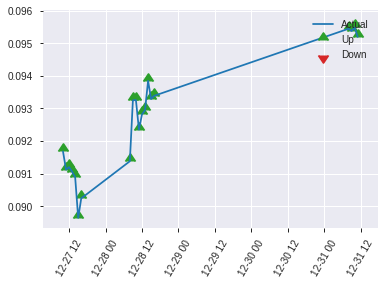


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25982417608732267
RMSE: 0.5097295126705169
LogLoss: 0.714029599057052
Null degrees of freedom: 222
Residual degrees of freedom: 172
Null deviance: 309.6501959015793
Residual deviance: 318.4572011794452
AIC: 420.4572011794452
AUC: 0.4575684380032206
pr_auc: 0.4834471318010396
Gini: -0.08486312399355878
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20902927398660034: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    108  1        (108.0/108.0)
1      0    115  0        (0.0/115.0)
Total  0    223  0.4843   (108.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.209029     0.680473  222
max f2                       0.209029     0.841874  222
max f0point5                 0.209029     0.571003  222
max accuracy                 0.440269     0.515695  220
max precision                0.574023     0.531646  78
max recall                   0.209029     1         222
max specificity              0.745725     0.990741  0
max absolute_mcc             0.535642     0.132394  137
max min_per_class_accuracy   0.556625     0.452174  109
max mean_per_class_accuracy  0.574023     0.511312  78

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 55.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.67348            0.646377  0.646377           0.333333         0.710377  0.333333                    0.710377            0.00869565      0.00869565                 -35.3623  -35.3623
    2        0.0224215                   0.661768           0         0.387826           0                0.662196  0.2                         0.691105            0               0.00869565                 -100      -61.2174
    3        0.0313901                   0.653141           0.969565  0.554037           0.5              0.657303  0.285714                    0.681447            0.00869565      0.0173913                  -3.04348  -44.5963
    4        0.0403587                   0.649843           1.93913   0.861836           1                0.652989  0.444444                    0.675123            0.0173913       0.0347826                  93.913    -13.8164
    5        0.0538117                   0.647585           1.29275   0.969565           0.666667         0.64855   0.5                         0.66848             0.0173913       0.0521739                  29.2754   -3.04348
    6        0.103139                    0.622129           0.705138  0.8431             0.363636         0.632299  0.434783                    0.651176            0.0347826       0.0869565                  -29.4862  -15.69
    7        0.152466                    0.601692           1.05771   0.912532           0.545455         0.61162   0.470588                    0.638378            0.0521739       0.13913                    5.77075   -8.7468
    8        0.201794                    0.594392           0.881423  0.904928           0.454545         0.598021  0.466667                    0.628513            0.0434783       0.182609                   -11.8577  -9.50725
    9        0.300448                    0.579317           1.23399   1.01298            0.636364         0.585303  0.522388                    0.614325            0.121739        0.304348                   23.3992   1.29786
    10       0.399103                    0.569825           0.881423  0.980459           0.454545         0.574443  0.505618                    0.604467            0.0869565       0.391304                   -11.8577  -1.95408
    11       0.502242                    0.555821           0.59017   0.900311           0.304348         0.562172  0.464286                    0.595781            0.0608696       0.452174                   -40.983   -9.96894
    12       0.600897                    0.537837           0.969565  0.911681           0.5              0.546454  0.470149                    0.587683            0.0956522       0.547826                   -3.04348  -8.83193
    13       0.699552                    0.527846           1.14585   0.944705           0.590909         0.532009  0.487179                    0.579831            0.113043        0.66087                    14.585    -5.52954
    14       0.798206                    0.508352           1.32213   0.991353           0.681818         0.519412  0.511236                    0.572364            0.130435        0.791304                   32.2134   -0.86468
    15       0.896861                    0.492335           0.881423  0.979261           0.454545         0.500498  0.505                       0.564458            0.0869565       0.878261                   -11.8577  -2.07391
    16       1                           0.209029           1.18034   1                  0.608696         0.454371  0.515695                    0.5531

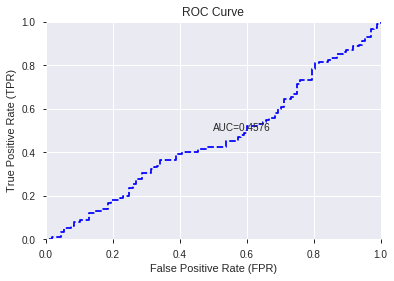

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


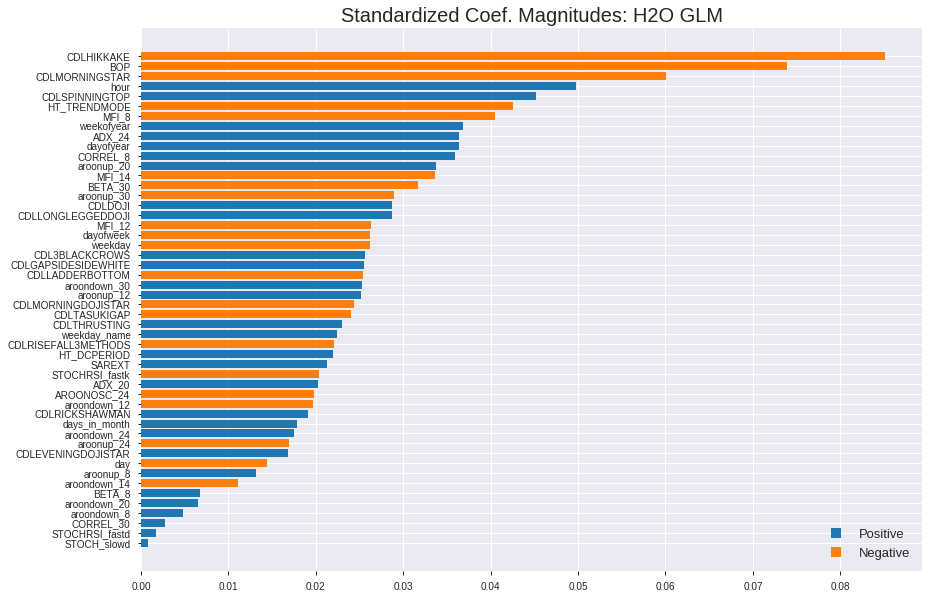

'log_likelihood'
--2019-08-26 20:59:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.32.84
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.32.84|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_205931_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_205931_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_afb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['CDLHIKKAKE',
 'BOP',
 'CDLMORNINGSTAR',
 'hour',
 'CDLSPINNINGTOP',
 'HT_TRENDMODE',
 'MFI_8',
 'weekofyear',
 'ADX_24',
 'dayofyear',
 'CORREL_8',
 'aroonup_20',
 'MFI_14',
 'BETA_30',
 'aroonup_30',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'MFI_12',
 'dayofweek',
 'weekday',
 'CDL3BLACKCROWS',
 'CDLGAPSIDESIDEWHITE',
 'CDLLADDERBOTTOM',
 'aroondown_30',
 'aroonup_12',
 'CDLMORNINGDOJISTAR',
 'CDLTASUKIGAP',
 'CDLTHRUSTING',
 'weekday_name',
 'CDLRISEFALL3METHODS',
 'HT_DCPERIOD',
 'SAREXT',
 'STOCHRSI_fastk',
 'ADX_20',
 'AROONOSC_24',
 'aroondown_12',
 'CDLRICKSHAWMAN',
 'days_in_month',
 'aroondown_24',
 'aroonup_24',
 'CDLEVENINGDOJISTAR',
 'day',
 'aroonup_8',
 'aroondown_14',
 'BETA_8',
 'aroondown_20',
 'aroondown_8',
 'CORREL_30',
 'STOCHRSI_fastd',
 'STOCH_slowd']

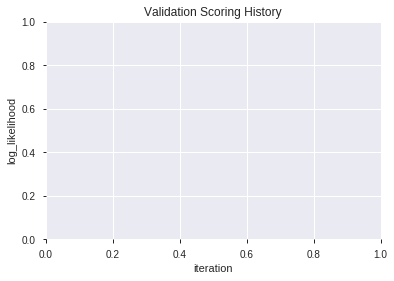

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190826_205943_model_7  0.538808  0.698440              0.485829  0.502461  0.252467
1               XGBoost_1_AutoML_20190826_205943  0.522061  0.708683              0.500000  0.507158  0.257210
2  XGBoost_grid_1_AutoML_20190826_205943_model_6  0.505072  0.711958              0.485829  0.508811  0.258888
3  XGBoost_grid_1_AutoML_20190826_205943_model_3  0.501127  0.712016              0.500000  0.508969  0.259050
4               XGBoost_3_AutoML_20190826_205943  0.489291  0.712200              0.485548  0.509142  0.259226
5  XGBoost_grid_1_AutoML_20190826_205943_model_1  0.487721  0.720300              0.500000  0.512705  0.262866
6  XGBoost_grid_1_AutoML_20190826_205943_model_5  0.480515  0.753154              0.490459  0.526469  0.277170
7  XGBoost_grid_1_AutoML_20190826_205943_model_4  0.475000  0.711341              0.500000  0.508733  0.258809
8  XGBoost_grid_1_AutoML_20190826_205943_model_2  0.460628  0.711183              0.485548  0.508781  0.258858
9               XGBoost_2_AutoML_20190826_205943  0.459823  0.722670              0.490177  0.513791  0.263981

variable  relative_importance  scaled_importance  percentage
0                 BOP           576.892090           1.000000    0.080329
1              BETA_8           430.780853           0.746727    0.059984
2             BETA_30           415.217346           0.719749    0.057817
3              ADX_20           342.595306           0.593864    0.047705
4              MFI_12           311.733673           0.540367    0.043407
5         STOCH_slowd           311.210388           0.539460    0.043334
6      STOCHRSI_fastd           303.519440           0.526129    0.042264
7      STOCHRSI_fastk           302.957367           0.525154    0.042185
8              MFI_14           295.885040           0.512895    0.041201
9                 day           277.340454           0.480749    0.038618
10             SAREXT           266.040527           0.461162    0.037045
11        HT_DCPERIOD           261.321869           0.452982    0.036388
12              MFI_8           255.018585           0.442056    0.035510
13          dayofyear           251.928452           0.436699    0.035080
14             ADX_24           229.781219           0.398309    0.031996
15        AROONOSC_24           225.378525           0.390677    0.031383
16       aroondown_30           200.213196           0.347055    0.027879
17         aroonup_30           195.578445           0.339021    0.027233
18               hour           166.878799           0.289272    0.023237
19         aroonup_20           160.927582           0.278956    0.022408
20       aroondown_12           130.141418           0.225591    0.018122
21         aroonup_12           122.402557           0.212176    0.017044
22          aroonup_8           116.128532           0.201300    0.016170
23          CORREL_30           113.265228           0.196337    0.015772
24       aroondown_24           112.864952           0.195643    0.015716
25       aroondown_20           110.654884           0.191812    0.015408
26        aroondown_8            95.105194           0.164858    0.013243
27         aroonup_24            91.195099           0.158080    0.012698
28       weekday_name            86.155838           0.149345    0.011997
29       aroondown_14            79.959785           0.138604    0.011134
30          dayofweek            72.875328           0.126324    0.010148
31         weekofyear            55.725883           0.096597    0.007760
32       HT_TRENDMODE            49.918655           0.086530    0.006951
33            weekday            39.563274           0.068580    0.005509
34         CDLHIKKAKE            38.010311           0.065888    0.005293
35      days_in_month            37.550377           0.065091    0.005229
36     CDLSPINNINGTOP            22.272532           0.038608    0.003101
37            CDLDOJI            13.347084           0.023136    0.001859
38     CDLRICKSHAWMAN             9.851219           0.017076    0.001372
39  CDLLONGLEGGEDDOJI             3.398250           0.005891    0.000473

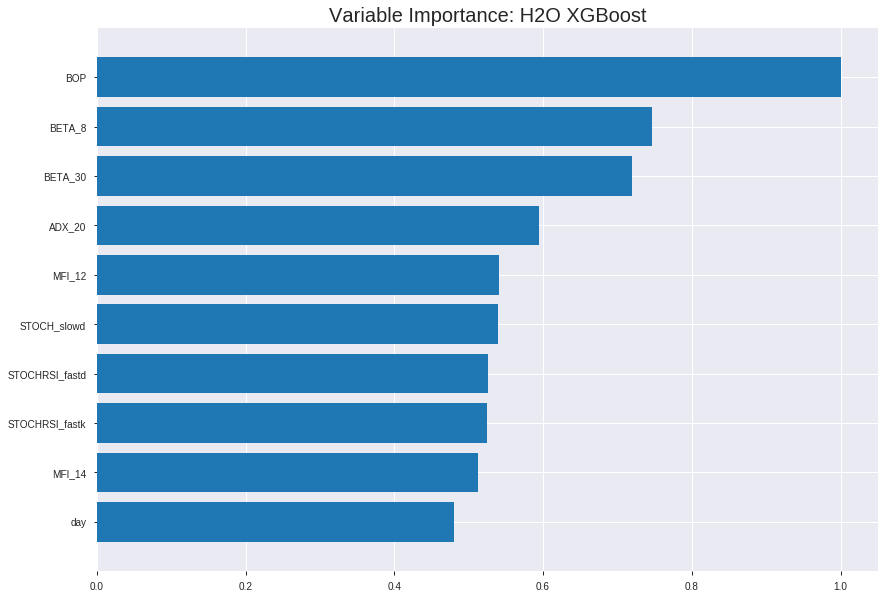

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190826_205943_model_7


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15316270562625875
RMSE: 0.3913600715789217
LogLoss: 0.49063204504879343
Mean Per-Class Error: 0.11096545253371726
AUC: 0.9573800254270407
pr_auc: 0.9554260157672281
Gini: 0.9147600508540814
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4955502599477768: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      716  83   0.1039   (83.0/799.0)
1      91   668  0.1199   (91.0/759.0)
Total  807  751  0.1117   (174.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.49555      0.884768  196
max f2                       0.390753     0.919018  267
max f0point5                 0.543948     0.906103  161
max accuracy                 0.502337     0.889602  191
max precision                0.822843     1         0
max recall                   0.331107     1         314
max specificity              0.822843     1         0
max absolute_mcc             0.502337     0.77942   191
max min_per_class_accuracy   0.491243     0.88274   199
max mean_per_class_accuracy  0.502337     0.889035  191

Gains/Lift Table: Avg response rate: 48.72 %, avg score: 48.74 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.76024            2.0527     2.0527             1                0.781121  1                           0.781121            0.0210804       0.0210804                  105.27    105.27
    2        0.0205392                   0.748603           2.0527     2.0527             1                0.753916  1                           0.767518            0.0210804       0.0421607                  105.27    105.27
    3        0.0301669                   0.736506           2.0527     2.0527             1                0.741757  1                           0.759297            0.0197628       0.0619236                  105.27    105.27
    4        0.0404365                   0.729229           2.0527     2.0527             1                0.732118  1                           0.752394            0.0210804       0.083004                   105.27    105.27
    5        0.0500642                   0.72153            2.0527     2.0527             1                0.725416  1                           0.747206            0.0197628       0.102767                   105.27    105.27
    6        0.100128                    0.690974           2.0527     2.0527             1                0.705168  1                           0.726187            0.102767        0.205534                   105.27    105.27
    7        0.150193                    0.666713           2.02638    2.04393            0.987179         0.677807  0.995726                    0.71006             0.101449        0.306983                   102.638   104.393
    8        0.200257                    0.643392           2.00007    2.03296            0.974359         0.654146  0.990385                    0.696082            0.100132        0.407115                   100.007   103.296
    9        0.300385                    0.592713           1.96059    2.00884            0.955128         0.620047  0.978632                    0.670737            0.196311        0.603426                   96.0593   100.884
    10       0.399872                    0.538125           1.73486    1.94068            0.845161         0.568031  0.945425                    0.645184            0.172596        0.776021                   73.4863   94.0676
    11       0.5                         0.483755           1.17109    1.78656            0.570513         0.511837  0.870347                    0.618481            0.11726         0.893281                   17.1092   78.6561
    12       0.600128                    0.428309           0.644759   1.59606            0.314103         0.45511   0.77754                     0.591223            0.0645586       0.957839                   -35.5241  59.6057
    13       0.699615                    0.375326           0.344324   1.41806            0.167742         0.401238  0.690826                    0.564207            0.0342556       0.992095                   -65.5676  41.8059
    14       0.799743                    0.334672           0.0657917  1.24875            0.0320513        0.354398  0.608347                    0.537939            0.00658762      0.998682                   -93.4208  24.8754
    15       0.899872                    0.290199           0.0131583  1.11127            0.00641026       0.314954  0.541369                    0.513127            0.00131752      1                          -98.6842  11.127
    16       1                           0.135092           0          1                  0                0.255871  0.487163                    0.4873



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25782306791277015
RMSE: 0.507762806744222
LogLoss: 0.7097418543318132
Mean Per-Class Error: 0.4698995300599579
AUC: 0.5181696645600389
pr_auc: 0.5624580491161912
Gini: 0.03633932912007776
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.25751814246177673: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    203  0.9951   (203.0/204.0)
1      0    242  0        (0.0/242.0)
Total  1    445  0.4552   (203.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.257518     0.704512  398
max f2                       0.257518     0.856334  398
max f0point5                 0.356898     0.603732  350
max accuracy                 0.356898     0.558296  350
max precision                0.775089     1         0
max recall                   0.257518     1         398
max specificity              0.775089     1         0
max absolute_mcc             0.729536     0.131761  7
max min_per_class_accuracy   0.51087      0.509804  197
max mean_per_class_accuracy  0.405548     0.5301    319

Gains/Lift Table: Avg response rate: 54.26 %, avg score: 50.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.758735           1.84298   1.84298            1                0.767271  1                           0.767271            0.0206612       0.0206612                  84.2975   84.2975
    2        0.0201794                   0.722761           1.84298   1.84298            1                0.740027  1                           0.755162            0.0165289       0.0371901                  84.2975   84.2975
    3        0.0313901                   0.697466           0         1.18477            0                0.71183   0.642857                    0.739686            0               0.0371901                  -100      18.477
    4        0.0403587                   0.692229           0.921488  1.12626            0.5              0.694603  0.611111                    0.729668            0.00826446      0.0454545                  -7.85124  12.6263
    5        0.0515695                   0.686921           0.73719   1.04168            0.4              0.689995  0.565217                    0.721043            0.00826446      0.053719                   -26.281   4.16816
    6        0.100897                    0.664784           0.837716  0.941965           0.454545         0.674877  0.511111                    0.698473            0.0413223       0.0950413                  -16.2284  -5.80349
    7        0.150224                    0.635012           0.921488  0.935241           0.5              0.648107  0.507463                    0.681935            0.0454545       0.140496                   -7.85124  -6.47589
    8        0.201794                    0.614265           0.961552  0.941965           0.521739         0.627081  0.511111                    0.667917            0.0495868       0.190083                   -3.84477  -5.80349
    9        0.300448                    0.572922           1.21469   1.03152            0.659091         0.595807  0.559701                    0.644239            0.119835        0.309917                   21.4688   3.1516
    10       0.401345                    0.545903           0.90101   0.998707           0.488889         0.556994  0.541899                    0.622306            0.0909091       0.400826                   -9.89899  -0.129277
    11       0.5                         0.511826           1.08903   1.01653            0.590909         0.528301  0.55157                     0.603758            0.107438        0.508264                   8.90308   1.65289
    12       0.600897                    0.481718           1.02388   1.01776            0.555556         0.495843  0.552239                    0.585638            0.103306        0.61157                    2.38751   1.77624
    13       0.699552                    0.440524           1.04715   1.02191            0.568182         0.462406  0.554487                    0.568259            0.103306        0.714876                   4.7145    2.19061
    14       0.800448                    0.409009           1.06483   1.02732            0.577778         0.422433  0.557423                    0.549878            0.107438        0.822314                   6.48301   2.73167
    15       0.899103                    0.354355           0.921488  1.0157             0.5              0.382205  0.551122                    0.53148             0.0909091       0.913223                   -7.85124  1.57045
    16       1                           0.219207           0.860055  1                  0.466667         0.310449  0.542601                    0.509178      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 20:59:56  8.211 sec   0                  0.5              0.693147            0.5             0                  1                0.512837                         0.5                0.693147              0.5               0                    1                  0.457399
    2019-08-26 20:59:56  8.346 sec   5                  0.484464         0.662475            0.806717        0.779              1.66782          0.283055                         0.498728           0.6906                0.537008          0.564573             1.47438            0.441704
    2019-08-26 20:59:56  8.444 sec   10                 0.471168         0.636794            0.862476        0.851452           2.0527           0.212452                         0.498418           0.689991              0.543723          0.575809             1.47438            0.44843
    2019-08-26 20:59:56  8.545 sec   15                 0.458749         0.613185            0.892586        0.884543           2.0527           0.188703                         0.498286           0.689765              0.548635          0.580893             1.47438            0.450673
    2019-08-26 20:59:56  8.641 sec   20                 0.446873         0.590937            0.90844         0.900307           2.0527           0.189345                         0.50037            0.69405               0.535489          0.568406             0.73719            0.457399
    2019-08-26 20:59:56  8.736 sec   25                 0.436463         0.571672            0.920658        0.914594           2.0527           0.165597                         0.501153           0.695637              0.531215          0.560728             1.10579            0.441704
    2019-08-26 20:59:56  8.844 sec   30                 0.425588         0.551779            0.932249        0.929407           2.0527           0.15276                          0.503293           0.70009               0.524773          0.559017             1.10579            0.457399
    2019-08-26 20:59:56  8.943 sec   35                 0.41641          0.535161            0.939839        0.936195           2.0527           0.154044                         0.503686           0.701037              0.526971          0.563608             1.47438            0.457399
    2019-08-26 20:59:56  9.041 sec   40                 0.407383         0.518953            0.945792        0.940585           2.0527           0.134788                         0.506723           0.707366              0.515668          0.563583             1.84298            0.452915
    2019-08-26 20:59:56  9.152 sec   45                 0.398969         0.504107            0.952866        0.950378           2.0527           0.120668                         0.508749           0.711707              0.512397          0.5605               1.84298            0.455157
    2019-08-26 20:59:57  9.253 sec   50                 0.39136          0.490632            0.95738         0.955426           2.0527           0.111682                         0.507763           0.709742              0.51817           0.562458             1.84298            0.455157

Variable Importances: 


variable           relative_importance    scaled_importance      percentage
-----------------  ---------------------  ---------------------  ---------------------
BOP                576.89208984375        1.0                    0.08032934857094307
BETA_8             430.7808532714844      0.7467269197401553     0.059984087023113565
BETA_30            415.21734619140625     0.719748725110561      0.05781694622289813
ADX_20             342.5953063964844      0.593863761399945      0.04770468909314755
MFI_12             311.7336730957031      0.5403673903383482     0.04340736045486003
---                ---                    ---                    ---
days_in_month      37.550376892089844     0.06509081603504094    0.005228702850045934
CDLSPINNINGTOP     22.272531509399414     0.038607794943820224   0.003101339017597628
CDLDOJI            13.347084045410156     0.02313618834507713    0.001858514938174691
CDLRICKSHAWMAN     9.851219177246094      0.017076363761399944   0.0013717331769137165
CDLLONGLEGGEDDOJI  3.398250102996826      0.0058906165690662095  0.0004731893916742923


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5560538116591929)

('F1', 0.6846846846846847)

('auc', 0.5388083735909823)

('logloss', 0.6984399428856151)

('mean_per_class_error', 0.45072463768115945)

('rmse', 0.5024611342014695)

('mse', 0.2524671913830272)

xgboost prediction progress: |████████████████████████████████████████████| 100%


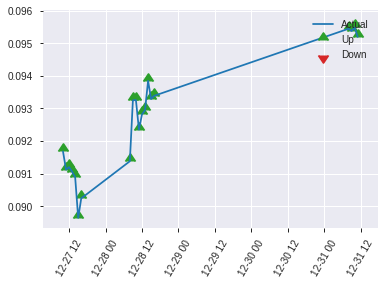


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2524671913830272
RMSE: 0.5024611342014695
LogLoss: 0.6984399428856151
Mean Per-Class Error: 0.45072463768115945
AUC: 0.5388083735909823
pr_auc: 0.5615863024620307
Gini: 0.07761674718196465
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3187050223350525: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    104  0.963    (104.0/108.0)
1      1    114  0.0087   (1.0/115.0)
Total  5    218  0.4709   (105.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.318705     0.684685  217
max f2                       0.269062     0.841874  222
max f0point5                 0.465785     0.582781  159
max accuracy                 0.465785     0.556054  159
max precision                0.732973     1         0
max recall                   0.269062     1         222
max specificity              0.732973     1         0
max absolute_mcc             0.696264     0.151575  11
max min_per_class_accuracy   0.526803     0.518519  111
max mean_per_class_accuracy  0.465785     0.549275  159

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 52.85 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.723195           1.29275   1.29275            0.666667         0.727224  0.666667                    0.727224            0.0173913       0.0173913                  29.2754   29.2754
    2        0.0224215                   0.718991           1.93913   1.5513             1                0.720931  0.8                         0.724707            0.0173913       0.0347826                  93.913    55.1304
    3        0.0313901                   0.711016           1.93913   1.66211            1                0.716158  0.857143                    0.722264            0.0173913       0.0521739                  93.913    66.2112
    4        0.0403587                   0.698531           0.969565  1.50821            0.5              0.706339  0.777778                    0.718725            0.00869565      0.0608696                  -3.04348  50.8213
    5        0.0538117                   0.695642           1.93913   1.61594            1                0.696997  0.833333                    0.713293            0.026087        0.0869565                  93.913    61.5942
    6        0.103139                    0.659027           0.528854  1.09603            0.272727         0.676798  0.565217                    0.695839            0.026087        0.113043                   -47.1146  9.60302
    7        0.152466                    0.640508           1.05771   1.08363            0.545455         0.6504    0.558824                    0.681138            0.0521739       0.165217                   5.77075   8.36317
    8        0.201794                    0.623127           1.05771   1.07729            0.545455         0.631978  0.555556                    0.669121            0.0521739       0.217391                   5.77075   7.72947
    9        0.300448                    0.582724           1.14585   1.09981            0.590909         0.605464  0.567164                    0.648219            0.113043        0.330435                   14.585    9.98053
    10       0.399103                    0.555831           0.881423  1.04582            0.454545         0.567205  0.539326                    0.628193            0.0869565       0.417391                   -11.8577  4.58232
    11       0.502242                    0.526803           1.01172   1.03882            0.521739         0.541903  0.535714                    0.610473            0.104348        0.521739                   1.17202   3.88199
    12       0.600897                    0.502402           1.05771   1.04192            0.545455         0.512838  0.537313                    0.594443            0.104348        0.626087                   5.77075   4.19208
    13       0.699552                    0.47117            1.05771   1.04415            0.545455         0.486359  0.538462                    0.5792              0.104348        0.730435                   5.77075   4.41472
    14       0.798206                    0.439397           0.881423  1.02404            0.454545         0.454158  0.52809                     0.563746            0.0869565       0.817391                   -11.8577  2.40352
    15       0.896861                    0.40024            0.793281  0.998652           0.409091         0.423358  0.515                       0.548303            0.0782609       0.895652                   -20.6719  -0.134783
    16       1                           0.269062           1.01172   1                  0.521739         0.355881  0.515695                    0.528457       

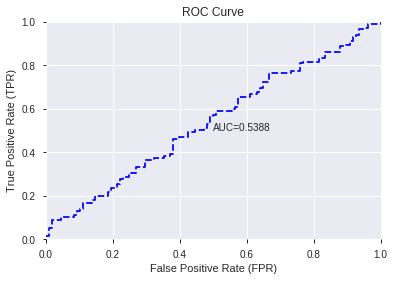

This function is available for GLM models only


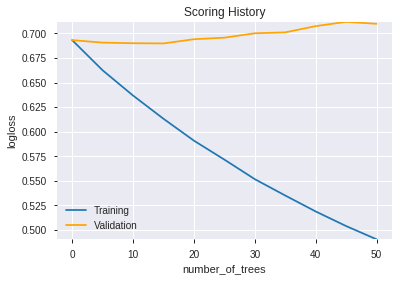

--2019-08-26 21:00:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.97.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.97.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190826_205943_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190826_205943_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_afb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'BETA_8',
 'BETA_30',
 'ADX_20',
 'MFI_12',
 'STOCH_slowd',
 'STOCHRSI_fastd',
 'STOCHRSI_fastk',
 'MFI_14',
 'day',
 'SAREXT',
 'HT_DCPERIOD',
 'MFI_8',
 'dayofyear',
 'ADX_24',
 'AROONOSC_24',
 'aroondown_30',
 'aroonup_30',
 'hour',
 'aroonup_20',
 'aroondown_12',
 'aroonup_12',
 'aroonup_8',
 'CORREL_30',
 'aroondown_24',
 'aroondown_20',
 'aroondown_8',
 'aroonup_24',
 'weekday_name',
 'aroondown_14',
 'dayofweek',
 'weekofyear',
 'HT_TRENDMODE',
 'weekday',
 'CDLHIKKAKE',
 'days_in_month',
 'CDLSPINNINGTOP',
 'CDLDOJI',
 'CDLRICKSHAWMAN',
 'CDLLONGLEGGEDDOJI']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12  13 926] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_210011_model_6  0.527617  0.694369              0.490459  0.500611  0.250611
1  DeepLearning_grid_1_AutoML_20190826_210011_model_3  0.511272  0.728035              0.495370  0.515383  0.265619
2  DeepLearning_grid_1_AutoML_20190826_210011_model_4  0.502496  1.148513              0.500000  0.600218  0.360262
3  DeepLearning_grid_1_AutoML_20190826_210011_model_8  0.500000  0.692832              0.500000  0.499843  0.249843
4  DeepLearning_grid_1_AutoML_20190826_210011_model_2  0.492110  0.701197              0.500000  0.503928  0.253943
5  DeepLearning_grid_1_AutoML_20190826_210011_model_1  0.467874  2.936378              0.495370  0.680899  0.463623
6  DeepLearning_grid_1_AutoML_20190826_210011_model_7  0.467633  0.755192              0.495370  0.525582  0.276237
7  DeepLearning_grid_1_AutoML_20190826_210011_model_5  0.461675  0.694714              0.500000  0.500780  0.250781
8  DeepLearning_grid_1_AutoML_20190826_210011_model_9  0.421659  0.693578              0.500000  0.500215  0.250215
9               DeepLearning_1_AutoML_20190826_210011  0.421337  1.038172              0.470813  0.591595  0.349985

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.001211
1               STOCHRSI_fastk             0.979356           0.979356    0.001186
2                          day             0.945335           0.945335    0.001145
3                 HT_TRENDMODE             0.942476           0.942476    0.001142
4                    dayofweek             0.939085           0.939085    0.001138
...                        ...                  ...                ...         ...
1032  BBANDS_middleband_20_2_5             0.705419           0.705419    0.000854
1033               CDLDOJISTAR             0.699094           0.699094    0.000847
1034               CDL3OUTSIDE             0.694255           0.694255    0.000841
1035              CDLENGULFING             0.693752           0.693752    0.000840
1036                 CDLHARAMI             0.686008           0.686008    0.000831

[1037 rows x 4 columns]

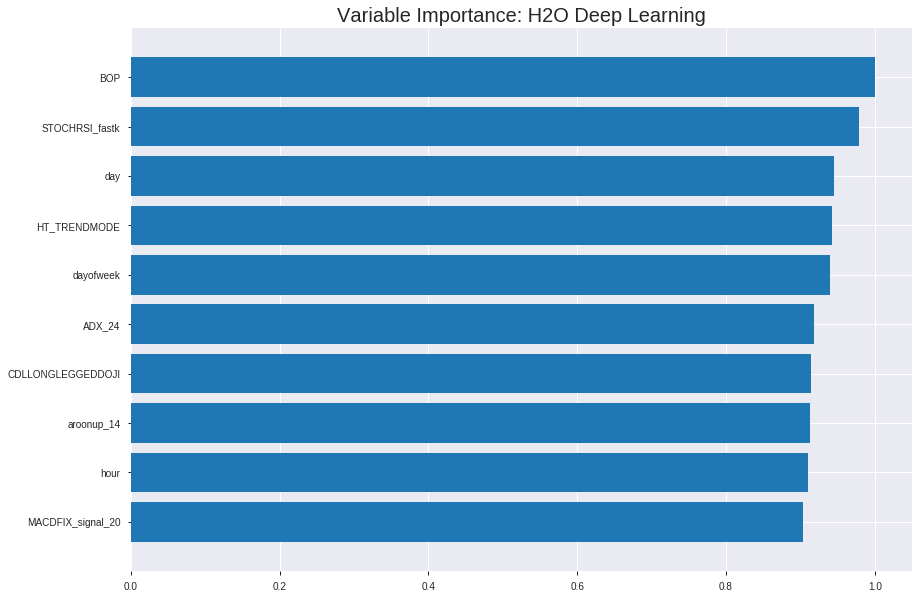

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_210011_model_6


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24748361515117462
RMSE: 0.49747725088809297
LogLoss: 0.6878324525761165
Mean Per-Class Error: 0.4602970445599819
AUC: 0.547853789568977
pr_auc: 0.5472342259631673
Gini: 0.09570757913795402
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4499633471463346: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      37   762   0.9537   (762.0/799.0)
1      10   749   0.0132   (10.0/759.0)
Total  47   1511  0.4955   (772.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.449963     0.659912  356
max f2                       0.316601     0.82715   388
max f0point5                 0.457541     0.551688  330
max accuracy                 0.47846      0.54172   163
max precision                0.846221     1         0
max recall                   0.220202     1         395
max specificity              0.846221     1         0
max absolute_mcc             0.500717     0.111326  52
max min_per_class_accuracy   0.477427     0.525692  177
max mean_per_class_accuracy  0.47846      0.539703  163

Gains/Lift Table: Avg response rate: 48.72 %, avg score: 47.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.519028           1.79611   1.79611            0.875            0.571486  0.875                       0.571486            0.0184453       0.0184453                  79.6113   79.6113
    2        0.0205392                   0.510277           1.41123   1.60367            0.6875           0.514242  0.78125                     0.542864            0.0144928       0.0329381                  41.1232   60.3673
    3        0.0301669                   0.505752           1.50531   1.57228            0.733333         0.507308  0.765957                    0.531516            0.0144928       0.0474308                  50.5314   57.2282
    4        0.0404365                   0.501106           1.41123   1.53138            0.6875           0.502909  0.746032                    0.524251            0.0144928       0.0619236                  41.1232   53.138
    5        0.0500642                   0.498121           0.547387  1.34215            0.266667         0.49956   0.653846                    0.519503            0.00527009      0.0671937                  -45.2613  34.2151
    6        0.100128                    0.486309           1.1053    1.22373            0.538462         0.49168   0.596154                    0.505591            0.055336        0.12253                    10.53     22.3726
    7        0.233633                    0.482465           0.986875  1.08838            0.480769         0.482825  0.53022                     0.492582            0.131752        0.254282                   -1.31246  8.83826
    8        0.300385                    0.479984           1.12504   1.09653            0.548077         0.481044  0.534188                    0.490018            0.0750988       0.329381                   12.5038   9.65283
    9        0.399872                    0.478633           1.0727    1.0906             0.522581         0.479304  0.5313                      0.487352            0.106719        0.4361                     7.27018   9.06003
    10       0.5                         0.477324           0.921084  1.05665            0.448718         0.478043  0.514763                    0.485488            0.0922266       0.528327                   -7.89163  5.66535
    11       0.600128                    0.474966           1.02635   1.0516             0.5              0.476166  0.512299                    0.483933            0.102767        0.631094                   2.63505   5.15976
    12       0.699615                    0.472989           0.887297  1.02823            0.432258         0.473972  0.500917                    0.482516            0.088274        0.719368                   -11.2703  2.82337
    13       0.799743                    0.4702             0.986875  1.02306            0.480769         0.471777  0.498395                    0.481172            0.0988142       0.818182                   -1.31246  2.30556
    14       0.899872                    0.463202           0.973717  1.01757            0.474359         0.466988  0.49572                     0.479593            0.0974967       0.915679                   -2.62829  1.75657
    15       1                           0.183134           0.842134  1                  0.410256         0.427726  0.487163                    0.4744              0.0843215       1                          -15.7866  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25098485262785053
RMSE: 0.5009838845989465
LogLoss: 0.695107235663771
Mean Per-Class Error: 0.44931939718035974
AUC: 0.5475409171933235
pr_auc: 0.5777963842628312
Gini: 0.09508183438664708
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4598450982267374: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    201  0.9853   (201.0/204.0)
1      1    241  0.0041   (1.0/242.0)
Total  4    442  0.4529   (202.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.459845     0.704678  395
max f2                       0.45822      0.856334  398
max f0point5                 0.47193      0.610034  334
max accuracy                 0.47193      0.569507  334
max precision                0.601675     1         0
max recall                   0.45822      1         398
max specificity              0.601675     1         0
max absolute_mcc             0.47193      0.111391  334
max min_per_class_accuracy   0.478154     0.533058  190
max mean_per_class_accuracy  0.47612      0.550681  260

Gains/Lift Table: Avg response rate: 54.26 %, avg score: 48.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.536151           1.84298   1.84298            1                0.570691  1                           0.570691            0.0206612       0.0206612                  84.2975   84.2975
    2        0.0201794                   0.519954           0.460744  1.22865            0.25             0.528187  0.666667                    0.5518              0.00413223      0.0247934                  -53.9256  22.865
    3        0.0313901                   0.513147           1.84298   1.44805            1                0.515527  0.785714                    0.538846            0.0206612       0.0454545                  84.2975   44.8052
    4        0.0403587                   0.509257           0.460744  1.22865            0.25             0.511579  0.666667                    0.532787            0.00413223      0.0495868                  -53.9256  22.865
    5        0.0515695                   0.508238           0         0.961552           0                0.508722  0.521739                    0.527555            0               0.0495868                  -100      -3.84477
    6        0.100897                    0.497865           1.25657   1.10579            0.681818         0.502787  0.6                         0.515446            0.0619835       0.11157                    25.6574   10.5785
    7        0.150224                    0.49085            0.837716  1.01776            0.454545         0.494855  0.552239                    0.508685            0.0413223       0.152893                   -16.2284  1.77624
    8        0.201794                    0.485881           0.961552  1.0034             0.521739         0.488125  0.544444                    0.503431            0.0495868       0.202479                   -3.84477  0.339761
    9        0.302691                    0.482465           1.22865   1.07848            0.666667         0.483275  0.585185                    0.496712            0.123967        0.326446                   22.865    7.84818
    10       0.401345                    0.479448           0.879602  1.0296             0.477273         0.480508  0.558659                    0.492729            0.0867769       0.413223                   -12.0398  2.95951
    11       0.5                         0.478072           1.21469   1.06612            0.659091         0.478677  0.578475                    0.489956            0.119835        0.533058                   21.4688   6.61157
    12       0.600897                    0.476994           1.06483   1.0659             0.577778         0.477493  0.578358                    0.487864            0.107438        0.640496                   6.48301   6.58998
    13       0.699552                    0.475798           1.04715   1.06325            0.568182         0.476412  0.576923                    0.486249            0.103306        0.743802                   4.7145    6.32549
    14       0.800448                    0.472939           0.860055  1.03764            0.466667         0.474835  0.563025                    0.48481             0.0867769       0.830579                   -13.9945  3.76415
    15       0.899103                    0.470219           0.921488  1.0249             0.5              0.471716  0.55611                     0.483373            0.0909091       0.921488                   -7.85124  2.48964
    16       1                           0.455865           0.778145  1                  0.422222         0.466191  0.542601                    0.48164          


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 21:08:47  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 21:08:49  4 min 35.080 sec  321 obs/sec       0.335687  1             523        0.663681         1.95396             -0.763054      0.491204        0.454235           0.513175         0.512837                         0.612464           1.17288               -0.511421        0.502532          0.537661             0                  0.457399
    2019-08-26 21:09:12  4 min 58.514 sec  430 obs/sec       6.31515   19            9839       0.537202         0.833234            -0.155104      0.508968        0.486051           0.898057         0.504493                         0.501504           0.696706              -0.0133821       0.523608          0.559866             1.10579            0.457399
    2019-08-26 21:09:35  5 min 21.517 sec  464 obs/sec       13.0064   39            20264      0.497477         0.687832            0.00941259     0.547854        0.547234           1.79611          0.495507                         0.500984           0.695107              -0.0112806       0.547541          0.577796             1.84298            0.452915
    2019-08-26 21:09:58  5 min 44.116 sec  492 obs/sec       20.2497   61            31549      0.495708         0.683867            0.0164459      0.561639        0.574005           1.53953          0.48267                          0.503533           0.700787              -0.0215999       0.475622          0.52332              1.10579            0.452915
    2019-08-26 21:10:20  6 min  6.526 sec  511 obs/sec       27.6521   83            43082      0.492041         0.676118            0.0309427      0.588065        0.605994           2.0527           0.471117                         0.507839           0.712144              -0.0391459       0.487046          0.534461             1.10579            0.455157
    2019-08-26 21:10:43  6 min 29.379 sec  534 obs/sec       35.975    108           56049      0.491572         0.674821            0.032791       0.59624         0.618219           2.0527           0.471117                         0.503315           0.701269              -0.020713        0.479268          0.542979             1.84298            0.457399
    2019-08-26 21:11:06  6 min 53.261 sec  552 obs/sec       44.3819   133           69147      0.488534         0.667131            0.044707       0.603943        0.619431           2.0527           0.458922                         0.520184           0.751616              -0.090282        0.482276          0.537557             1.47438            0.457399
    2019-08-26 21:11:09  6 min 55.540 sec  552 obs/sec       44.3819   133           69147      0.497477         0.687832            0.00941259     0.547854        0.547234           1.79611          0.495507                         0.500984           0.695107              -0.0112806       0.547541          0.577796             1.84298            0.452915

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.0012113008291308003
STOCHRSI_fastk            0.97935551404953       0.97935551404953     0.0011862941461820169
day                       0.9453350305557251     0.9453350305557251   0.0011450851063185402
HT_TRENDMODE              0.9424755573272705     0.9424755573272705   0.0011416214240260359
dayofweek                 0.9390851855278015     0.9390851855278015   0.0011375146638542774
---                       ---                    ---                  ---
BBANDS_middleband_20_2_5  0.7054191827774048     0.7054191827774048   0.0008544748409830419
CDLDOJISTAR               0.6990935802459717     0.6990935802459717   0.0008468126333919651
CDL3OUTSIDE               0.6942552924156189     0.6942552924156189   0.0008409520113314854
CDLENGULFING              0.6937519907951355     0.6937519907951355   0.000840342361661291
CDLHARAMI                 0.6860080361366272     0.6860080361366272   0.0008309621029626885


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5426008968609866)

('F1', 0.6826347305389221)

('auc', 0.5276167471819646)

('logloss', 0.694369353497007)

('mean_per_class_error', 0.45921900161030593)

('rmse', 0.5006108859181605)

('mse', 0.2506112590997655)

deeplearning prediction progress: |███████████████████████████████████████| 100%


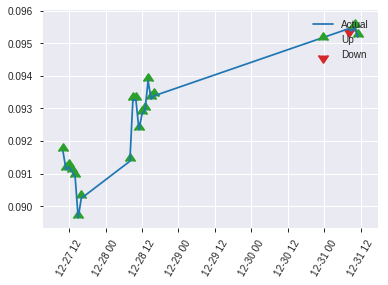


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2506112590997655
RMSE: 0.5006108859181605
LogLoss: 0.694369353497007
Mean Per-Class Error: 0.45921900161030593
AUC: 0.5276167471819646
pr_auc: 0.5655394004739008
Gini: 0.055233494363929214
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4601756681902558: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    105  0.9722   (105.0/108.0)
1      1    114  0.0087   (1.0/115.0)
Total  4    219  0.4753   (106.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.460176     0.682635  218
max f2                       0.436372     0.841874  222
max f0point5                 0.475504     0.579793  188
max accuracy                 0.475581     0.542601  186
max precision                0.49727      1         0
max recall                   0.436372     1         222
max specificity              0.49727      1         0
max absolute_mcc             0.491213     0.174456  6
max min_per_class_accuracy   0.478635     0.527778  111
max mean_per_class_accuracy  0.480043     0.540781  60

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 47.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.492483           1.93913   1.93913            1                0.495081  1                           0.495081            0.026087        0.026087                   93.913    93.913
    2        0.0224215                   0.491732           1.93913   1.93913            1                0.491887  1                           0.493804            0.0173913       0.0434783                  93.913    93.913
    3        0.0313901                   0.491135           1.93913   1.93913            1                0.491393  1                           0.493115            0.0173913       0.0608696                  93.913    93.913
    4        0.0403587                   0.490619           0         1.50821            0                0.490874  0.777778                    0.492617            0               0.0608696                  -100      50.8213
    5        0.0538117                   0.49027            0.646377  1.29275            0.333333         0.490423  0.666667                    0.492069            0.00869565      0.0695652                  -35.3623  29.2754
    6        0.103139                    0.482211           1.23399   1.26465            0.636364         0.485013  0.652174                    0.488694            0.0608696       0.130435                   23.3992   26.465
    7        0.152466                    0.48077            0.705138  1.08363            0.363636         0.481539  0.558824                    0.486379            0.0347826       0.165217                   -29.4862  8.36317
    8        0.201794                    0.480459           1.05771   1.07729            0.545455         0.480608  0.555556                    0.484968            0.0521739       0.217391                   5.77075   7.72947
    9        0.300448                    0.479766           1.14585   1.09981            0.590909         0.480145  0.567164                    0.483385            0.113043        0.330435                   14.585    9.98053
    10       0.399103                    0.479183           0.793281  1.02404            0.409091         0.479487  0.52809                     0.482421            0.0782609       0.408696                   -20.6719  2.40352
    11       0.502242                    0.478635           1.18034   1.05613            0.608696         0.478873  0.544643                    0.481693            0.121739        0.530435                   18.034    5.61335
    12       0.600897                    0.477855           0.793281  1.01298            0.409091         0.478285  0.522388                    0.481133            0.0782609       0.608696                   -20.6719  1.29786
    13       0.699552                    0.476808           0.969565  1.00686            0.5              0.477327  0.519231                    0.480596            0.0956522       0.704348                   -3.04348  0.685619
    14       0.798206                    0.47617            1.05771   1.01314            0.545455         0.47648   0.522472                    0.480087            0.104348        0.808696                   5.77075   1.31412
    15       0.896861                    0.474326           1.05771   1.01804            0.545455         0.475487  0.525                       0.479581            0.104348        0.913043                   5.77075   1.80435
    16       1                           0.436372           0.8431    1                  0.434783         0.46538   0.515695                    0.478117            

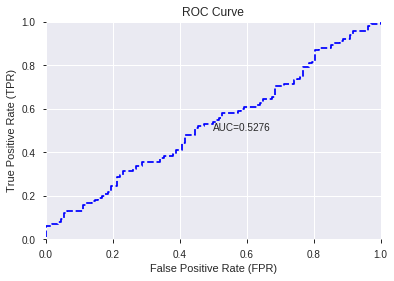

This function is available for GLM models only


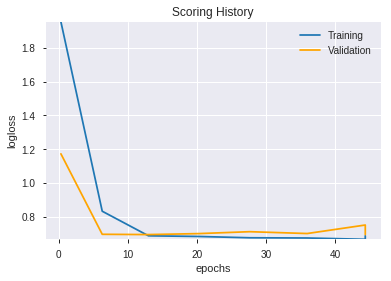

--2019-08-26 21:21:15--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.18.96
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.18.96|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_210011_model_6',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_210011_model_6',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_afb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'STOCHRSI_fastk',
 'day',
 'HT_TRENDMODE',
 'dayofweek',
 'ADX_24',
 'CDLLONGLEGGEDDOJI',
 'aroonup_14',
 'hour',
 'MACDFIX_signal_20',
 'days_in_month',
 'aroonup_30',
 'ADX_8',
 'BETA_20',
 'AD',
 'LINEARREG_SLOPE_8',
 'CDLDOJI',
 'CDLEVENINGDOJISTAR',
 'Volume',
 'CORREL_30',
 'CCI_12',
 'DX_8',
 'aroondown_30',
 'ADXR_14',
 'aroondown_12',
 'CDLEVENINGSTAR',
 'weekday',
 'BETA_30',
 'PLUS_DM_14',
 'DX_30',
 'aroonup_8',
 'CMO_8',
 'aroondown_14',
 'PLUS_DM_12',
 'weekday_name',
 'MFI_8',
 'BETA_24',
 'NATR_24',
 'PLUS_DM_20',
 'STDDEV_24',
 'MOM_8',
 'CORREL_8',
 'PLUS_DM_30',
 'DX_14',
 'SAREXT',
 'weekofyear',
 'ADX_12',
 'LN',
 'PLUS_DM_8',
 'ROC_8',
 'ADX_14',
 'ROCR100_20',
 'NATR_30',
 'STOCHRSI_fastd',
 'dayofyear',
 'MA_20_5',
 'MINMAX_min_8',
 'aroonup_24',
 'ATR_20',
 'SUB',
 'MACDEXT_signal',
 'BBANDS_upperband_14_6_2',
 'AROONOSC_30',
 'CDLMORNINGSTAR',
 'ADX_20',
 'MACDFIX_signal_8',
 'MINUS_DM_30',
 'CCI_8',
 'ADXR_8',
 'BBANDS_middleband_12_0_2',
 'PPO',
 'B

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190826_212122_model_1  0.471739  0.698619              0.495089  0.502715  0.252722

variable  relative_importance  scaled_importance    percentage
0                   CDLHIKKAKE         3.020141e-02           1.000000  1.967038e-02
1               CDLMORNINGSTAR         2.080761e-02           0.688962  1.355214e-02
2                          BOP         1.989009e-02           0.658581  1.295455e-02
3                  CDLMARUBOZU         1.880905e-02           0.622787  1.225046e-02
4              CDLHOMINGPIGEON         1.682225e-02           0.557002  1.095645e-02
...                        ...                  ...                ...           ...
1032                       Low         3.935772e-06           0.000130  2.563394e-06
1033  BBANDS_middleband_24_0_4         2.794785e-06           0.000093  1.820262e-06
1034    BBANDS_lowerband_8_4_5         2.733536e-06           0.000091  1.780370e-06
1035  BBANDS_middleband_24_0_5         2.141358e-06           0.000071  1.394681e-06
1036    BBANDS_upperband_8_8_3         1.070234e-07           0.000004  6.970509e-08

[1037 rows x 4 columns]

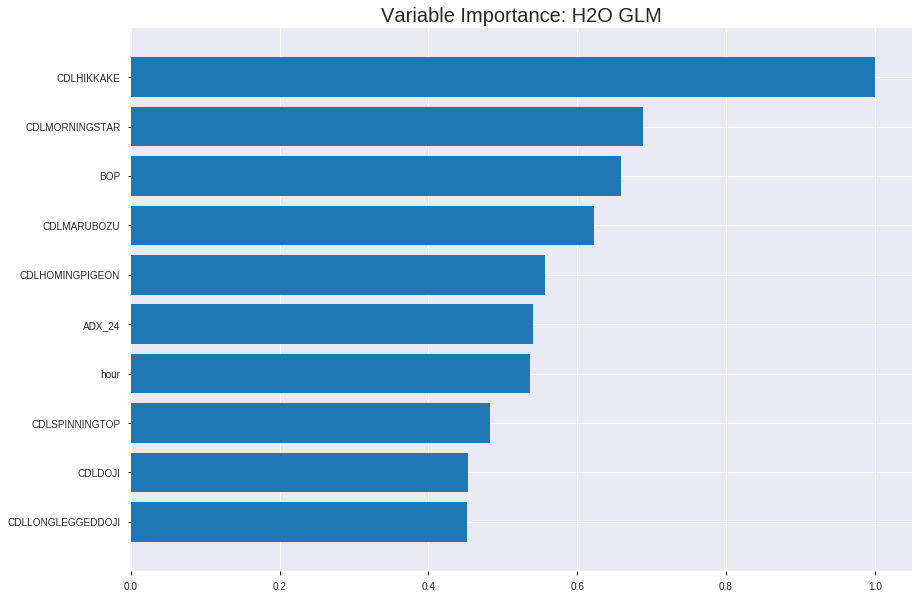

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_212122_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24232754167133697
RMSE: 0.49226775404380996
LogLoss: 0.6776489373053645
Null degrees of freedom: 1557
Residual degrees of freedom: 520
Null deviance: 2158.8195441369685
Residual deviance: 2111.5540886435156
AIC: 4187.554088643516
AUC: 0.6195631561850204
pr_auc: 0.5939438761362064
Gini: 0.2391263123700409
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4175930749007044: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      68   731   0.9149   (731.0/799.0)
1      12   747   0.0158   (12.0/759.0)
Total  80   1478  0.4769   (743.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.417593     0.667859  353
max f2                       0.413801     0.830205  358
max f0point5                 0.474756     0.581784  235
max accuracy                 0.504728     0.587291  151
max precision                0.641778     1         0
max recall                   0.35758      1         394
max specificity              0.641778     1         0
max absolute_mcc             0.474756     0.178413  235
max min_per_class_accuracy   0.490088     0.571805  193
max mean_per_class_accuracy  0.474756     0.585328  235

Gains/Lift Table: Avg response rate: 48.72 %, avg score: 48.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.577828           1.79611   1.79611            0.875            0.591525  0.875                       0.591525            0.0184453       0.0184453                  79.6113   79.6113
    2        0.0205392                   0.568649           1.41123   1.60367            0.6875           0.573385  0.78125                     0.582455            0.0144928       0.0329381                  41.1232   60.3673
    3        0.0301669                   0.561226           0.82108   1.35391            0.4              0.563883  0.659574                    0.576527            0.00790514      0.0408432                  -17.892   35.3909
    4        0.0404365                   0.55464            1.28294   1.33588            0.625            0.557162  0.650794                    0.571609            0.0131752       0.0540184                  28.2938   33.5885
    5        0.0500642                   0.551349           1.23162   1.31583            0.6              0.553074  0.641026                    0.568045            0.0118577       0.0658762                  23.1621   31.5834
    6        0.100128                    0.538304           1.44742   1.38163            0.705128         0.54508   0.673077                    0.556562            0.0724638       0.13834                    44.7417   38.1626
    7        0.150193                    0.529288           1.2632    1.34215            0.615385         0.533736  0.653846                    0.548954            0.0632411       0.201581                   26.3201   34.2151
    8        0.200257                    0.521111           1.21057   1.30925            0.589744         0.524834  0.637821                    0.542924            0.0606061       0.262187                   21.0567   30.9255
    9        0.300385                    0.50974            1.14478   1.25443            0.557692         0.515137  0.611111                    0.533661            0.114625        0.376812                   14.4776   25.4428
    10       0.399872                    0.500032           1.04622   1.20263            0.509677         0.505159  0.585875                    0.52657             0.104084        0.480896                   4.62153   20.2626
    11       0.5                         0.489702           0.9474    1.15152            0.461538         0.494731  0.560976                    0.520194            0.0948617       0.575758                   -5.25996  15.1515
    12       0.600128                    0.479945           1.1053    1.1438             0.538462         0.484747  0.557219                    0.51428             0.110672        0.68643                    10.53     14.3804
    13       0.699615                    0.46755            0.887297  1.10733            0.432258         0.474005  0.53945                     0.508553            0.088274        0.774704                   -11.2703  10.7329
    14       0.799743                    0.452882           0.855292  1.07577            0.416667         0.460853  0.524077                    0.502581            0.085639        0.860343                   -14.4708  7.57734
    15       0.899872                    0.430513           0.815817  1.04685            0.397436         0.442571  0.509986                    0.495903            0.0816864       0.942029                   -18.4183  4.68482
    16       1                           0.306532           0.578967  1                  0.282051         0.408611  0.487163                    0.487163         



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25074613905213855
RMSE: 0.5007455831578932
LogLoss: 0.6947658561291373
Null degrees of freedom: 445
Residual degrees of freedom: -592
Null deviance: 620.533011844054
Residual deviance: 619.7311436671905
AIC: 2695.7311436671907
AUC: 0.5284192189272403
pr_auc: 0.5697967809380146
Gini: 0.05683843785448062
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30573289744608195: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    204  1        (204.0/204.0)
1      0    242  0        (0.0/242.0)
Total  0    446  0.4574   (204.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.305733     0.703488  399
max f2                       0.305733     0.855728  399
max f0point5                 0.434727     0.606638  354
max accuracy                 0.450746     0.56278   329
max precision                0.55802      0.823529  14
max recall                   0.305733     1         399
max specificity              0.589522     0.995098  0
max absolute_mcc             0.55802      0.112254  14
max min_per_class_accuracy   0.497694     0.52451   199
max mean_per_class_accuracy  0.474837     0.537129  267

Gains/Lift Table: Avg response rate: 54.26 %, avg score: 49.16 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.571014           1.47438   1.47438            0.8              0.578706  0.8                         0.578706            0.0165289       0.0165289                  47.438    47.438
    2        0.0201794                   0.564372           1.38223   1.43343            0.75             0.568111  0.777778                    0.573997            0.0123967       0.0289256                  38.2231   43.3425
    3        0.0313901                   0.559878           1.47438   1.44805            0.8              0.5619    0.785714                    0.569677            0.0165289       0.0454545                  47.438    44.8052
    4        0.0403587                   0.557437           1.38223   1.43343            0.75             0.558439  0.777778                    0.567179            0.0123967       0.0578512                  38.2231   43.3425
    5        0.0515695                   0.556413           1.10579   1.3622             0.6              0.556893  0.73913                     0.564943            0.0123967       0.0702479                  10.5785   36.2199
    6        0.100897                    0.543869           0.837716  1.10579            0.454545         0.549548  0.6                         0.557417            0.0413223       0.11157                    -16.2284  10.5785
    7        0.150224                    0.537458           0.837716  1.01776            0.454545         0.540785  0.552239                    0.551956            0.0413223       0.152893                   -16.2284  1.77624
    8        0.201794                    0.531051           0.881423  0.98292            0.478261         0.533398  0.533333                    0.547213            0.0454545       0.198347                   -11.8577  -1.70799
    9        0.300448                    0.519183           1.00526   0.990255           0.545455         0.524087  0.537313                    0.539619            0.0991736       0.297521                   0.52592   -0.974467
    10       0.401345                    0.507652           1.1877    1.03989            0.644444         0.513515  0.564246                    0.533057            0.119835        0.417355                   18.7695   3.9891
    11       0.5                         0.497713           1.04715   1.04132            0.568182         0.502621  0.565022                    0.527052            0.103306        0.520661                   4.7145    4.13223
    12       0.600897                    0.484443           0.941965  1.02464            0.511111         0.492275  0.55597                     0.521212            0.0950413       0.615702                   -5.80349  2.46392
    13       0.699552                    0.47062            1.08903   1.03372            0.590909         0.47676   0.560897                    0.514943            0.107438        0.72314                    8.90308   3.37201
    14       0.800448                    0.457298           1.02388   1.03248            0.555556         0.464722  0.560224                    0.508613            0.103306        0.826446                   2.38751   3.24791
    15       0.899103                    0.433453           0.963373  1.0249             0.522727         0.445613  0.55611                     0.5017              0.0950413       0.921488                   -3.66266  2.48964
    16       1                           0.305733           0.778145  1                  0.422222         0.401117  0.542601                    0.491552        


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 21:21:26  0.000 sec   2            4         1026          1.3721            1.39171
    2019-08-26 21:21:28  2.014 sec   4            2.9       1026          1.36883           1.39126
    2019-08-26 21:21:30  3.991 sec   6            2.1       1027          1.36496           1.39047
    2019-08-26 21:21:32  6.002 sec   8            1.5       1034          1.36045           1.3898
    2019-08-26 21:21:34  7.990 sec   10           1.1       1038          1.3553            1.38953
    2019-08-26 21:21:36  10.010 sec  12           0.81      1038          1.34956           1.38992
    2019-08-26 21:21:38  12.057 sec  14           0.59      1038          1.34331           1.39117
    2019-08-26 21:21:40  14.141 sec  16           0.43      1038          1.33664           1.39358
    2019-08-26 21:21:42  16.133 sec  18           0.31      1038          1.32968           1.3972
    2019-08-26 21:21:44  18.140 sec  20           0.23      1038          1.32258           1.40192

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5426008968609866)

('F1', 0.6805970149253733)

('auc', 0.47173913043478266)

('logloss', 0.698619463319893)

('mean_per_class_error', 0.47024959742351047)

('rmse', 0.5027149000750715)

('mse', 0.25272227075748904)

glm prediction progress: |████████████████████████████████████████████████| 100%


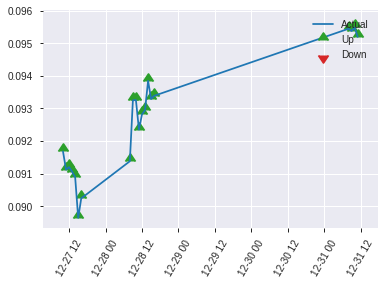


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25272227075748904
RMSE: 0.5027149000750715
LogLoss: 0.698619463319893
Null degrees of freedom: 222
Residual degrees of freedom: -815
Null deviance: 309.6501959015793
Residual deviance: 311.5842806406723
AIC: 2387.584280640672
AUC: 0.47173913043478266
pr_auc: 0.4888742316045801
Gini: -0.05652173913043468
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42400722876011343: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    106  0.9815   (106.0/108.0)
1      1    114  0.0087   (1.0/115.0)
Total  3    220  0.4798   (107.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.424007     0.680597  219
max f2                       0.380019     0.841874  222
max f0point5                 0.453668     0.582524  202
max accuracy                 0.453668     0.542601  202
max precision                0.539925     0.576923  25
max recall                   0.380019     1         222
max specificity              0.584401     0.990741  0
max absolute_mcc             0.520022     0.119105  63
max min_per_class_accuracy   0.50076      0.469565  107
max mean_per_class_accuracy  0.453668     0.52975   202

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 49.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.571656           0.646377  0.646377           0.333333         0.578615  0.333333                    0.578615            0.00869565      0.00869565                 -35.3623  -35.3623
    2        0.0224215                   0.564066           0.969565  0.775652           0.5              0.567855  0.4                         0.574311            0.00869565      0.0173913                  -3.04348  -22.4348
    3        0.0313901                   0.558176           0.969565  0.831056           0.5              0.559632  0.428571                    0.570117            0.00869565      0.026087                   -3.04348  -16.8944
    4        0.0403587                   0.55417            0.969565  0.861836           0.5              0.557972  0.444444                    0.567418            0.00869565      0.0347826                  -3.04348  -13.8164
    5        0.0538117                   0.549516           1.29275   0.969565           0.666667         0.552192  0.5                         0.563612            0.0173913       0.0521739                  29.2754   -3.04348
    6        0.103139                    0.542139           1.05771   1.01172            0.545455         0.544964  0.521739                    0.554693            0.0521739       0.104348                   5.77075   1.17202
    7        0.152466                    0.534069           0.705138  0.912532           0.363636         0.538283  0.470588                    0.549384            0.0347826       0.13913                    -29.4862  -8.7468
    8        0.201794                    0.527854           0.881423  0.904928           0.454545         0.529835  0.466667                    0.544606            0.0434783       0.182609                   -11.8577  -9.50725
    9        0.300448                    0.518397           0.793281  0.868267           0.409091         0.523459  0.447761                    0.537662            0.0782609       0.26087                    -20.6719  -13.1733
    10       0.399103                    0.509207           1.05771   0.915095           0.545455         0.514698  0.47191                     0.531985            0.104348        0.365217                   5.77075   -8.49047
    11       0.502242                    0.499587           1.01172   0.934938           0.521739         0.503644  0.482143                    0.526165            0.104348        0.469565                   1.17202   -6.50621
    12       0.600897                    0.489421           0.969565  0.940623           0.5              0.493327  0.485075                    0.520774            0.0956522       0.565217                   -3.04348  -5.9377
    13       0.699552                    0.479613           1.41028   1.00686            0.727273         0.484461  0.519231                    0.515653            0.13913         0.704348                   41.0277   0.685619
    14       0.798206                    0.468669           1.05771   1.01314            0.545455         0.474347  0.522472                    0.510548            0.104348        0.808696                   5.77075   1.31412
    15       0.896861                    0.456246           1.05771   1.01804            0.545455         0.461521  0.525                       0.505155            0.104348        0.913043                   5.77075   1.80435
    16       1                           0.380019           0.8431    1                  0.434783         0.437802  0.515695                    0.49820

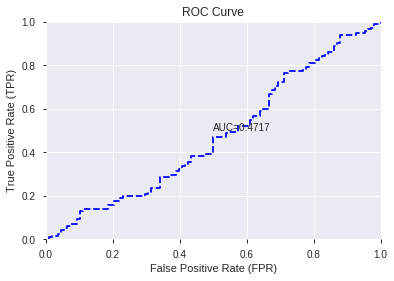

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


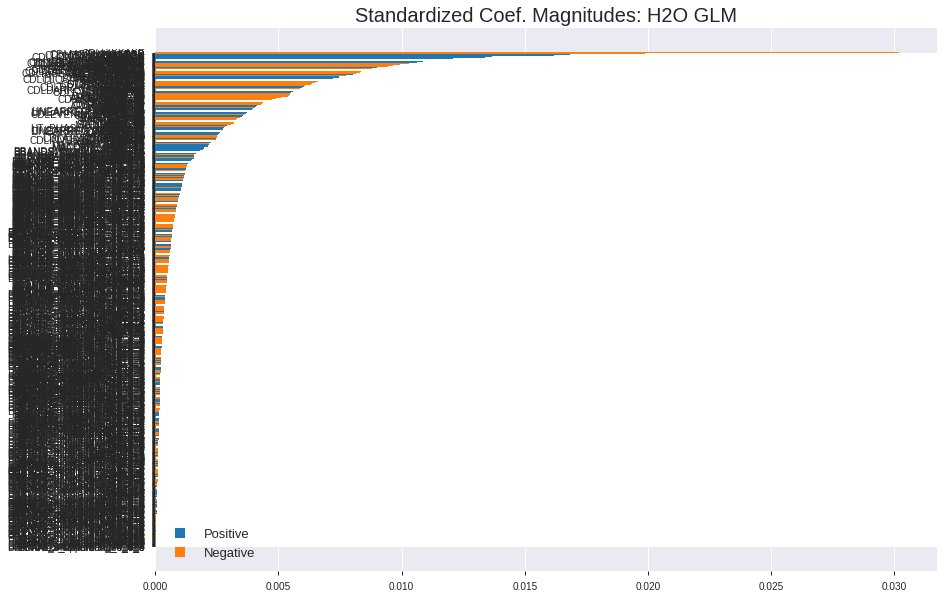

'log_likelihood'
--2019-08-26 21:22:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.205.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.205.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_212122_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_212122_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_afb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLHIKKAKE',
 'CDLMORNINGSTAR',
 'BOP',
 'CDLMARUBOZU',
 'CDLHOMINGPIGEON',
 'ADX_24',
 'hour',
 'CDLSPINNINGTOP',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLHIGHWAVE',
 'ADX_20',
 'CORREL_8',
 'dayofweek',
 'weekday',
 'CORREL_12',
 'CDL3OUTSIDE',
 'PLUS_DM_8',
 'CDLIDENTICAL3CROWS',
 'CDLRICKSHAWMAN',
 'CDLMORNINGDOJISTAR',
 'CDL3WHITESOLDIERS',
 'CDLHARAMI',
 'HT_TRENDMODE',
 'day',
 'MFI_14',
 'CDLSTALLEDPATTERN',
 'PLUS_DM_12',
 'CDL3BLACKCROWS',
 'CDLUNIQUE3RIVER',
 'AROONOSC_12',
 'aroonup_20',
 'PLUS_DM_14',
 'MFI_8',
 'CDLSEPARATINGLINES',
 'MFI_12',
 'CDLLADDERBOTTOM',
 'quarter',
 'CDLGAPSIDESIDEWHITE',
 'BETA_30',
 'CDLSHORTLINE',
 'CDLTHRUSTING',
 'CDLRISEFALL3METHODS',
 'aroonup_12',
 'CDLTASUKIGAP',
 'HT_DCPERIOD',
 'SAREXT',
 'AROONOSC_30',
 'aroondown_12',
 'CORREL_30',
 'aroondown_30',
 'weekday_name',
 'DX_30',
 'HT_PHASOR_inphase',
 'ADXR_14',
 'CDLCLOSINGMARUBOZU',
 'ROCR100_8',
 'ROCR_8',
 'ROCP_8',
 'ROC_8',
 'month',
 'PLUS_DM_20',
 'aroondown_14',
 'STOCHRSI_fast

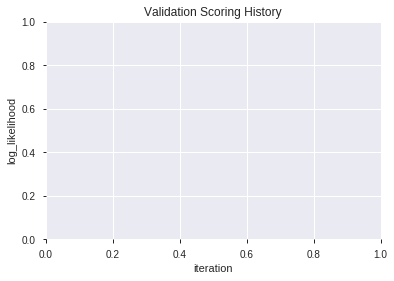

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190826_212217  0.550161  0.708419              0.471377  0.506943  0.256991
1               XGBoost_3_AutoML_20190826_212217  0.539855  0.698068              0.461272  0.502391  0.252397
2  XGBoost_grid_1_AutoML_20190826_212217_model_7  0.539211  0.731017              0.476006  0.517038  0.267329
3               XGBoost_2_AutoML_20190826_212217  0.527456  0.710060              0.451167  0.507811  0.257872
4  XGBoost_grid_1_AutoML_20190826_212217_model_5  0.523269  0.737043              0.471377  0.519006  0.269368
5  XGBoost_grid_1_AutoML_20190826_212217_model_6  0.521981  0.704911              0.486111  0.505678  0.255710
6  XGBoost_grid_1_AutoML_20190826_212217_model_2  0.512560  0.704045              0.495089  0.505277  0.255304
7  XGBoost_grid_1_AutoML_20190826_212217_model_1  0.509179  0.706758              0.481481  0.506519  0.256561
8  XGBoost_grid_1_AutoML_20190826_212217_model_3  0.504187  0.722250              0.471940  0.513660  0.263846
9  XGBoost_grid_1_AutoML_20190826_212217_model_4  0.476409  0.709141              0.485829  0.507782  0.257842

variable  relative_importance  scaled_importance  percentage
0                        BOP           270.971619           1.000000    0.033788
1          HT_PHASOR_inphase           155.711197           0.574640    0.019416
2       HT_PHASOR_quadrature           140.905777           0.520002    0.017570
3                  STDDEV_12           111.847801           0.412766    0.013947
4                     BETA_8           103.674217           0.382602    0.012927
..                       ...                  ...                ...         ...
331             HT_TRENDMODE             1.218891           0.004498    0.000152
332  BBANDS_upperband_20_1_2             1.069046           0.003945    0.000133
333  BBANDS_upperband_20_7_2             1.032643           0.003811    0.000129
334        MACDFIX_signal_14             0.672915           0.002483    0.000084
335  BBANDS_upperband_30_5_5             0.041809           0.000154    0.000005

[336 rows x 4 columns]

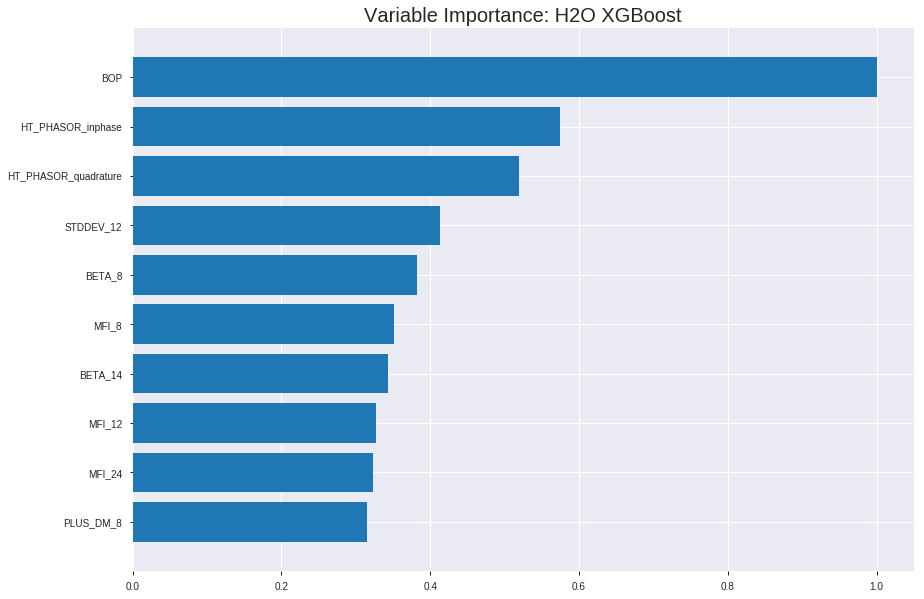

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190826_212217


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13635218180456576
RMSE: 0.36925896306598405
LogLoss: 0.45398429088314907
Mean Per-Class Error: 0.06577556596602152
AUC: 0.9842762939840809
pr_auc: 0.9834553314542555
Gini: 0.9685525879681618
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4988875389099121: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      756  43   0.0538   (43.0/799.0)
1      59   700  0.0777   (59.0/759.0)
Total  815  743  0.0655   (102.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.498888     0.932091  200
max f2                       0.425728     0.949174  245
max f0point5                 0.540657     0.95547   174
max accuracy                 0.506541     0.934531  195
max precision                0.846398     1         0
max recall                   0.355072     1         290
max specificity              0.846398     1         0
max absolute_mcc             0.506541     0.869575  195
max min_per_class_accuracy   0.491696     0.932416  205
max mean_per_class_accuracy  0.498888     0.934224  200

Gains/Lift Table: Avg response rate: 48.72 %, avg score: 48.85 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.804376           2.0527     2.0527             1                0.817497  1                           0.817497            0.0210804       0.0210804                  105.27    105.27
    2        0.0205392                   0.779467           2.0527     2.0527             1                0.787478  1                           0.802488            0.0210804       0.0421607                  105.27    105.27
    3        0.0301669                   0.764806           2.0527     2.0527             1                0.77054   1                           0.792292            0.0197628       0.0619236                  105.27    105.27
    4        0.0404365                   0.752011           2.0527     2.0527             1                0.758748  1                           0.783773            0.0210804       0.083004                   105.27    105.27
    5        0.0500642                   0.741183           2.0527     2.0527             1                0.748264  1                           0.776944            0.0197628       0.102767                   105.27    105.27
    6        0.100128                    0.714014           2.0527     2.0527             1                0.725793  1                           0.751369            0.102767        0.205534                   105.27    105.27
    7        0.150193                    0.686255           2.0527     2.0527             1                0.700528  1                           0.734422            0.102767        0.3083                     105.27    105.27
    8        0.200257                    0.660492           2.0527     2.0527             1                0.673565  1                           0.719208            0.102767        0.411067                   105.27    105.27
    9        0.300385                    0.61163            2.03954    2.04831            0.99359          0.637206  0.997863                    0.691874            0.204216        0.615283                   103.954   104.831
    10       0.399872                    0.55145            1.96       2.02634            0.954839         0.581702  0.987159                    0.664463            0.194993        0.810277                   95.9998   102.634
    11       0.5                         0.483699           1.31583    1.88406            0.641026         0.517303  0.917843                    0.634994            0.131752        0.942029                   31.5834   88.4058
    12       0.600128                    0.411932           0.447384   1.64436            0.217949         0.44659   0.80107                     0.603559            0.0447958       0.986825                   -55.2616  64.4356
    13       0.699615                    0.362598           0.119189   1.42747            0.0580645        0.386985  0.695413                    0.572762            0.0118577       0.998682                   -88.0811  42.7475
    14       0.799743                    0.322062           0.0131583  1.2504             0.00641026       0.342574  0.609149                    0.543942            0.00131752      1                          -98.6842  25.0401
    15       0.899872                    0.273306           0          1.11127            0                0.299316  0.541369                    0.516723            0               1                          -100      11.127
    16       1                           0.15463            0          1                  0                0.234368  0.487163                    0.488451



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26296966162227675
RMSE: 0.5128056762773563
LogLoss: 0.7217351669690358
Mean Per-Class Error: 0.4545859666180522
AUC: 0.5243376276130287
pr_auc: 0.560186913694036
Gini: 0.04867525522605742
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.20544099807739258: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    203  0.9951   (203.0/204.0)
1      0    242  0        (0.0/242.0)
Total  1    445  0.4552   (203.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.205441     0.704512  398
max f2                       0.205441     0.856334  398
max f0point5                 0.229329     0.599401  393
max accuracy                 0.256619     0.547085  388
max precision                0.808067     0.666667  2
max recall                   0.205441     1         398
max specificity              0.810287     0.995098  0
max absolute_mcc             0.476049     0.090652  189
max min_per_class_accuracy   0.469415     0.524793  200
max mean_per_class_accuracy  0.476049     0.545414  189

Gains/Lift Table: Avg response rate: 54.26 %, avg score: 47.05 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.74298            1.10579   1.10579            0.6              0.790063  0.6                         0.790063            0.0123967       0.0123967                  10.5785   10.5785
    2        0.0201794                   0.721288           0.921488  1.02388            0.5              0.735466  0.555556                    0.765797            0.00826446      0.0206612                  -7.85124  2.38751
    3        0.0313901                   0.683952           1.10579   1.05313            0.6              0.699969  0.571429                    0.742287            0.0123967       0.0330579                  10.5785   5.31287
    4        0.0403587                   0.677176           0.921488  1.02388            0.5              0.680241  0.555556                    0.728499            0.00826446      0.0413223                  -7.85124  2.38751
    5        0.0515695                   0.670333           1.10579   1.04168            0.6              0.674068  0.565217                    0.716666            0.0123967       0.053719                   10.5785   4.16816
    6        0.100897                    0.621345           1.00526   1.02388            0.545455         0.647903  0.555556                    0.683049            0.0495868       0.103306                   0.52592   2.38751
    7        0.150224                    0.595822           1.08903   1.04527            0.590909         0.613162  0.567164                    0.660101            0.053719        0.157025                   8.90308   4.52695
    8        0.201794                    0.569886           1.20194   1.08531            0.652174         0.58237   0.588889                    0.640236            0.0619835       0.219008                   20.194    8.53076
    9        0.300448                    0.540736           1.08903   1.08653            0.590909         0.555029  0.589552                    0.612258            0.107438        0.326446                   8.90308   8.65302
    10       0.401345                    0.502403           0.941965  1.05019            0.511111         0.520674  0.569832                    0.589234            0.0950413       0.421488                   -5.80349  5.0187
    11       0.5                         0.469234           1.04715   1.04959            0.568182         0.484618  0.569507                    0.568592            0.103306        0.524793                   4.7145    4.95868
    12       0.600897                    0.438084           0.8191    1.01089            0.444444         0.45166   0.548507                    0.548958            0.0826446       0.607438                   -18.09    1.08857
    13       0.699552                    0.405402           1.00526   1.01009            0.545455         0.42162   0.548077                    0.531               0.0991736       0.706612                   0.52592   1.00922
    14       0.800448                    0.354911           0.941965  1.0015             0.511111         0.377958  0.543417                    0.511709            0.0950413       0.801653                   -5.80349  0.150473
    15       0.899103                    0.317866           0.879602  0.988129           0.477273         0.331938  0.53616                     0.491984            0.0867769       0.88843                    -12.0398  -1.18711
    16       1                           0.203258           1.10579   1                  0.6              0.278736  0.542601                    0.470468        


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 21:22:17  0.007 sec   0                  0.5              0.693147            0.5             0                  1                0.512837                         0.5                0.693147              0.5               0                    1                  0.457399
    2019-08-26 21:22:18  1.319 sec   5                  0.483016         0.659656            0.821755        0.802656           2.0527           0.250963                         0.499361           0.691872              0.534537          0.578057             1.10579            0.457399
    2019-08-26 21:22:19  1.606 sec   10                 0.465776         0.626549            0.896107        0.887524           2.0527           0.189987                         0.501354           0.695899              0.5245            0.562972             1.10579            0.455157
    2019-08-26 21:22:19  1.892 sec   15                 0.451005         0.598784            0.92118         0.915222           2.0527           0.147625                         0.502966           0.699234              0.521087          0.566589             1.10579            0.455157
    2019-08-26 21:22:19  2.183 sec   20                 0.436907         0.572746            0.940203        0.935909           2.0527           0.130937                         0.504592           0.702589              0.514524          0.567263             1.47438            0.455157
    2019-08-26 21:22:20  2.455 sec   25                 0.424487         0.550159            0.953429        0.94926            2.0527           0.120026                         0.506467           0.706649              0.51504           0.56604              1.10579            0.455157
    2019-08-26 21:22:20  2.742 sec   30                 0.411824         0.527558            0.964164        0.963333           2.0527           0.0988447                        0.508512           0.711238              0.517572          0.561556             1.47438            0.457399
    2019-08-26 21:22:20  3.009 sec   35                 0.400618         0.507677            0.969486        0.968529           2.0527           0.0949936                        0.509721           0.714063              0.52295           0.563                1.47438            0.455157
    2019-08-26 21:22:20  3.287 sec   40                 0.390614         0.490256            0.973842        0.972763           2.0527           0.0879332                        0.510168           0.715132              0.52614           0.564612             1.47438            0.457399
    2019-08-26 21:22:21  3.553 sec   45                 0.380035         0.472066            0.97915         0.978257           2.0527           0.0750963                        0.512132           0.719799              0.521684          0.55987              1.10579            0.457399
    2019-08-26 21:22:21  3.829 sec   50                 0.369259         0.453984            0.984276        0.983455           2.0527           0.0654685                        0.512806           0.721735              0.524338          0.560187             1.10579            0.455157

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      270.97161865234375     1.0                     0.03378797832477426
HT_PHASOR_inphase        155.71119689941406     0.574640243409371       0.01941593208885883
HT_PHASOR_quadrature     140.90577697753906     0.5200019754036345      0.017569815473777797
STDDEV_12                111.8478012084961      0.41276574190596943     0.01394651994072826
BETA_8                   103.6742172241211      0.3826017563748438      0.012927339851413783
---                      ---                    ---                     ---
HT_TRENDMODE             1.2188911437988281     0.004498224389184699    0.00015198590816174352
BBANDS_upperband_20_1_2  1.0690460205078125     0.003945232441038031    0.00013330142820398922
BBANDS_upperband_20_7_2  1.0326433181762695     0.0038108910568274298   0.00012876230442616127
MACDFIX_signal_14        0.6729145050048828     0.00248333942998005     8.390701883322318e-05
BBANDS_upperband_30_5_5  0.04180908203125       0.00015429321431958157  5.213255781089771e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5739910313901345)

('F1', 0.687116564417178)

('auc', 0.5501610305958132)

('logloss', 0.7084194607543849)

('mean_per_class_error', 0.43486312399355875)

('rmse', 0.506943082032715)

('mse', 0.256991288420828)

xgboost prediction progress: |████████████████████████████████████████████| 100%


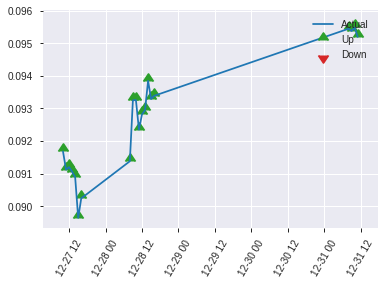


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.256991288420828
RMSE: 0.506943082032715
LogLoss: 0.7084194607543849
Mean Per-Class Error: 0.43486312399355875
AUC: 0.5501610305958132
pr_auc: 0.5371379333278109
Gini: 0.10032206119162645
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27003318071365356: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      9    99   0.9167   (99.0/108.0)
1      3    112  0.0261   (3.0/115.0)
Total  12   211  0.4574   (102.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.270033     0.687117  210
max f2                       0.227291     0.841874  222
max f0point5                 0.354847     0.598802  179
max accuracy                 0.354847     0.573991  179
max precision                0.788563     1         0
max recall                   0.227291     1         222
max specificity              0.788563     1         0
max absolute_mcc             0.354847     0.163188  179
max min_per_class_accuracy   0.464858     0.537037  111
max mean_per_class_accuracy  0.423359     0.565137  142

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 47.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.766257           1.29275   1.29275            0.666667         0.78073   0.666667                    0.78073             0.0173913       0.0173913                  29.2754   29.2754
    2        0.0224215                   0.741315           1.93913   1.5513             1                0.749608  0.8                         0.768281            0.0173913       0.0347826                  93.913    55.1304
    3        0.0313901                   0.724205           0.969565  1.38509            0.5              0.729308  0.714286                    0.757146            0.00869565      0.0434783                  -3.04348  38.5093
    4        0.0403587                   0.709618           0         1.07729            0                0.720029  0.555556                    0.748898            0               0.0434783                  -100      7.72947
    5        0.0538117                   0.686241           0.646377  0.969565           0.333333         0.701141  0.5                         0.736959            0.00869565      0.0521739                  -35.3623  -3.04348
    6        0.103139                    0.642426           0.528854  0.75879            0.272727         0.65028   0.391304                    0.695504            0.026087        0.0782609                  -47.1146  -24.121
    7        0.152466                    0.619051           1.58656   1.0266             0.818182         0.629054  0.529412                    0.674005            0.0782609       0.156522                   58.6561   2.65985
    8        0.201794                    0.576594           0.881423  0.991111           0.454545         0.599554  0.511111                    0.655806            0.0434783       0.2                        -11.8577  -0.888889
    9        0.300448                    0.529619           1.32213   1.09981            0.681818         0.546565  0.567164                    0.619936            0.130435        0.330435                   32.2134   9.98053
    10       0.399103                    0.489913           0.793281  1.02404            0.409091         0.513901  0.52809                     0.593725            0.0782609       0.408696                   -20.6719  2.40352
    11       0.502242                    0.464858           1.26465   1.07345            0.652174         0.475254  0.553571                    0.569396            0.130435        0.53913                    26.465    7.34472
    12       0.600897                    0.438521           1.05771   1.07086            0.545455         0.450411  0.552239                    0.549861            0.104348        0.643478                   5.77075   7.08631
    13       0.699552                    0.403413           1.05771   1.06901            0.545455         0.419674  0.551282                    0.531502            0.104348        0.747826                   5.77075   6.90078
    14       0.798206                    0.357138           1.05771   1.06761            0.545455         0.382245  0.550562                    0.513054            0.104348        0.852174                   5.77075   6.76111
    15       0.896861                    0.320487           0.881423  1.04713            0.454545         0.33898   0.54                        0.493906            0.0869565       0.93913                    -11.8577  4.71304
    16       1                           0.227291           0.59017   1                  0.304348         0.269484  0.515695                    0.470759      

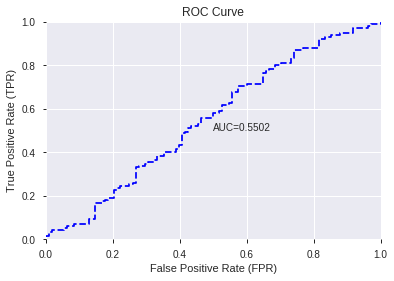

This function is available for GLM models only


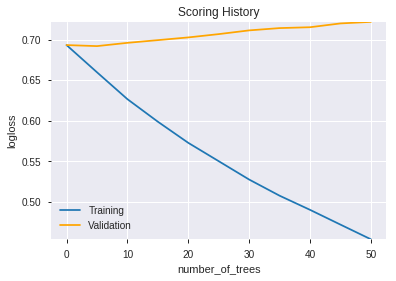

--2019-08-26 21:23:12--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.113.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.113.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190826_212217',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190826_212217',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_afb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_afb1',
   'type

['BOP',
 'HT_PHASOR_inphase',
 'HT_PHASOR_quadrature',
 'STDDEV_12',
 'BETA_8',
 'MFI_8',
 'BETA_14',
 'MFI_12',
 'MFI_24',
 'PLUS_DM_8',
 'STDDEV_8',
 'HT_DCPERIOD',
 'STDDEV_14',
 'day',
 'WILLR_8',
 'ADOSC',
 'LINEARREG_ANGLE_14',
 'MFI_20',
 'STDDEV_24',
 'STDDEV_20',
 'DIV',
 'BETA_24',
 'ADX_20',
 'CCI_8',
 'STOCHRSI_fastk',
 'Volume',
 'ROC_30',
 'MACDFIX_hist_24',
 'WILLR_14',
 'ADXR_8',
 'MACDFIX_hist_8',
 'ROC_12',
 'DX_8',
 'ROC_8',
 'CMO_30',
 'SUB',
 'DX_20',
 'BETA_12',
 'ADXR_12',
 'MINUS_DI_12',
 'MACDEXT_signal',
 'DX_30',
 'ADX_24',
 'aroonup_8',
 'PLUS_DM_12',
 'CMO_20',
 'STOCHF_fastk',
 'PLUS_DI_14',
 'MFI_14',
 'hour',
 'NATR_30',
 'MACDEXT_hist',
 'BETA_30',
 'aroonup_12',
 'MFI_30',
 'PLUS_DM_14',
 'LINEARREG_ANGLE_12',
 'NATR_24',
 'aroonup_14',
 'AD',
 'PLUS_DM_24',
 'CCI_24',
 'MOM_8',
 'MACDFIX_signal_20',
 'MOM_24',
 'MINUS_DI_30',
 'WILLR_20',
 'ADXR_14',
 'MINUS_DI_8',
 'LINEARREG_ANGLE_30',
 'STDDEV_30',
 'MACDFIX_signal_24',
 'STOCH_slowd',
 'PLUS_DI_30

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

51

['BBANDS_middleband_14_4_2',
 'BBANDS_middleband_14_4_5',
 'SAR_0.2',
 'BBANDS_upperband_24_3_5',
 'BOP',
 'MACDFIX_8',
 'PLUS_DI_8',
 'ROCR_8',
 'RSI_8',
 'WILLR_8',
 'aroondown_12',
 'MFI_12',
 'MOM_12',
 'ROCR_12',
 'ROCR100_12',
 'WILLR_12',
 'aroonup_14',
 'MFI_14',
 'PLUS_DI_14',
 'ROCP_14',
 'ADX_20',
 'aroondown_20',
 'CMO_20',
 'DX_20',
 'ROC_20',
 'ROCR_20',
 'WILLR_20',
 'DX_24',
 'ROC_24',
 'ROCP_24',
 'AROONOSC_30',
 'CMO_30',
 'PLUS_DM_30',
 'ROCR_30',
 'MACDEXT_hist',
 'STOCHRSI_fastd',
 'ULTOSC',
 'ADOSC',
 'OBV',
 'ATR_8',
 'NATR_8',
 'ATR_14',
 'NATR_24',
 'HT_PHASOR_inphase',
 'CDLSHORTLINE',
 'CDLSPINNINGTOP',
 'BETA_8',
 'LINEARREG_ANGLE_8',
 'STDDEV_8',
 'LINEARREG_SLOPE_12',
 'STDDEV_12']

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190826_212436_model_8  0.559300  0.693977              0.500000  0.500249  0.250249
1  DeepLearning_grid_1_AutoML_20190826_212436_model_6  0.558535  0.749096              0.500000  0.515582  0.265825
2  DeepLearning_grid_1_AutoML_20190826_212436_model_3  0.540258  0.877725              0.495370  0.561488  0.315269
3  DeepLearning_grid_1_AutoML_20190826_212436_model_1  0.538003  1.154749              0.471940  0.600732  0.360879
4  DeepLearning_grid_1_AutoML_20190826_212436_model_9  0.532448  0.692231              0.495370  0.499539  0.249539
5  DeepLearning_grid_1_AutoML_20190826_212436_model_2  0.527375  1.024165              0.490741  0.589575  0.347599
6  DeepLearning_grid_1_AutoML_20190826_212436_model_5  0.525040  0.697531              0.495370  0.501909  0.251912
7               DeepLearning_1_AutoML_20190826_212436  0.513205  0.836564              0.480918  0.553427  0.306281
8  DeepLearning_grid_1_AutoML_20190826_212436_model_7  0.504267  0.789706              0.500000  0.537340  0.288735
9  DeepLearning_grid_1_AutoML_20190826_212436_model_4  0.476409  0.806417              0.500000  0.545022  0.297048

variable  relative_importance  scaled_importance  percentage
0                        BOP             1.000000           1.000000    0.031448
1               aroondown_20             0.867285           0.867285    0.027274
2                 aroonup_14             0.837496           0.837496    0.026337
3                     ADX_20             0.837456           0.837456    0.026336
4                AROONOSC_30             0.829225           0.829225    0.026077
5                      DX_24             0.778637           0.778637    0.024486
6                      DX_20             0.778142           0.778142    0.024471
7               aroondown_12             0.751560           0.751560    0.023635
8                     BETA_8             0.728265           0.728265    0.022902
9                   WILLR_20             0.693421           0.693421    0.021807
10                  WILLR_12             0.671729           0.671729    0.021124
11                    MFI_14             0.658657           0.658657    0.020713
12                 PLUS_DI_8             0.655337           0.655337    0.020609
13            STOCHRSI_fastd             0.653140           0.653140    0.020540
14                    CMO_30             0.642574           0.642574    0.020207
15                       OBV             0.640026           0.640026    0.020127
16                PLUS_DM_30             0.637099           0.637099    0.020035
17              CDLSHORTLINE             0.626973           0.626973    0.019717
18                 STDDEV_12             0.622124           0.622124    0.019564
19                   ROCP_14             0.621211           0.621211    0.019536
20            CDLSPINNINGTOP             0.619114           0.619114    0.019470
21                  STDDEV_8             0.616847           0.616847    0.019398
22                PLUS_DI_14             0.613722           0.613722    0.019300
23         HT_PHASOR_inphase             0.612831           0.612831    0.019272
24                    MFI_12             0.609458           0.609458    0.019166
25                    ULTOSC             0.603019           0.603019    0.018964
26                    CMO_20             0.588881           0.588881    0.018519
27                   ROCP_24             0.584498           0.584498    0.018381
28                   ROCR_12             0.578370           0.578370    0.018188
29                    NATR_8             0.573082           0.573082    0.018022
30                     ATR_8             0.569839           0.569839    0.017920
31                    ROC_24             0.569179           0.569179    0.017899
32                     ADOSC             0.567837           0.567837    0.017857
33                    ROCR_8             0.562487           0.562487    0.017689
34                     RSI_8             0.562050           0.562050    0.017675
35        LINEARREG_SLOPE_12             0.560458           0.560458    0.017625
36              MACDEXT_hist             0.554211           0.554211    0.017429
37                    MOM_12             0.553660           0.553660    0.017411
38                   WILLR_8             0.551294           0.551294    0.017337
39                 MACDFIX_8             0.551153           0.551153    0.017333
40                   ROCR_30             0.540647           0.540647    0.017002
41         LINEARREG_ANGLE_8             0.537668           0.537668    0.016908
42                   NATR_24             0.537482           0.537482    0.016903
43                    ROC_20             0.534436           0.534436    0.016807
44  BBANDS_middleband_14_4_5             0.529358           0.529358    0.016647
45                   ROCR_20             0.528030           0.528030    0.016605
46   BBANDS_upperband_24_3_5             0.505372           0.505372    0.015893
47                   SAR_0.2             0.498097           0.498097    0.015664
48                    ATR_14             0.491251  

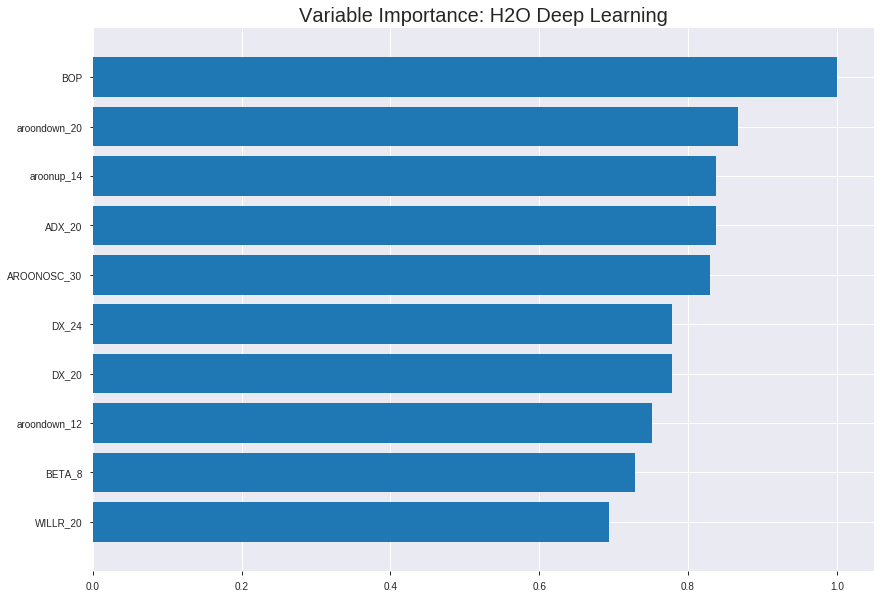

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190826_212436_model_8


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24263062976353517
RMSE: 0.49257550666221234
LogLoss: 0.6774174581027467
Mean Per-Class Error: 0.43854554688749614
AUC: 0.6019233528076103
pr_auc: 0.6015104178308092
Gini: 0.20384670561522067
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4997111697295069: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      114  685   0.8573   (685.0/799.0)
1      31   728   0.0408   (31.0/759.0)
Total  145  1413  0.4596   (716.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.499711     0.67035   277
max f2                       0.382558     0.830769  355
max f0point5                 0.51889      0.570969  218
max accuracy                 0.525258     0.567394  176
max precision                0.85362      1         0
max recall                   0.322763     1         374
max specificity              0.85362      1         0
max absolute_mcc             0.499711     0.175201  277
max min_per_class_accuracy   0.525052     0.332916  177
max mean_per_class_accuracy  0.520233     0.561454  211

Gains/Lift Table: Avg response rate: 48.72 %, avg score: 52.10 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0102696                   0.681093           1.79611   1.79611            0.875            0.754936  0.875                       0.754936            0.0184453       0.0184453                  79.6113    79.6113
    2        0.0205392                   0.631617           1.79611   1.79611            0.875            0.65486   0.875                       0.704898            0.0184453       0.0368906                  79.6113    79.6113
    3        0.0301669                   0.602327           1.23162   1.61596            0.6              0.613026  0.787234                    0.675577            0.0118577       0.0487484                  23.1621    61.5956
    4        0.0404365                   0.583584           1.53953   1.59655            0.75             0.593018  0.777778                    0.65461             0.0158103       0.0645586                  53.9526    59.6545
    5        0.0500642                   0.56759            1.09477   1.50005            0.533333         0.574119  0.730769                    0.639131            0.0105402       0.0750988                  9.47738    50.0051
    6        0.100128                    0.540106           1.21057   1.35531            0.589744         0.551169  0.660256                    0.59515             0.0606061       0.135705                   21.0567    35.5309
    7        0.150193                    0.530515           1.18425   1.29829            0.576923         0.534855  0.632479                    0.575051            0.0592885       0.194993                   18.4251    29.8289
    8        0.722721                    0.525052           1.02865   1.08469            0.501121         0.525252  0.528419                    0.535601            0.588933        0.783926                   2.86517    8.46865
    9        0.799743                    0.521738           0.992139  1.07577            0.483333         0.523807  0.524077                    0.534465            0.0764163       0.860343                   -0.786122  7.57734
    10       0.899872                    0.502445           0.921084  1.05856            0.448718         0.513905  0.515692                    0.532177            0.0922266       0.952569                   -7.89163   5.85612
    11       1                           0.136942           0.4737    1                  0.230769         0.420576  0.487163                    0.521003            0.0474308       1                          -52.63     0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.24762287514004316
RMSE: 0.4976171973917734
LogLoss: 0.6885469496532919
Mean Per-Class Error: 0.4598120239831469
AUC: 0.5397828552908767
pr_auc: 0.5745309726338355
Gini: 0.07956571058175332
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36548744490280866: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    197  0.9657   (197.0/204.0)
1      3    239  0.0124   (3.0/242.0)
Total  10   436  0.4484   (200.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.365487     0.705015  220
max f2                       0.203213     0.855728  230
max f0point5                 0.4958       0.610034  162
max accuracy                 0.4958       0.569507  162
max precision                0.578136     0.75      3
max recall                   0.203213     1         230
max specificity              0.612238     0.995098  0
max absolute_mcc             0.4958       0.111391  162
max min_per_class_accuracy   0.525052     0.426471  53
max mean_per_class_accuracy  0.4958       0.540188  162

Gains/Lift Table: Avg response rate: 54.26 %, avg score: 51.03 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.56462            1.10579   1.10579            0.6              0.586607  0.6                         0.586607            0.0123967       0.0123967                  10.5785   10.5785
    2        0.0201794                   0.559573           0         0.614325           0                0.561879  0.333333                    0.575617            0               0.0123967                  -100      -38.5675
    3        0.0313901                   0.547125           1.47438   0.921488           0.8              0.554577  0.5                         0.568103            0.0165289       0.0289256                  47.438    -7.85124
    4        0.0403587                   0.542713           1.38223   1.02388            0.75             0.545098  0.555556                    0.562991            0.0123967       0.0413223                  38.2231   2.38751
    5        0.0515695                   0.53892            1.84298   1.20194            1                0.540662  0.652174                    0.558137            0.0206612       0.0619835                  84.2975   20.194
    6        0.100897                    0.528252           1.25657   1.22865            0.681818         0.532732  0.666667                    0.545716            0.0619835       0.123967                   25.6574   22.865
    7        0.603139                    0.525052           1.00376   1.04138            0.544643         0.525118  0.565056                    0.528564            0.504132        0.628099                   0.376328  4.13838
    8        0.699552                    0.515371           0.900058  1.02191            0.488372         0.521592  0.554487                    0.527603            0.0867769       0.714876                   -9.99423  2.19061
    9        0.800448                    0.501969           1.14674   1.03764            0.622222         0.507575  0.563025                    0.525078            0.115702        0.830579                   14.674    3.76415
    10       0.899103                    0.481062           0.921488  1.0249             0.5              0.494101  0.55611                     0.521679            0.0909091       0.921488                   -7.85124  2.48964
    11       1                           0.203213           0.778145  1                  0.422222         0.408885  0.542601                    0.510299            0.0785124       1                          -22.1855  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 21:30:27  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-26 21:30:29  1 min 32.982 sec  659 obs/sec       0.72208   1             1125       0.508879         0.711614            -0.0365133     0.510036        0.50024            1.28294          0.506418                         0.511019           0.716096              -0.0522019       0.468228          0.497596             0.368595           0.44843
    2019-08-26 21:30:38  1 min 42.320 sec  1027 obs/sec      6.68485   9             10415      0.500607         0.694369            -0.00309215    0.527851        0.53242            0.898057         0.509628                         0.506141           0.705555              -0.0322095       0.48421           0.513128             0.368595           0.455157
    2019-08-26 21:30:48  1 min 51.706 sec  1361 obs/sec      16.2702   22            25349      0.501799         0.696783            -0.00787407    0.539066        0.536859           1.28294          0.511553                         0.508962           0.711344              -0.0437472       0.489092          0.528655             1.10579            0.457399
    2019-08-26 21:30:57  2 min  0.850 sec  1415 obs/sec      24.4134   33            38036      0.497119         0.687508            0.0108407      0.57884         0.564998           1.53953          0.512837                         0.507477           0.708526              -0.0376655       0.526738          0.549293             0.73719            0.446188
    2019-08-26 21:31:06  2 min 10.511 sec  1455 obs/sec      33.2606   45            51820      0.493911         0.680842            0.0235642      0.597454        0.582971           1.79611          0.469833                         0.505035           0.703387              -0.027703        0.532146          0.564925             1.10579            0.439462
    2019-08-26 21:31:16  2 min 19.771 sec  1493 obs/sec      42.1483   57            65667      0.492576         0.677417            0.0288373      0.601923        0.60151            1.79611          0.459564                         0.497617           0.688547              0.0022656        0.539783          0.574531             1.10579            0.44843

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
BOP                       1.0                    1.0                  0.0314476915791827
aroondown_20              0.8672850131988525     0.8672850131988525   0.02727411160632491
aroonup_14                0.8374958634376526     0.8374958634376526   0.02633731161222861
ADX_20                    0.8374564051628113     0.8374564051628113   0.026336070740571156
AROONOSC_30               0.829224705696106      0.829224705696106    0.026077202794569685
---                       ---                    ---                  ---
BBANDS_upperband_24_3_5   0.5053722858428955     0.5053722858428955   0.015892791777853937
SAR_0.2                   0.4980967938899994     0.4980967938899994   0.015663994350832433
ATR_14                    0.49125054478645325    0.49125054478645325  0.01544869562054986
ROCR100_12                0.4888443052768707     0.4888443052768707   0.015373024942586865
BBANDS_middleband_14_4_2  0.47530314326286316    0.47530314326286316  0.01494718665594661


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5919282511210763)

('F1', 0.6804733727810652)

('auc', 0.5592995169082126)

('logloss', 0.693977400489241)

('mean_per_class_error', 0.4134057971014493)

('rmse', 0.5002485442785828)

('mse', 0.25024860605284116)

deeplearning prediction progress: |███████████████████████████████████████| 100%


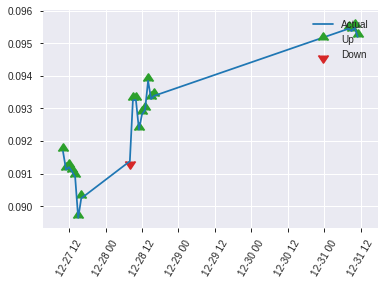


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25024860605284116
RMSE: 0.5002485442785828
LogLoss: 0.693977400489241
Mean Per-Class Error: 0.4134057971014493
AUC: 0.5592995169082126
pr_auc: 0.540673749853732
Gini: 0.11859903381642511
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.30326405541357254: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    108  1        (108.0/108.0)
1      0    115  0        (0.0/115.0)
Total  0    223  0.4843   (108.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.303264     0.680473  133
max f2                       0.303264     0.841874  133
max f0point5                 0.516409     0.608392  60
max accuracy                 0.516409     0.591928  60
max precision                0.676933     1         0
max recall                   0.303264     1         133
max specificity              0.676933     1         0
max absolute_mcc             0.516409     0.184447  60
max min_per_class_accuracy   0.525052     0.518519  29
max mean_per_class_accuracy  0.516409     0.586594  60

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 51.07 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.590432           0.646377  0.646377           0.333333         0.627767  0.333333                    0.627767            0.00869565      0.00869565                 -35.3623  -35.3623
    2        0.0224215                   0.571326           0.969565  0.775652           0.5              0.580997  0.4                         0.609059            0.00869565      0.0173913                  -3.04348  -22.4348
    3        0.0313901                   0.565989           0         0.554037           0                0.567454  0.285714                    0.597172            0               0.0173913                  -100      -44.5963
    4        0.0403587                   0.559503           1.93913   0.861836           1                0.564013  0.444444                    0.589803            0.0173913       0.0347826                  93.913    -13.8164
    5        0.0538117                   0.554935           1.93913   1.13116            1                0.556687  0.583333                    0.581524            0.026087        0.0608696                  93.913    13.1159
    6        0.103139                    0.533122           1.05771   1.09603            0.545455         0.546313  0.565217                    0.564684            0.0521739       0.113043                   5.77075   9.60302
    7        0.533632                    0.525052           1.09076   1.09178            0.5625           0.525218  0.563025                    0.532846            0.469565        0.582609                   9.07609   9.17793
    8        0.600897                    0.522637           1.0342    1.08533            0.533333         0.523645  0.559701                    0.531816            0.0695652       0.652174                   3.42029   8.53342
    9        0.699552                    0.513199           1.23399   1.1063             0.636364         0.518044  0.570513                    0.529874            0.121739        0.773913                   23.3992   10.6299
    10       0.798206                    0.500838           0.616996  1.04582            0.318182         0.508376  0.539326                    0.527217            0.0608696       0.834783                   -38.3004  4.58232
    11       0.896861                    0.467476           0.705138  1.00835            0.363636         0.490822  0.52                        0.523213            0.0695652       0.904348                   -29.4862  0.834783
    12       1                           0.303264           0.92741   1                  0.478261         0.401794  0.515695                    0.51069             0.0956522       1                          -7.25898  0

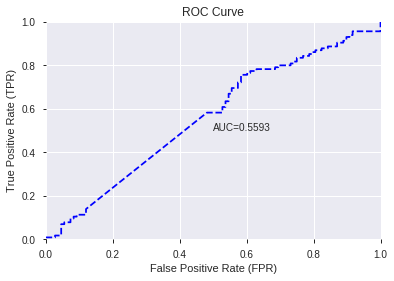

This function is available for GLM models only


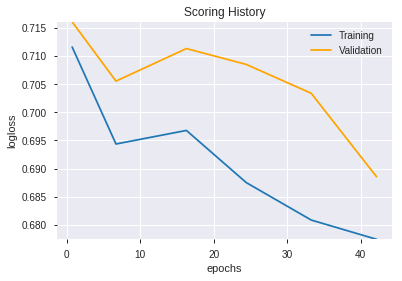

--2019-08-26 21:32:25--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.112.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.112.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190826_212436_model_8',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190826_212436_model_8',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_afb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'aroondown_20',
 'aroonup_14',
 'ADX_20',
 'AROONOSC_30',
 'DX_24',
 'DX_20',
 'aroondown_12',
 'BETA_8',
 'WILLR_20',
 'WILLR_12',
 'MFI_14',
 'PLUS_DI_8',
 'STOCHRSI_fastd',
 'CMO_30',
 'OBV',
 'PLUS_DM_30',
 'CDLSHORTLINE',
 'STDDEV_12',
 'ROCP_14',
 'CDLSPINNINGTOP',
 'STDDEV_8',
 'PLUS_DI_14',
 'HT_PHASOR_inphase',
 'MFI_12',
 'ULTOSC',
 'CMO_20',
 'ROCP_24',
 'ROCR_12',
 'NATR_8',
 'ATR_8',
 'ROC_24',
 'ADOSC',
 'ROCR_8',
 'RSI_8',
 'LINEARREG_SLOPE_12',
 'MACDEXT_hist',
 'MOM_12',
 'WILLR_8',
 'MACDFIX_8',
 'ROCR_30',
 'LINEARREG_ANGLE_8',
 'NATR_24',
 'ROC_20',
 'BBANDS_middleband_14_4_5',
 'ROCR_20',
 'BBANDS_upperband_24_3_5',
 'SAR_0.2',
 'ATR_14',
 'ROCR100_12',
 'BBANDS_middleband_14_4_2']

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse      mse
0  GLM_grid_1_AutoML_20190826_213232_model_1  0.523188  0.694448              0.490177  0.50065  0.25065

variable  relative_importance  scaled_importance  percentage
0                        BOP             0.009010           1.000000    0.070446
1             CDLSPINNINGTOP             0.006387           0.708896    0.049939
2                 PLUS_DM_30             0.005569           0.618121    0.043544
3                      ATR_8             0.005252           0.582858    0.041060
4                     MFI_14             0.005214           0.578715    0.040768
5                        OBV             0.005022           0.557342    0.039262
6                     ADX_20             0.004991           0.553882    0.039019
7                     MFI_12             0.004714           0.523171    0.036855
8                     ATR_14             0.004343           0.482035    0.033957
9    BBANDS_upperband_24_3_5             0.004083           0.453156    0.031923
10                 PLUS_DI_8             0.004008           0.444828    0.031336
11               AROONOSC_30             0.003826           0.424632    0.029914
12              aroondown_12             0.003768           0.418206    0.029461
13  BBANDS_middleband_14_4_5             0.003685           0.408939    0.028808
14  BBANDS_middleband_14_4_2             0.003666           0.406835    0.028660
15                    ROCR_8             0.003644           0.404471    0.028493
16                PLUS_DI_14             0.003603           0.399873    0.028169
17                   SAR_0.2             0.003399           0.377242    0.026575
18                   ROCP_24             0.003108           0.344980    0.024302
19                    ROC_24             0.003106           0.344671    0.024281
20                   ROCP_14             0.002954           0.327885    0.023098
21         HT_PHASOR_inphase             0.002879           0.319485    0.022506
22              CDLSHORTLINE             0.002609           0.289580    0.020400
23                    NATR_8             0.002353           0.261181    0.018399
24                 STDDEV_12             0.002152           0.238793    0.016822
25                   ROCR_30             0.002086           0.231553    0.016312
26                   ROCR_20             0.001982           0.219926    0.015493
27                    ROC_20             0.001979           0.219635    0.015472
28                  WILLR_20             0.001745           0.193712    0.013646
29                   WILLR_8             0.001741           0.193250    0.013614
30                  STDDEV_8             0.001615           0.179269    0.012629
31                     DX_24             0.001485           0.164780    0.011608
32                  WILLR_12             0.001290           0.143124    0.010083
33                   ROCR_12             0.001222           0.135582    0.009551
34                ROCR100_12             0.001220           0.135391    0.009538
35                    ULTOSC             0.001188           0.131802    0.009285
36                aroonup_14             0.001006           0.111640    0.007865
37        LINEARREG_SLOPE_12             0.000851           0.094473    0.006655
38                 MACDFIX_8             0.000724           0.080340    0.005660
39              aroondown_20             0.000689           0.076517    0.005390
40                    CMO_30             0.000661           0.073323    0.005165
41                    MOM_12             0.000599           0.066525    0.004686
42                     ADOSC             0.000478           0.053047    0.003737
43                     DX_20             0.000465           0.051585    0.003634
44              MACDEXT_hist             0.000457           0.050677    0.003570
45                    BETA_8             0.000450           0.049950    0.003519
46         LINEARREG_ANGLE_8             0.000166           0.018470    0.001301
47                   NATR_24             0.000147           0.016359    0.001152
48                    CMO_20             0.000128  

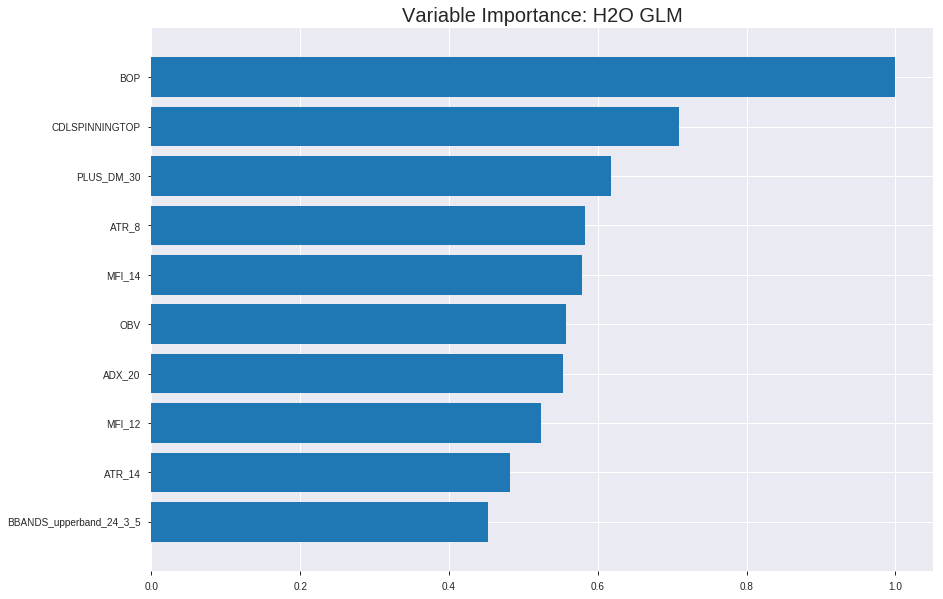

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190826_213232_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24888087303850298
RMSE: 0.498879617782189
LogLoss: 0.6909059738939686
Null degrees of freedom: 1557
Residual degrees of freedom: 1506
Null deviance: 2158.8195441369685
Residual deviance: 2152.863014653606
AIC: 2256.863014653606
AUC: 0.5565751655973128
pr_auc: 0.5254545404546106
Gini: 0.11315033119462559
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4665246455279932: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      32   767   0.9599   (767.0/799.0)
1      6    753   0.0079   (6.0/759.0)
Total  38   1520  0.4961   (773.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.466525     0.660816  370
max f2                       0.464488     0.826401  378
max f0point5                 0.471569     0.554452  341
max accuracy                 0.494049     0.549422  120
max precision                0.515395     1         0
max recall                   0.452142     1         398
max specificity              0.515395     1         0
max absolute_mcc             0.471569     0.105208  341
max min_per_class_accuracy   0.487791     0.536921  190
max mean_per_class_accuracy  0.484554     0.548668  226

Gains/Lift Table: Avg response rate: 48.72 %, avg score: 48.72 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.508966           1.15464   1.15464            0.5625           0.512052  0.5625                      0.512052            0.0118577       0.0118577                  15.4644   15.4644
    2        0.0205392                   0.506944           1.15464   1.15464            0.5625           0.507909  0.5625                      0.50998             0.0118577       0.0237154                  15.4644   15.4644
    3        0.0301669                   0.505333           0.957927  1.09186            0.466667         0.506019  0.531915                    0.508716            0.00922266      0.0329381                  -4.20729  9.18622
    4        0.0404365                   0.504278           0.898057  1.04264            0.4375           0.504767  0.507937                    0.507713            0.00922266      0.0421607                  -10.1943  4.26417
    5        0.0500642                   0.503075           0.82108   1.00003            0.4              0.50365   0.487179                    0.506932            0.00790514      0.0500659                  -17.892   0.00337826
    6        0.100128                    0.499911           1.13162   1.06583            0.551282         0.501223  0.519231                    0.504077            0.0566535       0.106719                   13.1617   6.58255
    7        0.150193                    0.497608           1.23688   1.12284            0.602564         0.4988    0.547009                    0.502318            0.0619236       0.168643                   23.6884   12.2845
    8        0.200257                    0.495805           1.21057   1.14478            0.589744         0.496658  0.557692                    0.500903            0.0606061       0.229249                   21.0567   14.4776
    9        0.300385                    0.492591           1.05267   1.11407            0.512821         0.494096  0.542735                    0.498634            0.105402        0.334651                   5.26671   11.4073
    10       0.399872                    0.490235           0.966756  1.07742            0.470968         0.491268  0.52488                     0.496801            0.0961792       0.43083                    -3.32441  7.74209
    11       0.5                         0.487715           1.06583   1.0751             0.519231         0.489019  0.523748                    0.495243            0.106719        0.537549                   6.58255   7.50988
    12       0.600128                    0.484983           1.09214   1.07794            0.532051         0.486406  0.525134                    0.493769            0.109354        0.646904                   9.21422   7.79424
    13       0.699615                    0.481929           0.90054   1.05272            0.43871          0.483571  0.512844                    0.492319            0.0895916       0.736495                   -9.94602  5.27154
    14       0.799743                    0.478586           0.881609  1.03129            0.429487         0.480401  0.502408                    0.490826            0.088274        0.824769                   -11.8391  3.12928
    15       0.899872                    0.473896           1.02635   1.03074            0.5              0.476445  0.50214                     0.489226            0.102767        0.927536                   2.63505   3.07428
    16       1                           0.450332           0.723709  1                  0.352564         0.468621  0.487163                    0.487163      



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25229724996269537
RMSE: 0.5022919967137595
LogLoss: 0.6977468715146471
Null degrees of freedom: 445
Residual degrees of freedom: 394
Null deviance: 620.533011844054
Residual deviance: 622.3902093910652
AIC: 726.3902093910652
AUC: 0.4990175822395074
pr_auc: 0.5289666088725885
Gini: -0.001964835520985253
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44787584858551704: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    203  0.9951   (203.0/204.0)
1      0    242  0        (0.0/242.0)
Total  1    445  0.4552   (203.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.447876     0.704512   398
max f2                       0.447876     0.856334   398
max f0point5                 0.469556     0.599051   320
max accuracy                 0.470683     0.553812   307
max precision                0.509868     1          0
max recall                   0.447876     1          398
max specificity              0.509868     1          0
max absolute_mcc             0.498131     0.0861447  17
max min_per_class_accuracy   0.480269     0.490196   199
max mean_per_class_accuracy  0.470683     0.530344   307

Gains/Lift Table: Avg response rate: 54.26 %, avg score: 47.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.505106           1.10579   1.10579            0.6              0.508074  0.6                         0.508074            0.0123967       0.0123967                  10.5785   10.5785
    2        0.0201794                   0.502002           0.921488  1.02388            0.5              0.503873  0.555556                    0.506207            0.00826446      0.0206612                  -7.85124  2.38751
    3        0.0313901                   0.499954           0         0.658205           0                0.5011    0.357143                    0.504383            0               0.0206612                  -100      -34.1795
    4        0.0403587                   0.498062           0.460744  0.614325           0.25             0.499052  0.333333                    0.503198            0.00413223      0.0247934                  -53.9256  -38.5675
    5        0.0515695                   0.497495           1.10579   0.721164           0.6              0.497895  0.391304                    0.502045            0.0123967       0.0371901                  10.5785   -27.8836
    6        0.100897                    0.494277           1.08903   0.90101            0.590909         0.496048  0.488889                    0.499113            0.053719        0.0909091                  8.90308   -9.89899
    7        0.150224                    0.491636           1.08903   0.962748           0.590909         0.492723  0.522388                    0.497015            0.053719        0.144628                   8.90308   -3.72518
    8        0.201794                    0.490068           1.12181   1.0034             0.608696         0.490849  0.544444                    0.495439            0.0578512       0.202479                   12.1811   0.339761
    9        0.300448                    0.486412           0.879602  0.962748           0.477273         0.488122  0.522388                    0.493037            0.0867769       0.289256                   -12.0398  -3.72518
    10       0.401345                    0.483422           1.02388   0.978115           0.555556         0.484928  0.530726                    0.490998            0.103306        0.392562                   2.38751   -2.18847
    11       0.5                         0.480193           1.00526   0.983471           0.545455         0.481603  0.533632                    0.489144            0.0991736       0.491736                   0.52592   -1.65289
    12       0.600897                    0.477014           1.02388   0.990255           0.555556         0.478743  0.537313                    0.487398            0.103306        0.595041                   2.38751   -0.974467
    13       0.699552                    0.47408            1.13092   1.01009            0.613636         0.475404  0.548077                    0.485706            0.11157         0.706612                   13.0917   1.00922
    14       0.800448                    0.469766           1.1877    1.03248            0.644444         0.472129  0.560224                    0.483995            0.119835        0.826446                   18.7695   3.24791
    15       0.899103                    0.46501            0.837716  1.01111            0.454545         0.467707  0.548628                    0.482208            0.0826446       0.909091                   -16.2284  1.11086
    16       1                           0.446631           0.90101   1                  0.488889         0.458846  0.542601                    0.4798


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-26 21:32:32  0.000 sec   2            3.3       52            1.38181           1.39549
    2019-08-26 21:32:32  0.019 sec   4            2.1       52            1.38024           1.39689
    2019-08-26 21:32:32  0.032 sec   6            1.3       52            1.37822           1.39842
    2019-08-26 21:32:32  0.045 sec   8            0.8       52            1.37573           1.39997
    2019-08-26 21:32:32  0.057 sec   10           0.5       52            1.37278           1.40142

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5605381165919282)

('F1', 0.6807228915662651)

('auc', 0.5231884057971015)

('logloss', 0.6944475596667867)

('mean_per_class_error', 0.44637681159420295)

('rmse', 0.500649718774965)

('mse', 0.25065014090945154)

glm prediction progress: |████████████████████████████████████████████████| 100%


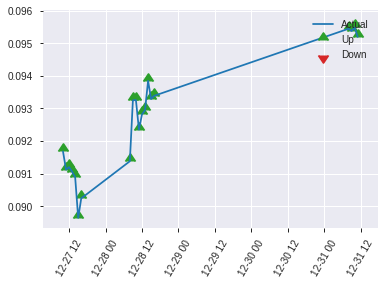


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.25065014090945154
RMSE: 0.500649718774965
LogLoss: 0.6944475596667867
Null degrees of freedom: 222
Residual degrees of freedom: 171
Null deviance: 309.6501959015793
Residual deviance: 309.7236116113869
AIC: 413.7236116113869
AUC: 0.5231884057971015
pr_auc: 0.5216355998569662
Gini: 0.04637681159420293
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46736155615706804: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    104  0.963    (104.0/108.0)
1      2    113  0.0174   (2.0/115.0)
Total  6    217  0.4753   (106.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.467362     0.680723  216
max f2                       0.463063     0.841874  222
max f0point5                 0.47447      0.589988  180
max accuracy                 0.476976     0.560538  160
max precision                0.498329     1         0
max recall                   0.463063     1         222
max specificity              0.498329     1         0
max absolute_mcc             0.47447      0.129878  180
max min_per_class_accuracy   0.481302     0.490741  111
max mean_per_class_accuracy  0.476976     0.553623  160

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 48.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.496653           1.29275   1.29275            0.666667         0.497431  0.666667                    0.497431            0.0173913       0.0173913                  29.2754   29.2754
    2        0.0224215                   0.495951           0.969565  1.16348            0.5              0.496287  0.6                         0.496973            0.00869565      0.026087                   -3.04348  16.3478
    3        0.0313901                   0.495522           0.969565  1.10807            0.5              0.49577   0.571429                    0.49663             0.00869565      0.0347826                  -3.04348  10.8075
    4        0.0403587                   0.494765           0.969565  1.07729            0.5              0.495238  0.555556                    0.496321            0.00869565      0.0434783                  -3.04348  7.72947
    5        0.0538117                   0.494395           0.646377  0.969565           0.333333         0.494633  0.5                         0.495899            0.00869565      0.0521739                  -35.3623  -3.04348
    6        0.103139                    0.490726           1.05771   1.01172            0.545455         0.492511  0.521739                    0.494278            0.0521739       0.104348                   5.77075   1.17202
    7        0.152466                    0.488735           0.528854  0.855499           0.272727         0.489814  0.441176                    0.492834            0.026087        0.130435                   -47.1146  -14.4501
    8        0.201794                    0.48783            1.41028   0.991111           0.727273         0.488199  0.511111                    0.491701            0.0695652       0.2                        41.0277   -0.888889
    9        0.300448                    0.485357           1.14585   1.04192            0.590909         0.486709  0.537313                    0.490062            0.113043        0.313043                   14.585    4.19208
    10       0.399103                    0.48296            0.969565  1.02404            0.5              0.48414   0.52809                     0.488598            0.0956522       0.408696                   -3.04348  2.40352
    11       0.502242                    0.481302           0.8431    0.986879           0.434783         0.482222  0.508929                    0.487289            0.0869565       0.495652                   -15.69    -1.31211
    12       0.600897                    0.479232           1.23399   1.02745            0.636364         0.480306  0.529851                    0.486142            0.121739        0.617391                   23.3992   2.74497
    13       0.699552                    0.477328           1.32213   1.06901            0.681818         0.478186  0.551282                    0.48502             0.130435        0.747826                   32.2134   6.90078
    14       0.798206                    0.474773           0.969565  1.05672            0.5              0.475957  0.544944                    0.4839              0.0956522       0.843478                   -3.04348  5.67171
    15       0.896861                    0.47176            0.705138  1.01804            0.363636         0.47326   0.525                       0.48273             0.0695652       0.913043                   -29.4862  1.80435
    16       1                           0.463063           0.8431    1                  0.434783         0.468682  0.515695                    0.481281    

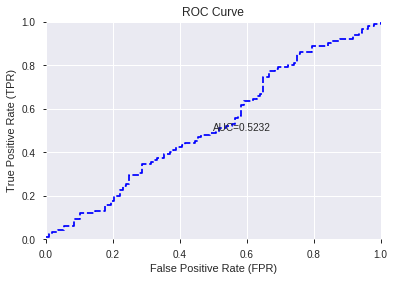

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


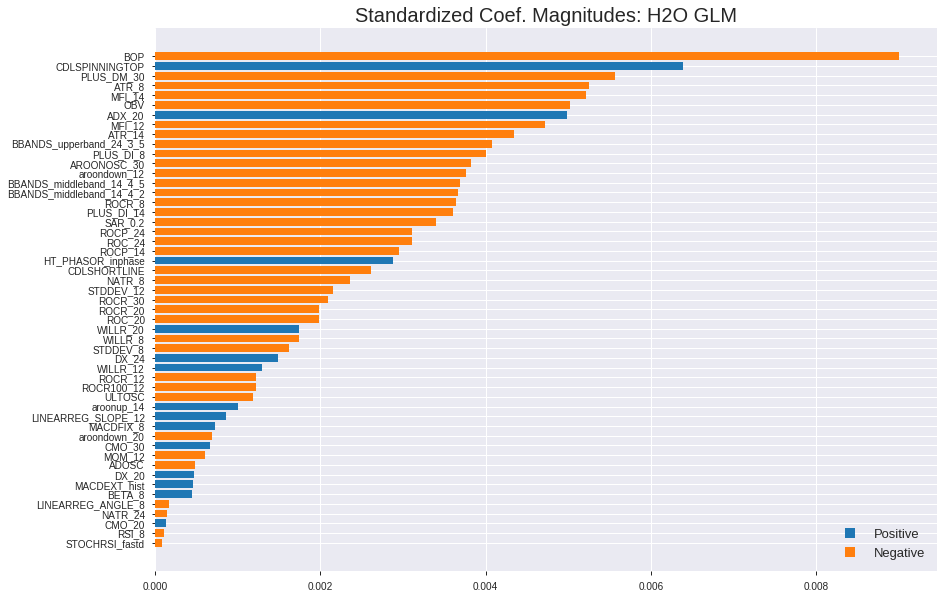

'log_likelihood'
--2019-08-26 21:32:38--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.82.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.82.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190826_213232_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190826_213232_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_afb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'CDLSPINNINGTOP',
 'PLUS_DM_30',
 'ATR_8',
 'MFI_14',
 'OBV',
 'ADX_20',
 'MFI_12',
 'ATR_14',
 'BBANDS_upperband_24_3_5',
 'PLUS_DI_8',
 'AROONOSC_30',
 'aroondown_12',
 'BBANDS_middleband_14_4_5',
 'BBANDS_middleband_14_4_2',
 'ROCR_8',
 'PLUS_DI_14',
 'SAR_0.2',
 'ROCP_24',
 'ROC_24',
 'ROCP_14',
 'HT_PHASOR_inphase',
 'CDLSHORTLINE',
 'NATR_8',
 'STDDEV_12',
 'ROCR_30',
 'ROCR_20',
 'ROC_20',
 'WILLR_20',
 'WILLR_8',
 'STDDEV_8',
 'DX_24',
 'WILLR_12',
 'ROCR_12',
 'ROCR100_12',
 'ULTOSC',
 'aroonup_14',
 'LINEARREG_SLOPE_12',
 'MACDFIX_8',
 'aroondown_20',
 'CMO_30',
 'MOM_12',
 'ADOSC',
 'DX_20',
 'MACDEXT_hist',
 'BETA_8',
 'LINEARREG_ANGLE_8',
 'NATR_24',
 'CMO_20',
 'RSI_8',
 'STOCHRSI_fastd']

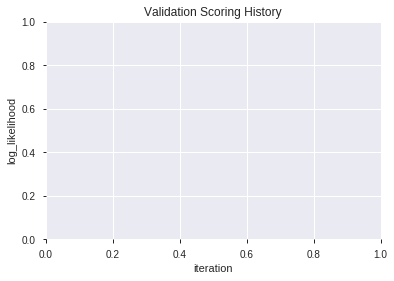

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190826_213244  0.570451  0.692194              0.448510  0.499635  0.249635
1  XGBoost_grid_1_AutoML_20190826_213244_model_2  0.557085  0.691053              0.453422  0.499068  0.249068
2  XGBoost_grid_1_AutoML_20190826_213244_model_7  0.550886  0.706645              0.490741  0.506122  0.256159
3  XGBoost_grid_1_AutoML_20190826_213244_model_1  0.544767  0.701636              0.456924  0.503897  0.253912
4  XGBoost_grid_1_AutoML_20190826_213244_model_4  0.540902  0.696663              0.471940  0.501697  0.251700
5               XGBoost_3_AutoML_20190826_213244  0.540338  0.702504              0.462118  0.504461  0.254481
6               XGBoost_2_AutoML_20190826_213244  0.539614  0.705374              0.466184  0.505695  0.255728
7  XGBoost_grid_1_AutoML_20190826_213244_model_6  0.534622  0.705772              0.480918  0.505976  0.256012
8  XGBoost_grid_1_AutoML_20190826_213244_model_5  0.521900  0.737061              0.480636  0.518900  0.269257
9  XGBoost_grid_1_AutoML_20190826_213244_model_3  0.504509  0.717427              0.471940  0.511651  0.261787

variable  relative_importance  scaled_importance  percentage
0          HT_PHASOR_inphase           288.666931           1.000000    0.042589
1                        BOP           273.736389           0.948278    0.040386
2                     BETA_8           264.226074           0.915332    0.038983
3                     MFI_12           237.031265           0.821124    0.034971
4                      ADOSC           199.198578           0.690064    0.029389
5                     MFI_14           195.914444           0.678687    0.028905
6                   WILLR_20           184.988449           0.640837    0.027293
7                      DX_20           181.401611           0.628411    0.026764
8                     ATR_14           176.725876           0.612214    0.026074
9                     NATR_8           170.472794           0.590552    0.025151
10            STOCHRSI_fastd           164.046997           0.568292    0.024203
11                       OBV           161.202011           0.558436    0.023783
12                  STDDEV_8           160.886276           0.557342    0.023737
13                    ROC_20           160.773392           0.556951    0.023720
14                    ROC_24           153.128754           0.530469    0.022592
15                    ROCR_8           153.050430           0.530197    0.022581
16                  WILLR_12           152.461594           0.528157    0.022494
17                     ATR_8           150.840881           0.522543    0.022255
18                 STDDEV_12           150.239960           0.520461    0.022166
19                    CMO_30           147.797180           0.511999    0.021806
20                   WILLR_8           145.500168           0.504042    0.021467
21                PLUS_DM_30           143.828156           0.498250    0.021220
22              MACDEXT_hist           142.935852           0.495158    0.021088
23                    ADX_20           141.905243           0.491588    0.020936
24                   ROCP_14           141.417328           0.489898    0.020864
25         LINEARREG_ANGLE_8           140.376633           0.486293    0.020711
26                    ULTOSC           138.201736           0.478758    0.020390
27                   ROCR_30           135.969360           0.471025    0.020061
28                 PLUS_DI_8           135.106506           0.468036    0.019933
29                     RSI_8           131.122192           0.454234    0.019345
30        LINEARREG_SLOPE_12           119.507309           0.413997    0.017632
31  BBANDS_middleband_14_4_2           116.717682           0.404333    0.017220
32                   NATR_24           113.916779           0.394631    0.016807
33                    CMO_20           112.668205           0.390305    0.016623
34                PLUS_DI_14           112.579285           0.389997    0.016610
35                   SAR_0.2           112.378998           0.389303    0.016580
36                 MACDFIX_8           110.864517           0.384057    0.016357
37                     DX_24           110.492477           0.382768    0.016302
38                aroonup_14           104.000938           0.360280    0.015344
39   BBANDS_upperband_24_3_5            96.458160           0.334150    0.014231
40                   ROCR_12            95.438065           0.330617    0.014081
41               AROONOSC_30            93.473328           0.323810    0.013791
42                    MOM_12            76.644440           0.265512    0.011308
43              aroondown_20            63.492241           0.219950    0.009367
44                   ROCP_24            55.385475           0.191866    0.008171
45              aroondown_12            53.296776           0.184631    0.007863
46                   ROCR_20            41.496761           0.143753    0.006122
47                ROCR100_12            23.814562           0.082498    0.003514
48  BBANDS_middleband_14_4_5            23.709314  

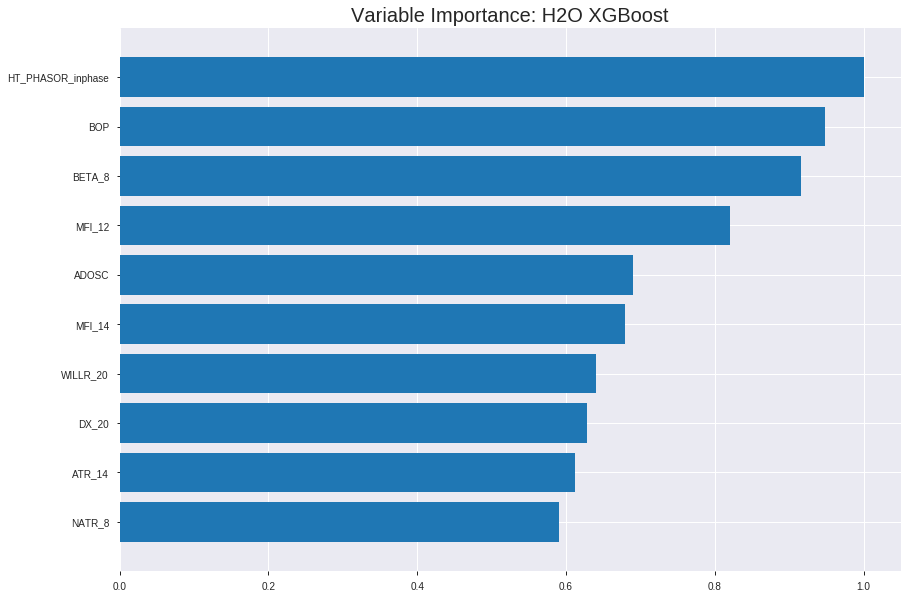

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190826_213244


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15222475566228266
RMSE: 0.39015991037301956
LogLoss: 0.4892440396763008
Mean Per-Class Error: 0.08751304743577693
AUC: 0.9724631085299311
pr_auc: 0.9716910962551756
Gini: 0.9449262170598622
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4819815158843994: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      716  83   0.1039   (83.0/799.0)
1      54   705  0.0711   (54.0/759.0)
Total  770  788  0.0879   (137.0/1558.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.481982     0.911441  214
max f2                       0.451455     0.939093  236
max f0point5                 0.535336     0.923731  176
max accuracy                 0.481982     0.912067  214
max precision                0.840879     1         0
max recall                   0.347538     1         315
max specificity              0.840879     1         0
max absolute_mcc             0.481982     0.824757  214
max min_per_class_accuracy   0.490782     0.906456  207
max mean_per_class_accuracy  0.481982     0.912487  214

Gains/Lift Table: Avg response rate: 48.72 %, avg score: 48.96 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0102696                   0.771036           2.0527     2.0527             1                0.789203  1                           0.789203            0.0210804       0.0210804                  105.27    105.27
    2        0.0205392                   0.75604            2.0527     2.0527             1                0.762712  1                           0.775957            0.0210804       0.0421607                  105.27    105.27
    3        0.0301669                   0.742627           2.0527     2.0527             1                0.747955  1                           0.767021            0.0197628       0.0619236                  105.27    105.27
    4        0.0404365                   0.731342           2.0527     2.0527             1                0.735614  1                           0.759044            0.0210804       0.083004                   105.27    105.27
    5        0.0500642                   0.722612           2.0527     2.0527             1                0.727432  1                           0.752965            0.0197628       0.102767                   105.27    105.27
    6        0.100128                    0.687919           2.0527     2.0527             1                0.704903  1                           0.728934            0.102767        0.205534                   105.27    105.27
    7        0.150193                    0.658844           2.0527     2.0527             1                0.674077  1                           0.710648            0.102767        0.3083                     105.27    105.27
    8        0.200257                    0.637333           2.0527     2.0527             1                0.646974  1                           0.69473             0.102767        0.411067                   105.27    105.27
    9        0.300385                    0.5877             2.03954    2.04831            0.99359          0.614382  0.997863                    0.667947            0.204216        0.615283                   103.954   104.831
    10       0.399872                    0.538084           1.76135    1.97692            0.858065         0.56295   0.963082                    0.641824            0.175231        0.790514                   76.135    97.6919
    11       0.5                         0.483668           1.30268    1.8419             0.634615         0.510095  0.897304                    0.615445            0.130435        0.920949                   30.2676   84.1897
    12       0.600128                    0.435019           0.592125   1.63338            0.288462         0.4602    0.795722                    0.589543            0.0592885       0.980237                   -40.7875  63.3379
    13       0.699615                    0.385655           0.132432   1.41994            0.0645161        0.409362  0.691743                    0.563921            0.0131752       0.993412                   -86.7568  41.9942
    14       0.799743                    0.34235            0.0657917  1.2504             0.0320513        0.362545  0.609149                    0.538708            0.00658762      1                          -93.4208  25.0401
    15       0.899872                    0.300904           0          1.11127            0                0.32      0.541369                    0.514373            0               1                          -100      11.127
    16       1                           0.181724           0          1                  0                0.266814  0.487163                    0.489585



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2624431815831685
RMSE: 0.5122920862000198
LogLoss: 0.7199364123554763
Mean Per-Class Error: 0.4739709933560201
AUC: 0.5048715767298655
pr_auc: 0.540192486230898
Gini: 0.00974315345973098
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24614153802394867: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    202  0.9902   (202.0/204.0)
1      0    242  0        (0.0/242.0)
Total  2    444  0.4529   (202.0/446.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.246142     0.705539   397
max f2                       0.246142     0.856941   397
max f0point5                 0.246142     0.599604   397
max accuracy                 0.294712     0.547085   385
max precision                0.588533     0.618421   70
max recall                   0.246142     1          397
max specificity              0.80319      0.995098   0
max absolute_mcc             0.663385     0.0837685  19
max min_per_class_accuracy   0.484649     0.5        196
max mean_per_class_accuracy  0.588533     0.526029   70

Gains/Lift Table: Avg response rate: 54.26 %, avg score: 48.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0112108                   0.724214           0.73719   0.73719            0.4              0.762014  0.4                         0.762014            0.00826446      0.00826446                 -26.281   -26.281
    2        0.0201794                   0.695208           0.921488  0.8191             0.5              0.703255  0.444444                    0.735899            0.00826446      0.0165289                  -7.85124  -18.09
    3        0.0313901                   0.68736            0.73719   0.789847           0.4              0.691162  0.428571                    0.719922            0.00826446      0.0247934                  -26.281   -21.0153
    4        0.0403587                   0.666556           0.460744  0.716713           0.25             0.676663  0.388889                    0.710308            0.00413223      0.0289256                  -53.9256  -28.3287
    5        0.0515695                   0.653535           0.73719   0.721164           0.4              0.660856  0.391304                    0.699558            0.00826446      0.0371901                  -26.281   -27.8836
    6        0.100897                    0.618882           1.34035   1.02388            0.727273         0.636726  0.555556                    0.66884             0.0661157       0.103306                   34.0346   2.38751
    7        0.150224                    0.595992           1.34035   1.12779            0.727273         0.60727   0.61194                     0.648623            0.0661157       0.169421                   34.0346   12.7791
    8        0.201794                    0.580011           0.961552  1.08531            0.521739         0.587193  0.588889                    0.632924            0.0495868       0.219008                   -3.84477  8.53076
    9        0.300448                    0.542582           0.879602  1.01776            0.477273         0.561006  0.552239                    0.609309            0.0867769       0.305785                   -12.0398  1.77624
    10       0.401345                    0.510864           0.941965  0.998707           0.511111         0.523456  0.541899                    0.587726            0.0950413       0.400826                   -5.80349  -0.129277
    11       0.5                         0.482749           1.00526   1                  0.545455         0.495877  0.542601                    0.569603            0.0991736       0.5                        0.52592   0
    12       0.600897                    0.453724           0.941965  0.990255           0.511111         0.468256  0.537313                    0.552586            0.0950413       0.595041                   -5.80349  -0.974467
    13       0.699552                    0.425533           1.04715   0.998278           0.568182         0.441481  0.541667                    0.536917            0.103306        0.698347                   4.7145    -0.172176
    14       0.800448                    0.39411            1.02388   1.0015             0.555556         0.409786  0.543417                    0.520892            0.103306        0.801653                   2.38751   0.150473
    15       0.899103                    0.343136           1.04715   1.00651            0.568182         0.371288  0.546135                    0.504477            0.103306        0.904959                   4.7145    0.651264
    16       1                           0.224609           0.941965  1                  0.511111         0.305102  0.542601                    0.484361     


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-26 21:32:45  0.005 sec   0                  0.5              0.693147            0.5             0                  1                0.512837                         0.5                0.693147              0.5               0                    1                  0.457399
    2019-08-26 21:32:45  0.137 sec   5                  0.486017         0.665506            0.798851        0.78725            1.79611          0.304236                         0.500034           0.693228              0.533027          0.564153             1.10579            0.457399
    2019-08-26 21:32:45  0.220 sec   10                 0.474219         0.642628            0.847081        0.84849            2.0527           0.268935                         0.499835           0.692828              0.540715          0.566943             0.368595           0.44843
    2019-08-26 21:32:45  0.304 sec   15                 0.462066         0.619425            0.882074        0.878225           2.0527           0.184852                         0.502359           0.697957              0.516681          0.550562             0                  0.44843
    2019-08-26 21:32:45  0.393 sec   20                 0.449908         0.596605            0.908899        0.909389           2.0527           0.17715                          0.505157           0.703728              0.50158           0.53611              0                  0.443946
    2019-08-26 21:32:45  0.485 sec   25                 0.439448         0.577197            0.922963        0.922272           2.0527           0.154685                         0.507199           0.708027              0.495685          0.531722             0                  0.446188
    2019-08-26 21:32:45  0.577 sec   30                 0.428154         0.556599            0.939675        0.939066           2.0527           0.14249                          0.508904           0.711811              0.493731          0.528617             0.73719            0.452915
    2019-08-26 21:32:45  0.683 sec   35                 0.417618         0.53765             0.953869        0.952662           2.0527           0.114249                         0.510484           0.71531               0.49291           0.527735             0.73719            0.452915
    2019-08-26 21:32:45  0.773 sec   40                 0.408274         0.521012            0.960852        0.959854           2.0527           0.110398                         0.511271           0.717177              0.498015          0.534623             0.73719            0.452915
    2019-08-26 21:32:45  0.865 sec   45                 0.398723         0.504308            0.968816        0.968511           2.0527           0.0969191                        0.511471           0.717835              0.501377          0.533392             0.73719            0.452915
    2019-08-26 21:32:46  0.961 sec   50                 0.39016          0.489244            0.972463        0.971691           2.0527           0.0879332                        0.512292           0.719936              0.504872          0.540192             0.73719            0.452915

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
HT_PHASOR_inphase         288.66693115234375     1.0                  0.042589158881195646
BOP                       273.73638916015625     0.9482776155461052   0.040386346031974434
BETA_8                    264.22607421875        0.9153319819626478   0.03898321920884691
MFI_12                    237.03126525878906     0.8211237231523967   0.03497096870645633
ADOSC                     199.19857788085938     0.6900637252963779   0.029389233634797184
---                       ---                    ---                  ---
aroondown_12              53.296775817871094     0.18463069394583254  0.00786326595880447
ROCR_20                   41.496761322021484     0.14375308303021936  0.0061223228928357215
ROCR100_12                23.81456184387207      0.08249840655043357  0.0035135377440218864
BBANDS_middleband_14_4_5  23.709314346313477     0.0821338081631557   0.003498009805378282
CDLSPINNINGTOP            18.455562591552734     0.06393376102305541  0.0027228851060833


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5964125560538116)

('F1', 0.69969040247678)

('auc', 0.570450885668277)

('logloss', 0.6921937612000928)

('mean_per_class_error', 0.4090579710144927)

('rmse', 0.49963467941543166)

('mse', 0.24963481287456116)

xgboost prediction progress: |████████████████████████████████████████████| 100%


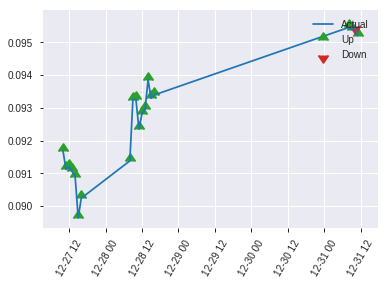


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.24963481287456116
RMSE: 0.49963467941543166
LogLoss: 0.6921937612000928
Mean Per-Class Error: 0.4090579710144927
AUC: 0.570450885668277
pr_auc: 0.5533045650559941
Gini: 0.1409017713365539
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.317735880613327: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      13   95   0.8796   (95.0/108.0)
1      2    113  0.0174   (2.0/115.0)
Total  15   208  0.435    (97.0/223.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.317736     0.69969   207
max f2                       0.263622     0.848083  217
max f0point5                 0.416682     0.611961  150
max accuracy                 0.416682     0.596413  150
max precision                0.739979     1         0
max recall                   0.263622     1         217
max specificity              0.739979     1         0
max absolute_mcc             0.317736     0.205462  207
max min_per_class_accuracy   0.46969      0.509259  111
max mean_per_class_accuracy  0.416682     0.590942  150

Gains/Lift Table: Avg response rate: 51.57 %, avg score: 47.18 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0134529                   0.693078           1.29275   1.29275            0.666667         0.712308  0.666667                    0.712308            0.0173913       0.0173913                  29.2754   29.2754
    2        0.0224215                   0.67492            0.969565  1.16348            0.5              0.687457  0.6                         0.702368            0.00869565      0.026087                   -3.04348  16.3478
    3        0.0313901                   0.65822            0         0.831056           0                0.665037  0.428571                    0.691702            0               0.026087                   -100      -16.8944
    4        0.0403587                   0.641661           1.93913   1.07729            1                0.649401  0.555556                    0.682301            0.0173913       0.0434783                  93.913    7.72947
    5        0.0538117                   0.633565           0.646377  0.969565           0.333333         0.636838  0.5                         0.670935            0.00869565      0.0521739                  -35.3623  -3.04348
    6        0.103139                    0.605329           1.41028   1.18034            0.727273         0.616012  0.608696                    0.644668            0.0695652       0.121739                   41.0277   18.034
    7        0.152466                    0.581585           1.05771   1.14066            0.545455         0.59221   0.588235                    0.627696            0.0521739       0.173913                   5.77075   14.0665
    8        0.201794                    0.57036            0.881423  1.07729            0.454545         0.577393  0.555556                    0.6154              0.0434783       0.217391                   -11.8577  7.72947
    9        0.300448                    0.539999           1.23399   1.12875            0.636364         0.550535  0.58209                     0.594101            0.121739        0.33913                    23.3992   12.8748
    10       0.399103                    0.508457           1.05771   1.11119            0.545455         0.525847  0.573034                    0.577229            0.104348        0.443478                   5.77075   11.1187
    11       0.502242                    0.46969            0.67448   1.02151            0.347826         0.488432  0.526786                    0.558994            0.0695652       0.513043                   -32.552   2.15062
    12       0.600897                    0.431009           1.49842   1.09981            0.772727         0.450986  0.567164                    0.541261            0.147826        0.66087                    49.8419   9.98053
    13       0.699552                    0.40972            1.23399   1.11873            0.636364         0.421096  0.576923                    0.524315            0.121739        0.782609                   23.3992   11.8729
    14       0.798206                    0.375408           0.616996  1.05672            0.318182         0.398438  0.544944                    0.508757            0.0608696       0.843478                   -38.3004  5.67171
    15       0.896861                    0.340398           0.793281  1.02774            0.409091         0.357157  0.53                        0.492081            0.0782609       0.921739                   -20.6719  2.77391
    16       1                           0.232661           0.75879   1                  0.391304         0.295638  0.515695                    0.47182         

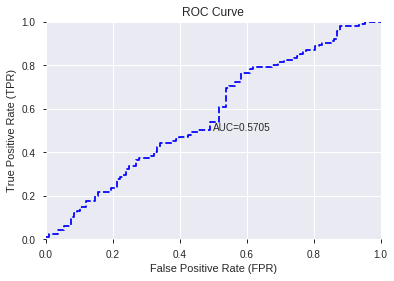

This function is available for GLM models only


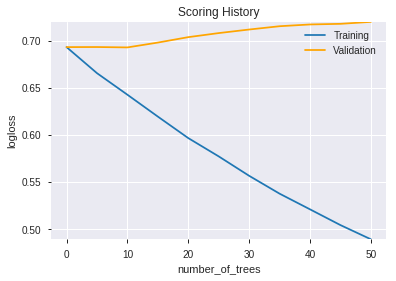

--2019-08-26 21:33:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.108.91
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.108.91|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.j

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190826_213244',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190826_213244',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_afb1',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_afb1',
   'ty

['HT_PHASOR_inphase',
 'BOP',
 'BETA_8',
 'MFI_12',
 'ADOSC',
 'MFI_14',
 'WILLR_20',
 'DX_20',
 'ATR_14',
 'NATR_8',
 'STOCHRSI_fastd',
 'OBV',
 'STDDEV_8',
 'ROC_20',
 'ROC_24',
 'ROCR_8',
 'WILLR_12',
 'ATR_8',
 'STDDEV_12',
 'CMO_30',
 'WILLR_8',
 'PLUS_DM_30',
 'MACDEXT_hist',
 'ADX_20',
 'ROCP_14',
 'LINEARREG_ANGLE_8',
 'ULTOSC',
 'ROCR_30',
 'PLUS_DI_8',
 'RSI_8',
 'LINEARREG_SLOPE_12',
 'BBANDS_middleband_14_4_2',
 'NATR_24',
 'CMO_20',
 'PLUS_DI_14',
 'SAR_0.2',
 'MACDFIX_8',
 'DX_24',
 'aroonup_14',
 'BBANDS_upperband_24_3_5',
 'ROCR_12',
 'AROONOSC_30',
 'MOM_12',
 'aroondown_20',
 'ROCP_24',
 'aroondown_12',
 'ROCR_20',
 'ROCR100_12',
 'BBANDS_middleband_14_4_5',
 'CDLSPINNINGTOP']

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.592
GLM             0.561
XGBoost         0.596
dtype: float64

DeepLearning    GLM  XGBoost
All          0.547  0.543    0.574
DLF          0.556  0.516    0.556
Fwe          0.543  0.543    0.574
RFE          0.592  0.561    0.596
XGBF         0.565  0.516    0.556





F1


DeepLearning    0.683
GLM             0.681
XGBoost         0.700
dtype: float64

DeepLearning    GLM  XGBoost
All          0.681  0.681    0.687
DLF          0.680  0.680    0.685
Fwe          0.683  0.681    0.687
RFE          0.680  0.681    0.700
XGBF         0.682  0.680    0.685





auc


DeepLearning    0.559
GLM             0.523
XGBoost         0.570
dtype: float64

DeepLearning    GLM  XGBoost
All          0.538  0.472    0.550
DLF          0.539  0.458    0.539
Fwe          0.528  0.472    0.550
RFE          0.559  0.523    0.570
XGBF         0.556  0.458    0.539





logloss


DeepLearning    0.780
GLM             0.714
XGBoost         0.708
dtype: float64

DeepLearning    GLM  XGBoost
All          0.696  0.699    0.708
DLF          0.780  0.714    0.698
Fwe          0.694  0.699    0.708
RFE          0.694  0.694    0.692
XGBF         0.779  0.714    0.698





mean_per_class_error


DeepLearning    0.459
GLM             0.489
XGBoost         0.451
dtype: float64

DeepLearning    GLM  XGBoost
All          0.443  0.470    0.435
DLF          0.438  0.489    0.451
Fwe          0.459  0.470    0.435
RFE          0.413  0.446    0.409
XGBF         0.434  0.489    0.451





rmse


DeepLearning    0.530
GLM             0.510
XGBoost         0.507
dtype: float64

DeepLearning    GLM  XGBoost
All          0.501  0.503    0.507
DLF          0.525  0.510    0.502
Fwe          0.501  0.503    0.507
RFE          0.500  0.501    0.500
XGBF         0.530  0.510    0.502





mse


DeepLearning    0.281
GLM             0.260
XGBoost         0.257
dtype: float64

DeepLearning    GLM  XGBoost
All          0.251  0.253    0.257
DLF          0.276  0.260    0.252
Fwe          0.251  0.253    0.257
RFE          0.250  0.251    0.250
XGBF         0.281  0.260    0.252

{'F1':       DeepLearning    GLM  XGBoost
 All          0.681    NaN      NaN
 DLF          0.680    NaN      NaN
 DLF            NaN  0.680      NaN
 DLF            NaN    NaN    0.685
 All            NaN  0.681      NaN
 All            NaN    NaN    0.687
 XGBF         0.682    NaN      NaN
 XGBF           NaN  0.680      NaN
 XGBF           NaN    NaN    0.685
 Fwe          0.683    NaN      NaN
 Fwe            NaN  0.681      NaN
 Fwe            NaN    NaN    0.687
 RFE          0.680    NaN      NaN
 RFE            NaN  0.681      NaN
 RFE            NaN    NaN    0.700,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.547    NaN      NaN
 DLF          0.556    NaN      NaN
 DLF            NaN  0.516      NaN
 DLF            NaN    NaN    0.556
 All            NaN  0.543      NaN
 All            NaN    NaN    0.574
 XGBF         0.565    NaN      NaN
 XGBF           NaN  0.516      NaN
 XGBF           NaN    NaN    0.556
 Fwe          0.543    NaN      NaN
 Fwe     